In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252')]

In [6]:
model_path = models_folder / "model_conv_64_8_B1H_Inst_252"
# the model's seen indices are broken due to multiprocessing

# Load model and associated generators

In [7]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# # load the indices of the data seen by the model
# train_seen_indices = np.load(model_path / "train_seen_indices.npy")
# validation_seen_indices = np.load(model_path / "validation_seen_indices.npy")

# load the indices of the data train/validataion split
train_split_indices = np.load(model_path / "train_split_indices.npy")
validation_split_indices = np.load(model_path / "validation_split_indices.npy")


# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_split_indices]
validation_metadata = data_metadata_df.iloc[validation_split_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1024, 64)          512       
_________________________________________________________________
dropout (Dropout)            (None, 1024, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 8)            3592      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1024, 8)           456       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 8)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 2048, 64)          3648      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 2048, 1)           4

Dec/11 14:23:35 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Dec/11 14:23:35 pyobsbox.generator INFO: batch_size: 8192
Dec/11 14:23:35 pyobsbox.generator INFO: sequence_length: 2048
Dec/11 14:23:35 pyobsbox.generator INFO: n_bunches: 256
Dec/11 14:23:35 pyobsbox.generator INFO: __len__: 41222
Dec/11 14:23:35 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Dec/11 14:23:35 pyobsbox.generator INFO: batch_size: 8192
Dec/11 14:23:35 pyobsbox.generator INFO: sequence_length: 2048
Dec/11 14:23:35 pyobsbox.generator INFO: n_bunches: 256
Dec/11 14:23:35 pyobsbox.generator INFO: __len__: 4581


In [8]:
print(train_metadata.shape)
train_metadata.head()

(10552772, 11)


type  fill  beam plane  q           date_time  \
1  Inst  7478     1     h  7 2018-11-27 14:49:16   
2  Inst  7478     1     h  7 2018-11-27 14:49:16   
3  Inst  7478     1     h  7 2018-11-27 14:49:16   
5  Inst  7478     1     h  7 2018-11-27 14:49:16   
6  Inst  7478     1     h  7 2018-11-27 14:49:16   

                                                file  n_bunches  bunch_index  \
1  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...         20          0.0   
2  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...         20          4.0   
3  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...         20          8.0   
5  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...         20        894.0   
6  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...         20        898.0   

   bunch_number  ts_length  
1           0.0      65536  
2           1.0      65536  
3           2.0      65536  
5           4.0      65536  
6           5.0      65536

In [9]:
print(validation_metadata.shape)
validation_metadata.head()

(1172530, 11)


type  fill  beam plane  q           date_time  \
7160711   Inst  6628     1     h  7 2018-05-01 00:59:14   
11077362  Inst  7452     1     h  7 2018-11-17 16:28:30   
6251890   Inst  7314     1     h  7 2018-10-17 23:27:12   
1065972   Inst  6189     1     h  7 2017-09-11 07:18:14   
4943132   Inst  7477     1     h  7 2018-11-26 23:42:15   

                                                       file  n_bunches  \
7160711   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/...       1551   
11077362  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7452/...        540   
6251890   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7314/...       1212   
1065972   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6189/...       1916   
4943132   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7477/...        733   

          bunch_index  bunch_number  ts_length  
7160711         296.0         151.0      65536  
11077362        799.0         145.0      65536  
6251890         476.0         337.0      65536  
1065972        2928.0        1613.0      65536  
4943132         467.0          96.0      65536

# Loss functions

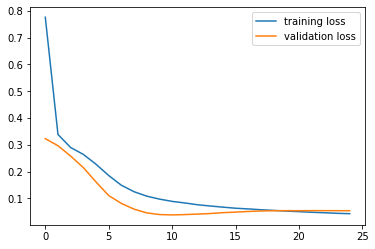

In [10]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [11]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [ ]:
# validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
# validation_dataset.shape

# Predictions

In [13]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 204s 4s/step


(409600, 2048, 1)

In [ ]:
# validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
# validation_pred.shape

In [14]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [ ]:
# MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
# MAE_validation.shape

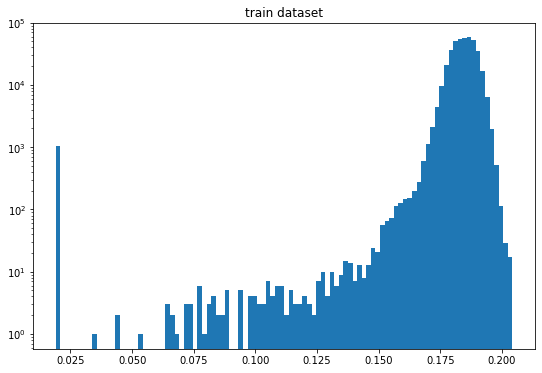

In [23]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [16]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.18577967338832213

In [ ]:
# plt.figure(figsize=(9, 6))
# n, bins, _ = plt.hist(MAE_validation, bins=100)
# plt.title("validation dataset")

In [ ]:
# hist_peak_validation = bins[n.argmax()]
# hist_peak_validation

In [17]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [18]:
max_MAE_indices

array([ 98144,  27220, 299527, ..., 257102, 370033, 237096])

In [19]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  98144
MAE:  0.2043032356540887
n_bunches        418
bunch_index     1633
bunch_number     347
Name: 3417, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h48m56s.h5


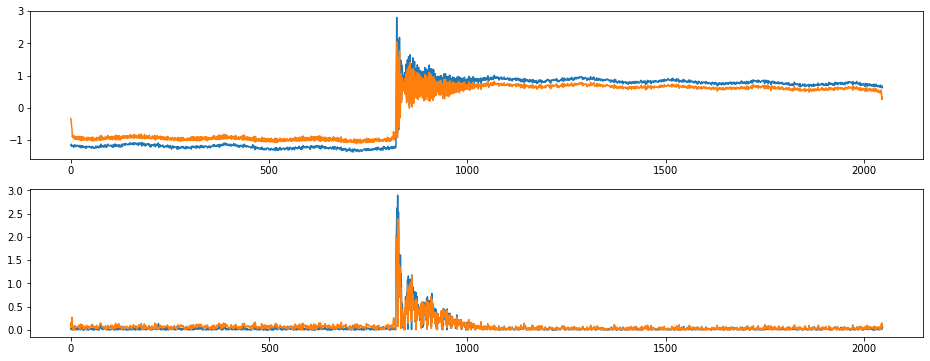

In [20]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  98144
MAE:  0.2043032356540887
n_bunches        418
bunch_index     1633
bunch_number     347
Name: 3417, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h48m56s.h5


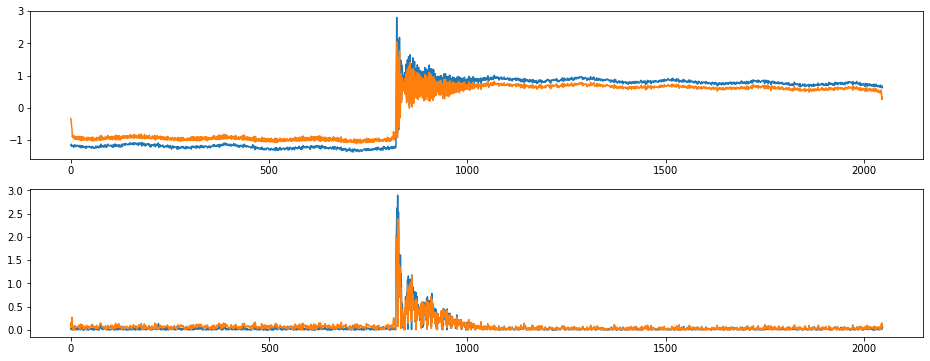

index:  27220
MAE:  0.20412398230306575
n_bunches        972
bunch_index     1385
bunch_number     732
Name: 945, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


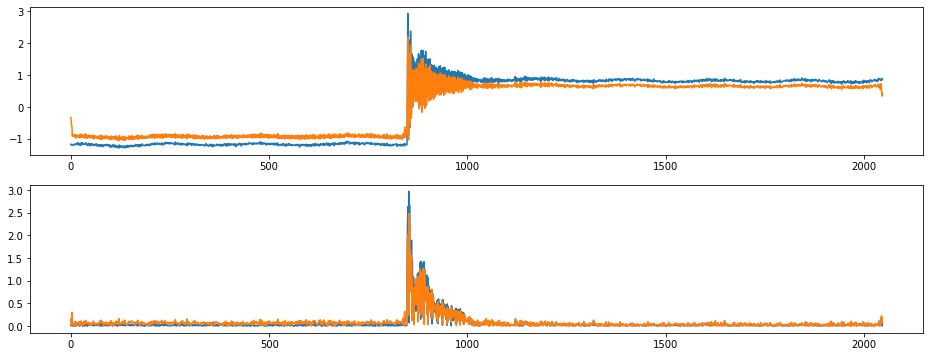

index:  299527
MAE:  0.20372102786157587
n_bunches        158
bunch_index     1863
bunch_number     109
Name: 10426, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7343/instability_data/07343_Inst_B1H_Q7_20181025_05h31m18s.h5


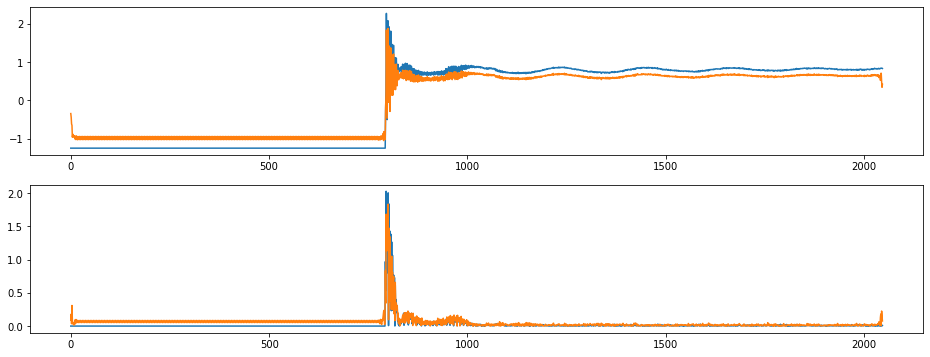

index:  4087
MAE:  0.2033589217070048
n_bunches       192
bunch_index     465
bunch_number    120
Name: 141, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6897/instability_data/06897_Inst_B1H_Q7_20180708_00h36m16s.h5


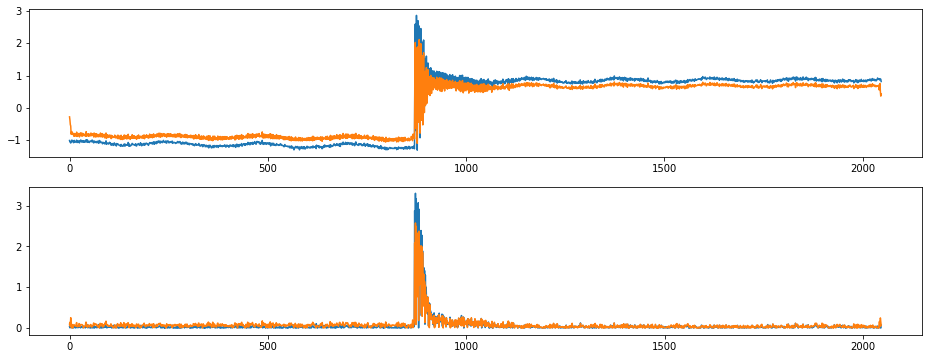

index:  128604
MAE:  0.20330656583511864
n_bunches       796
bunch_index     974
bunch_number    530
Name: 4464, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


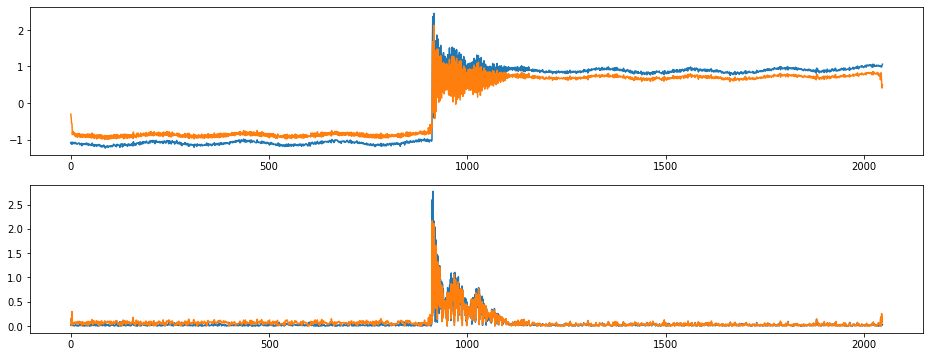

index:  37759
MAE:  0.20327522345138693
n_bunches       733
bunch_index     563
bunch_number    120
Name: 1305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5



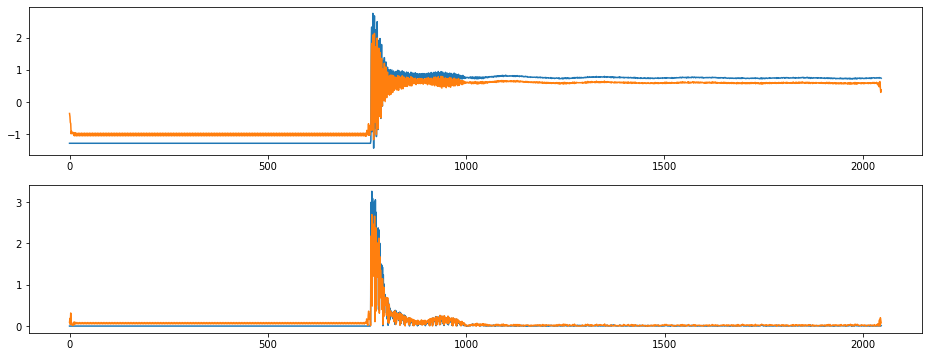

index:  75433
MAE:  0.20326854419665272
n_bunches       456
bunch_index      10
bunch_number     10
Name: 2624, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7378/instability_data/07378_Inst_B1H_Q7_20181028_22h46m14s.h5


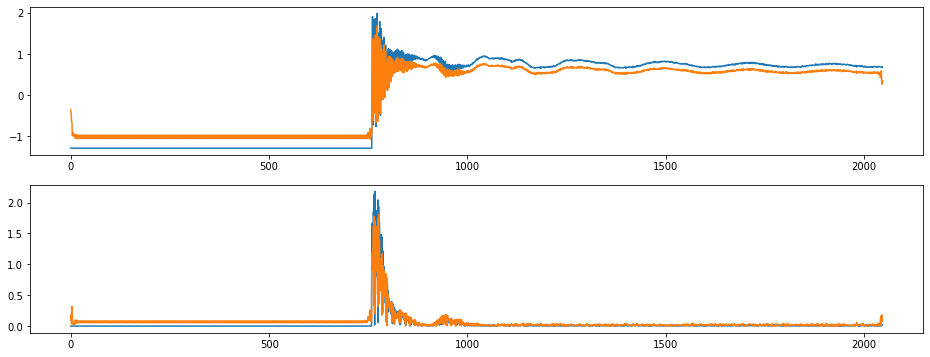

index:  321777
MAE:  0.20307966658237753
n_bunches       1358
bunch_index      243
bunch_number      70
Name: 11193, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


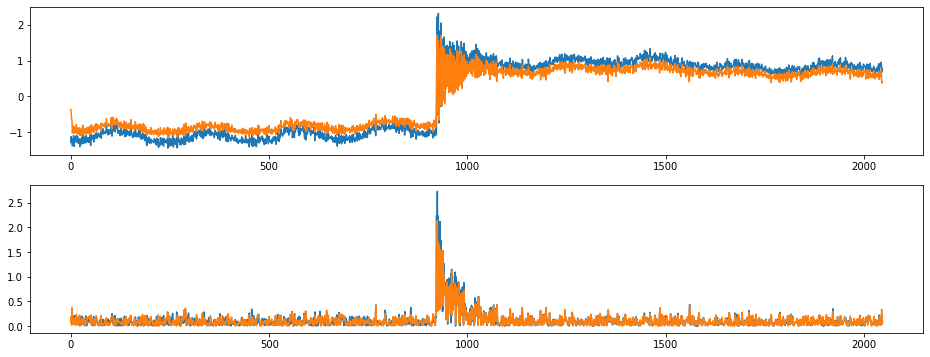

index:  387153
MAE:  0.20289224382301943
n_bunches       636
bunch_index     796
bunch_number    570
Name: 13444, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


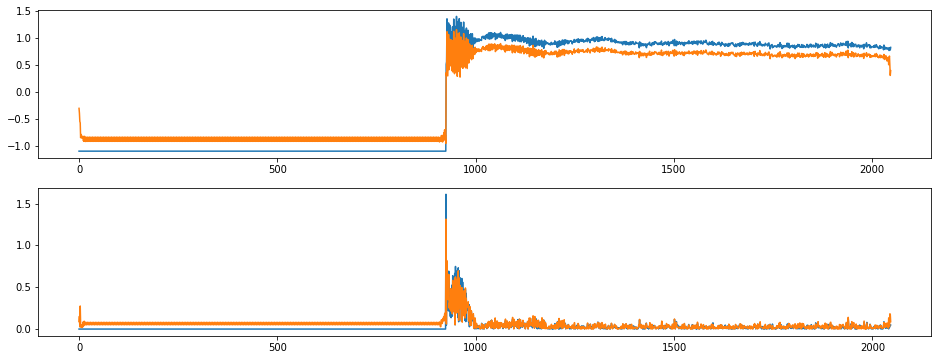

index:  25590
MAE:  0.20286620790195287
n_bunches        972
bunch_index     1274
bunch_number     679
Name: 892, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


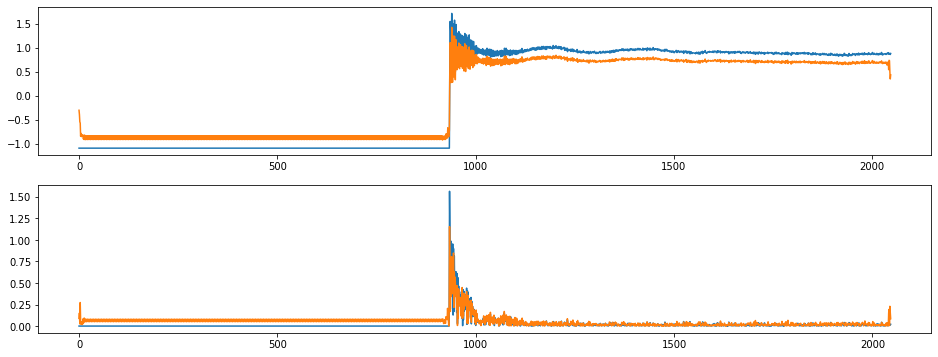

In [21]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  237096
MAE:  0.019067612996423122
n_bunches       12
bunch_index     26
bunch_number     8
Name: 8237, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7068/instability_data/07068_Inst_B1H_Q7_20180820_00h27m53s.h5


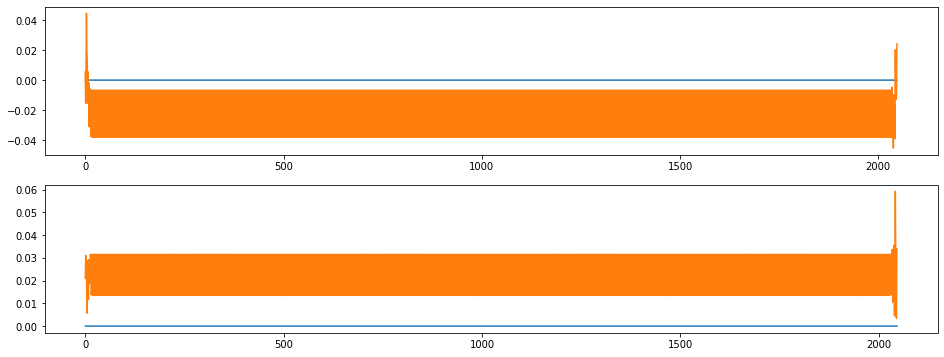

index:  370033
MAE:  0.019067612996423122
n_bunches        376
bunch_index     1712
bunch_number     359
Name: 12857, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h34m32s.h5


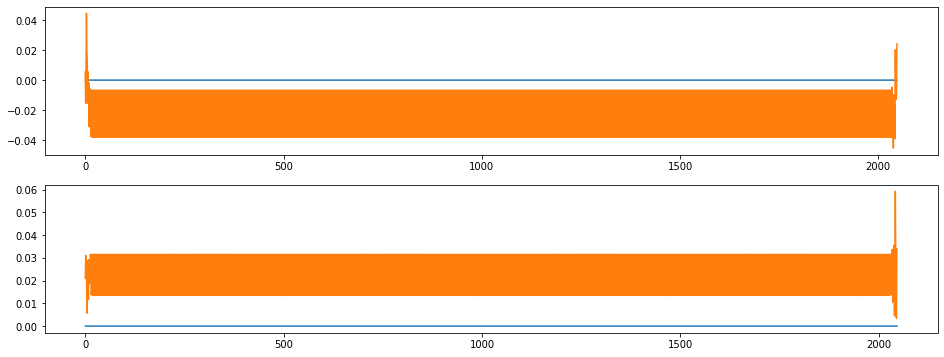

index:  257102
MAE:  0.019067612996423122
n_bunches       372
bunch_index     651
bunch_number    118
Name: 8924, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


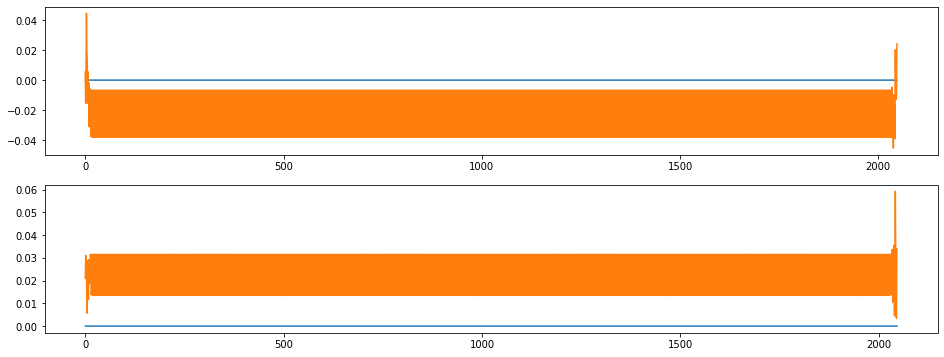

index:  156192
MAE:  0.019067612996423122
n_bunches       684
bunch_index     199
bunch_number     94
Name: 5408, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


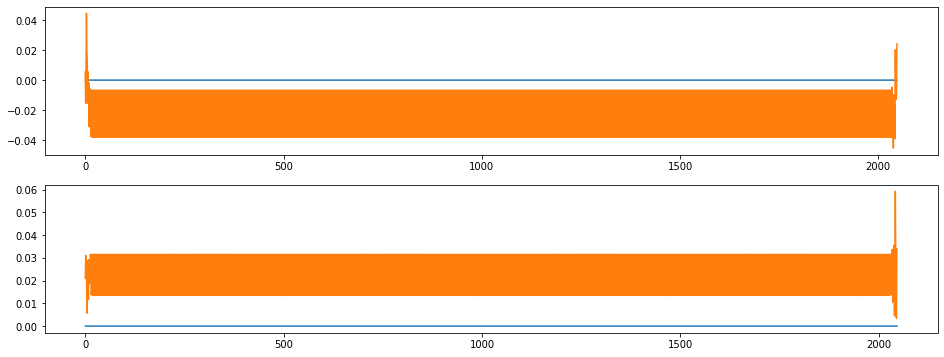

index:  215079
MAE:  0.019067612996423122
n_bunches       987
bunch_index     589
bunch_number    241
Name: 7469, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


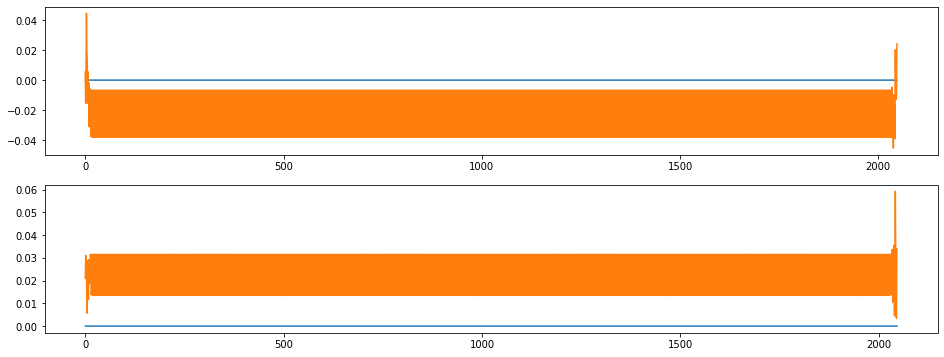

index:  106113
MAE:  0.019067612996423122
n_bunches       324
bunch_index     424
bunch_number     74
Name: 3684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7229/instability_data/07229_Inst_B1H_Q7_20180928_08h38m14s.h5


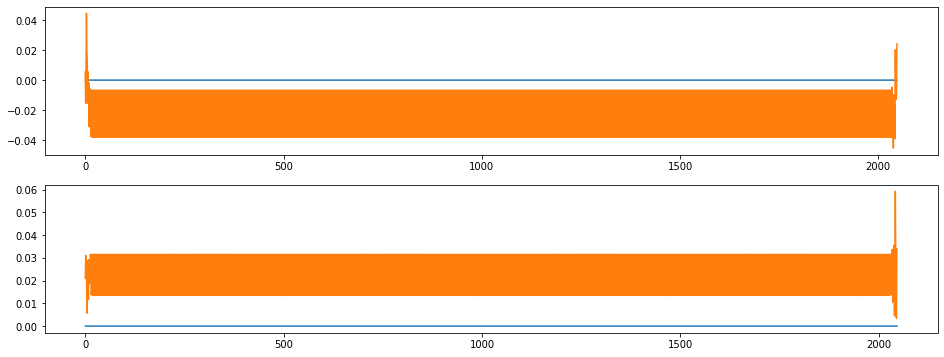

index:  275172
MAE:  0.019067612996423122
n_bunches       252
bunch_index     342
bunch_number    241
Name: 9570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


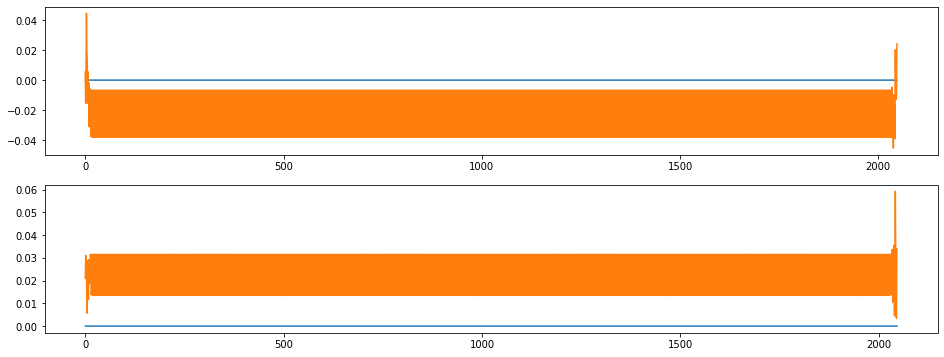

index:  243336
MAE:  0.019067612996423122
n_bunches       300
bunch_index     439
bunch_number    204
Name: 8445, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


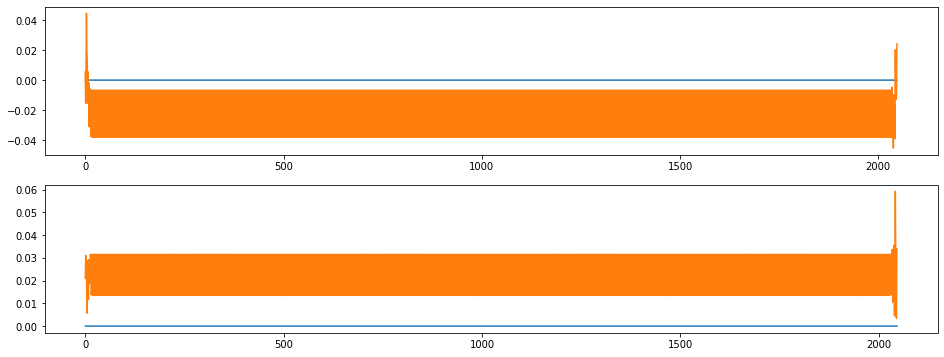

index:  232751
MAE:  0.019067612996423122
n_bunches        987
bunch_index     3141
bunch_number     860
Name: 8088, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


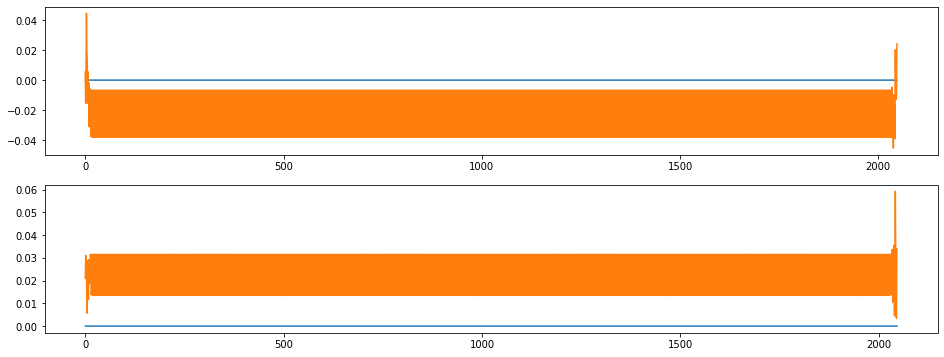

index:  313347
MAE:  0.019067612996423122
n_bunches        648
bunch_index     2291
bunch_number     428
Name: 10903, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


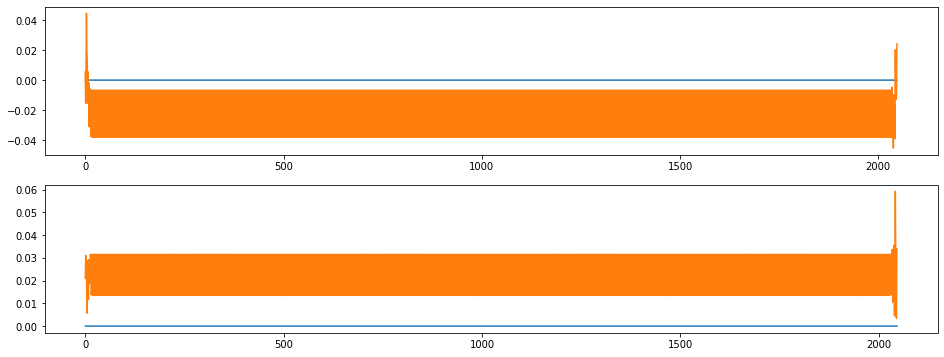

In [22]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [24]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  176690
MAE:  0.18577971783495845
n_bunches       1227
bunch_index      280
bunch_number     142
Name: 6140, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


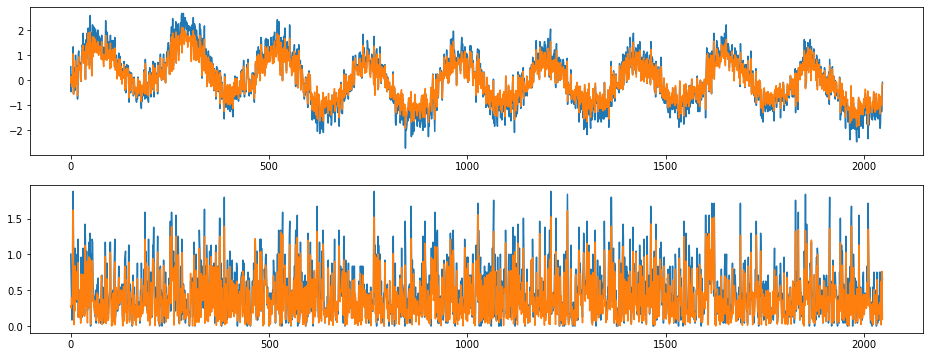

index:  349342
MAE:  0.18577972573248797
n_bunches       1358
bunch_index     2853
bunch_number    1034
Name: 12157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


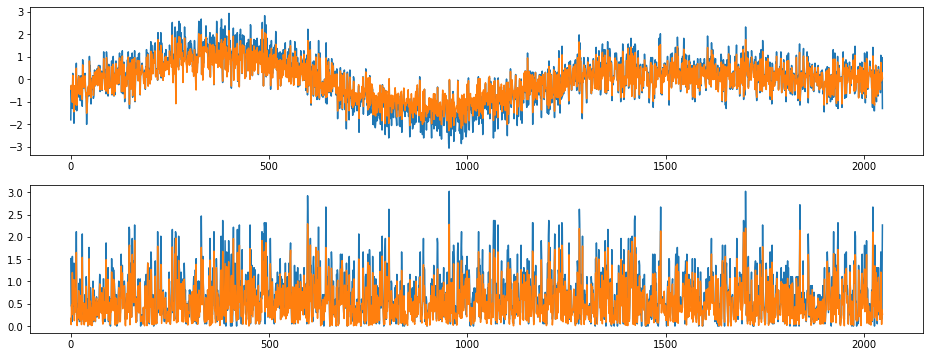

index:  161708
MAE:  0.18577972924236652
n_bunches       684
bunch_index     523
bunch_number    289
Name: 5603, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


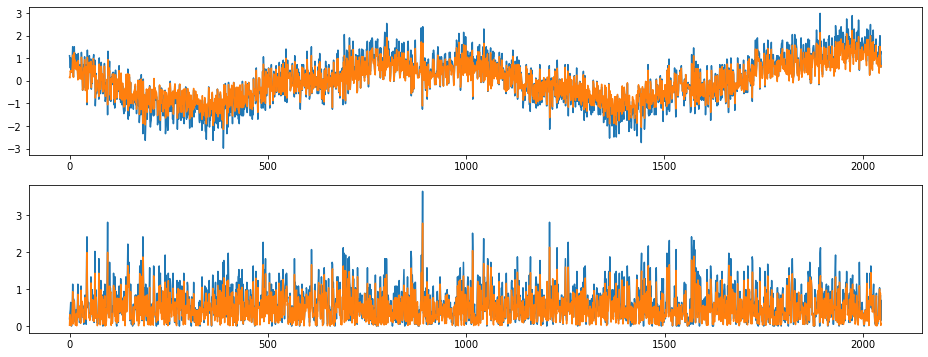

index:  230023
MAE:  0.18577976384349065
n_bunches        987
bunch_index     2877
bunch_number     766
Name: 7994, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


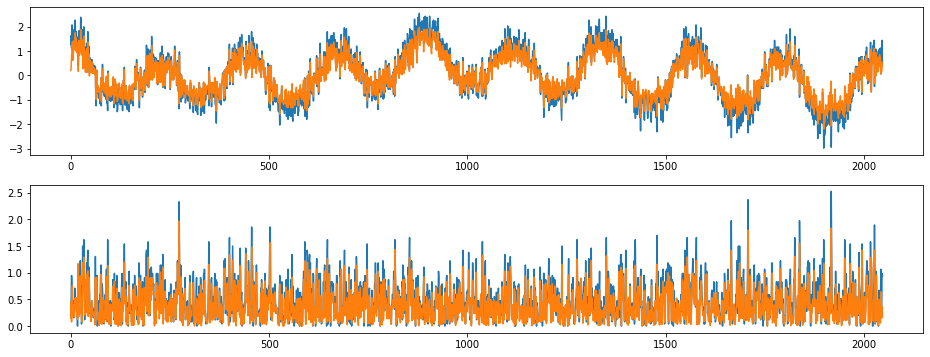

index:  193331
MAE:  0.1857797999217825
n_bunches       1227
bunch_index     2012
bunch_number     719
Name: 6717, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


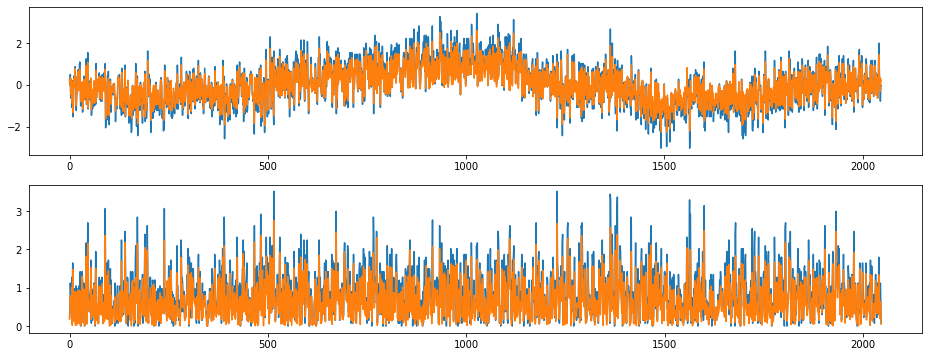

index:  258390
MAE:  0.18577953147105897
n_bunches       372
bunch_index     867
bunch_number    160
Name: 8966, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


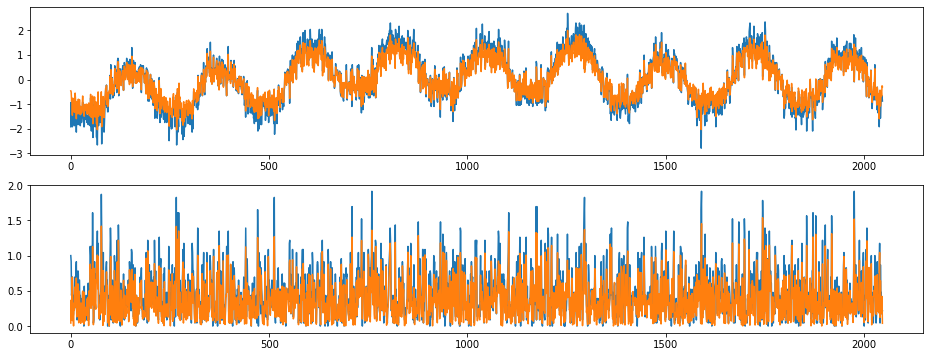

index:  59406
MAE:  0.1857798269872452
n_bunches       444
bunch_index     343
bunch_number    146
Name: 2064, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


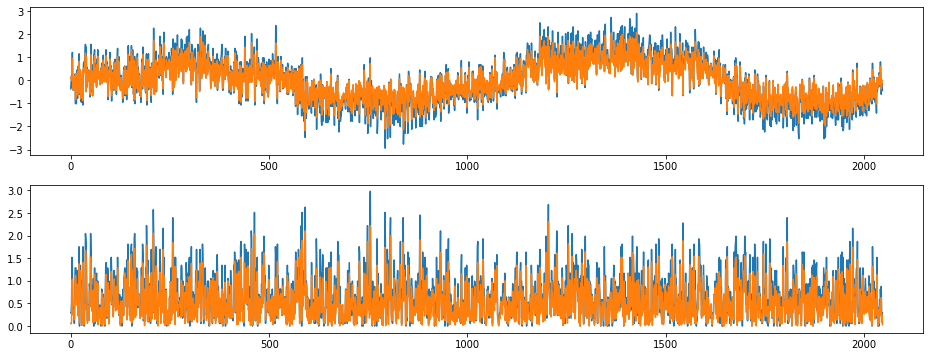

index:  242172
MAE:  0.18577951132626086
n_bunches       300
bunch_index     394
bunch_number    166
Name: 8407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


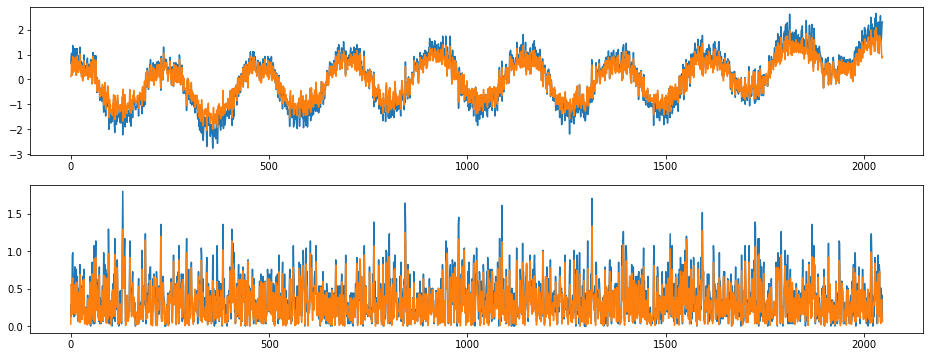

index:  231399
MAE:  0.18577949130149315
n_bunches        987
bunch_index     2933
bunch_number     815
Name: 8043, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


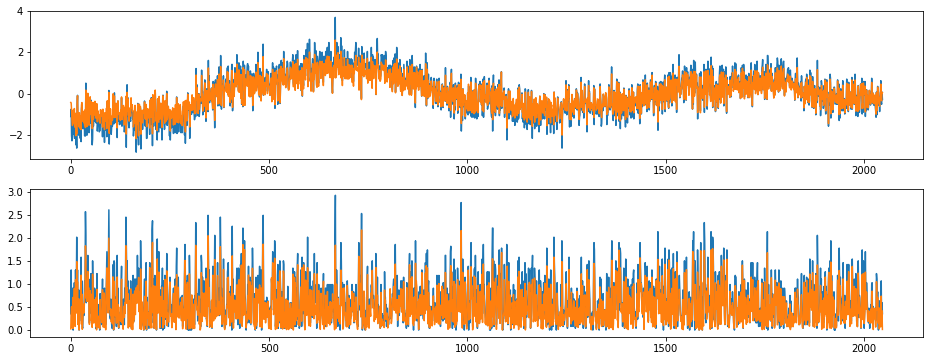

index:  150574
MAE:  0.18577993631870351
n_bunches       572
bunch_index     876
bunch_number    467
Name: 5209, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


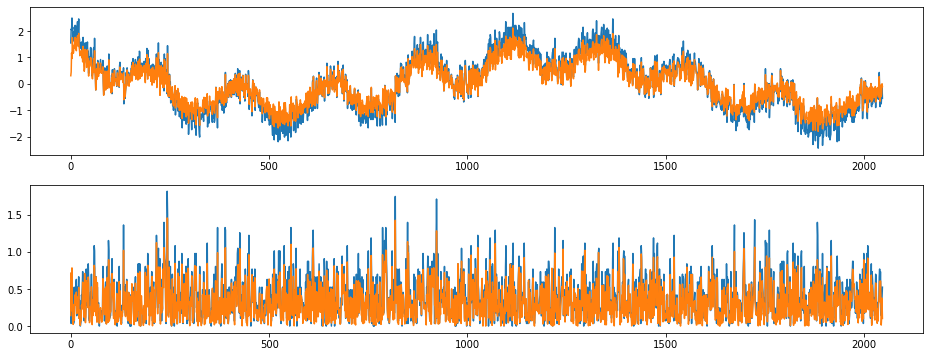

In [25]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around a point

In [26]:
around_cluster_indices = np.argsort(np.abs(MAE_train - 0.075))

index:  49459
MAE:  0.07421314104087608
n_bunches        733
bunch_index     2515
bunch_number     534
Name: 1719, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


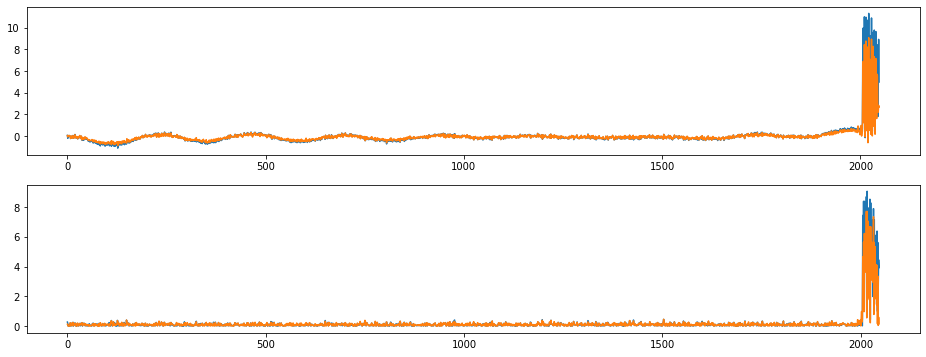

index:  125461
MAE:  0.07362107460869215
n_bunches       796
bunch_index     777
bunch_number    419
Name: 4353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


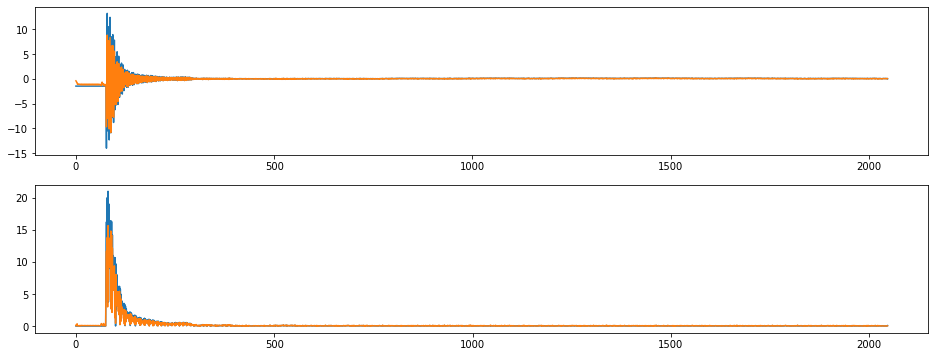

index:  409116
MAE:  0.0765136372203281
n_bunches        502
bunch_index     1418
bunch_number     300
Name: 14214, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


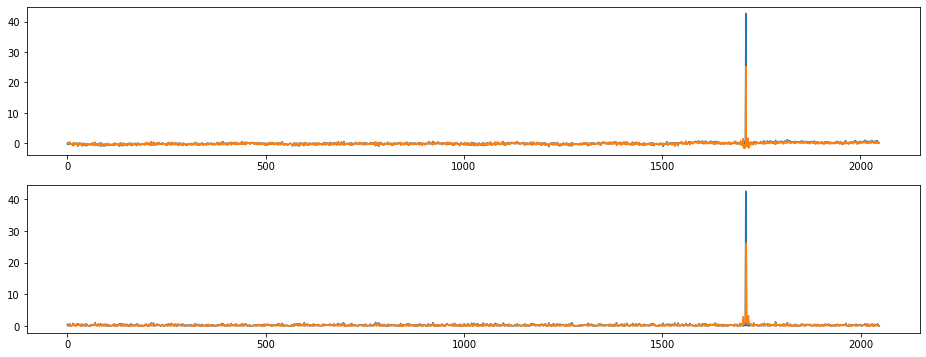

index:  407133
MAE:  0.07652674032267308
n_bunches        502
bunch_index     1072
bunch_number     226
Name: 14140, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


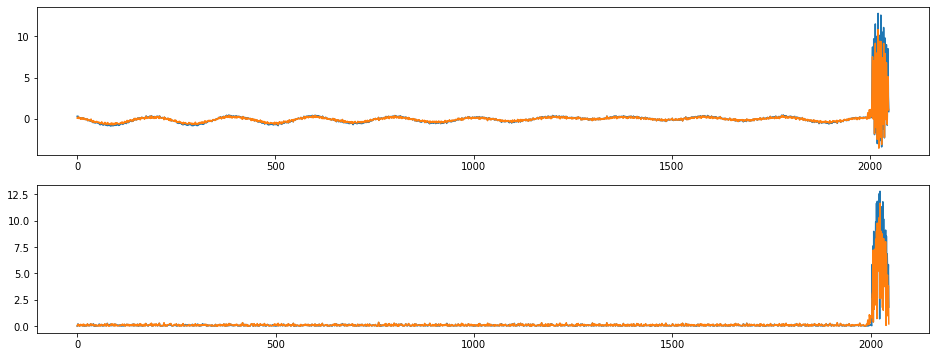

index:  395303
MAE:  0.07314983392022606
n_bunches       396
bunch_index     324
bunch_number    223
Name: 13733, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


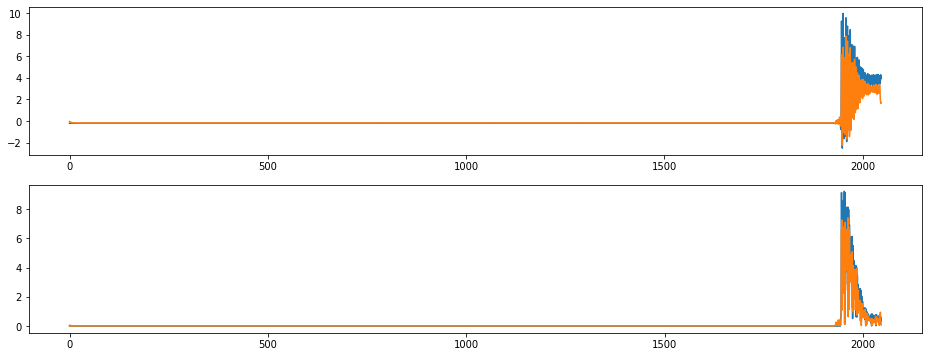

index:  44442
MAE:  0.07269599082054821
n_bunches        733
bunch_index     1712
bunch_number     359
Name: 1544, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


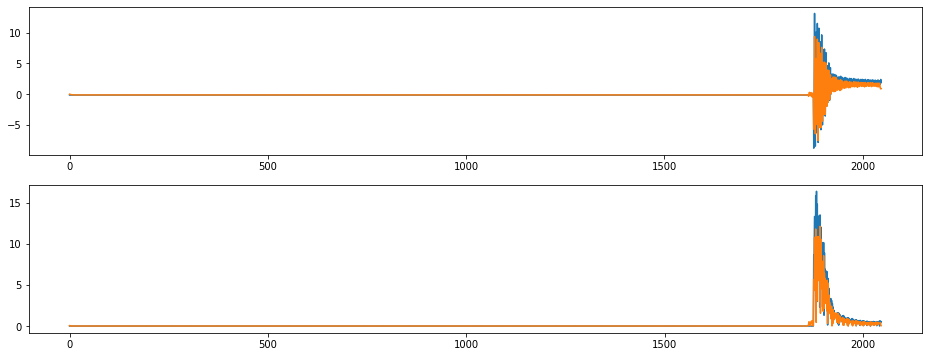

index:  346952
MAE:  0.0773486922085041
n_bunches       1358
bunch_index     2400
bunch_number     951
Name: 12074, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


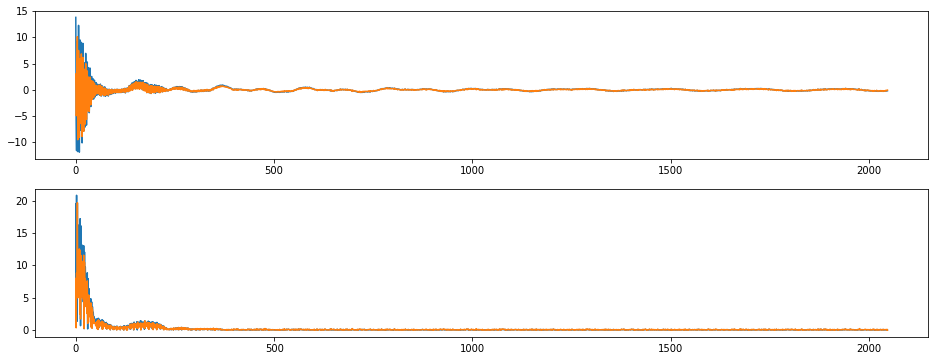

index:  340020
MAE:  0.07738218631288893
n_bunches       1358
bunch_index     1970
bunch_number     705
Name: 11828, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


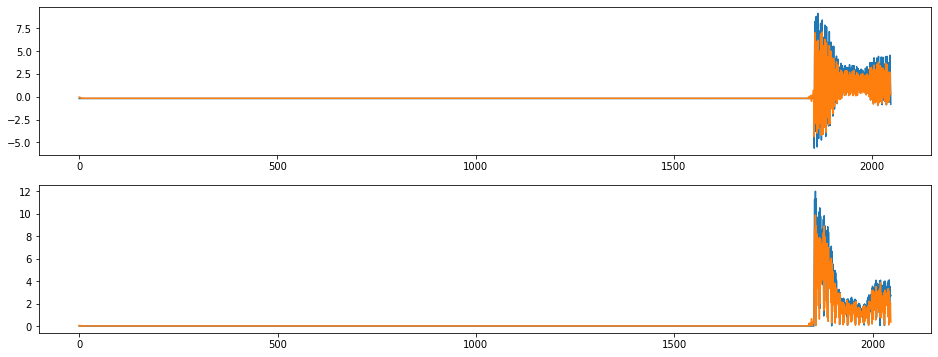

index:  274519
MAE:  0.07755026549142296
n_bunches       252
bunch_index     319
bunch_number    218
Name: 9547, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


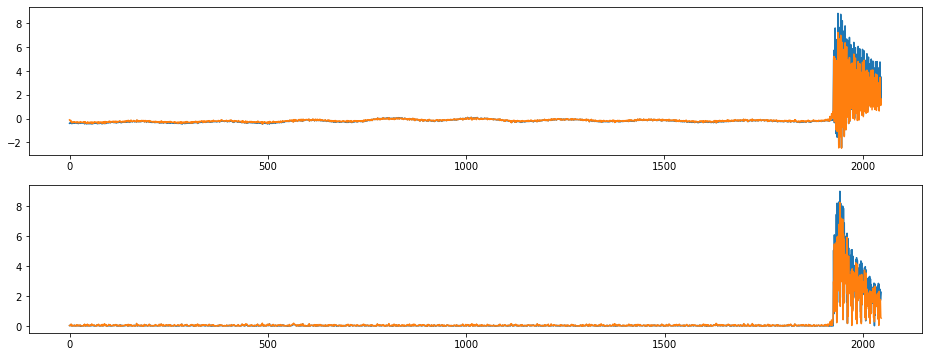

index:  179311
MAE:  0.07242446373593735
n_bunches       1227
bunch_index      509
bunch_number     228
Name: 6226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


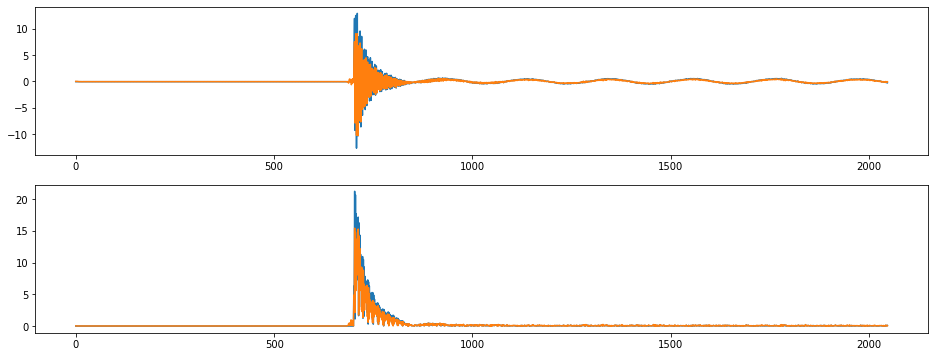

index:  32058
MAE:  0.07799103563157125
n_bunches        972
bunch_index     1709
bunch_number     900
Name: 1113, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


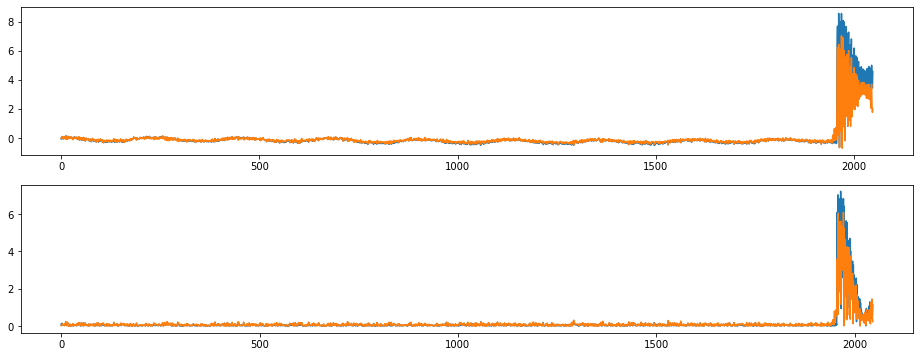

index:  386682
MAE:  0.07114422857247837
n_bunches       636
bunch_index     778
bunch_number    552
Name: 13426, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


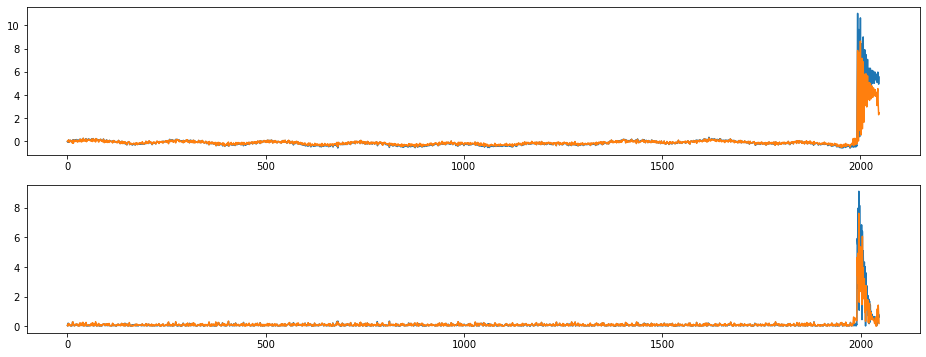

index:  123087
MAE:  0.0801408966681844
n_bunches       796
bunch_index     621
bunch_number    336
Name: 4270, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


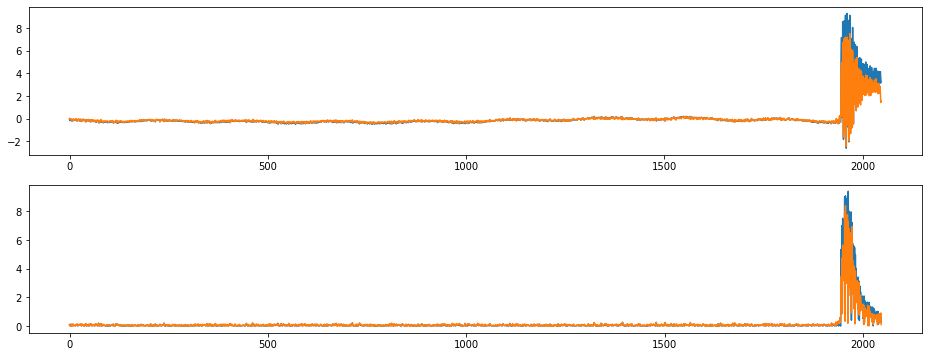

index:  384913
MAE:  0.08030012950093533
n_bunches       636
bunch_index     685
bunch_number    494
Name: 13368, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


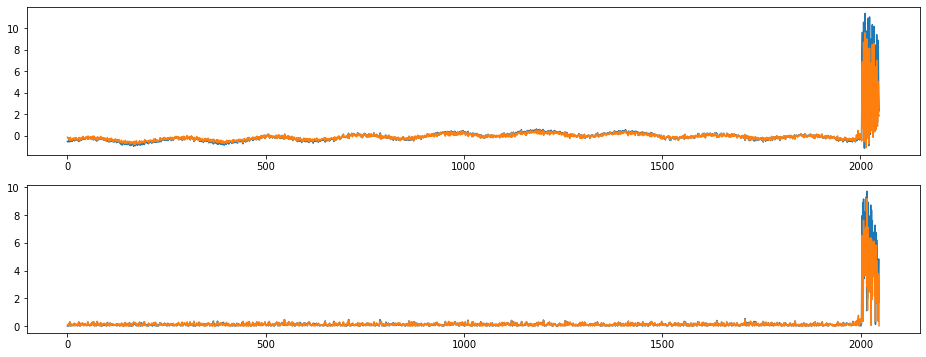

index:  383026
MAE:  0.08039312944827023
n_bunches       636
bunch_index     605
bunch_number    428
Name: 13302, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


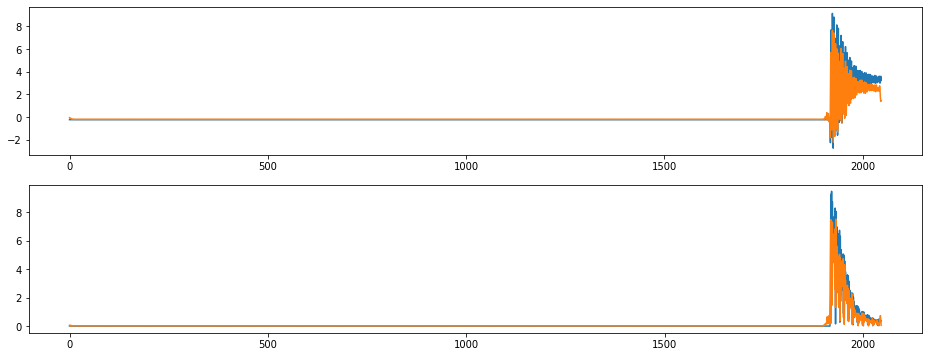

index:  351197
MAE:  0.081340917675456
n_bunches       1358
bunch_index     2950
bunch_number    1096
Name: 12219, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


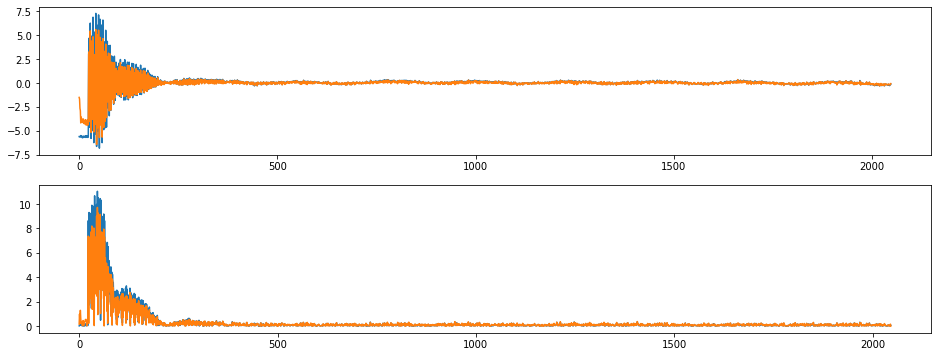

index:  339864
MAE:  0.06786408568959107
n_bunches       1358
bunch_index     1960
bunch_number     699
Name: 11822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


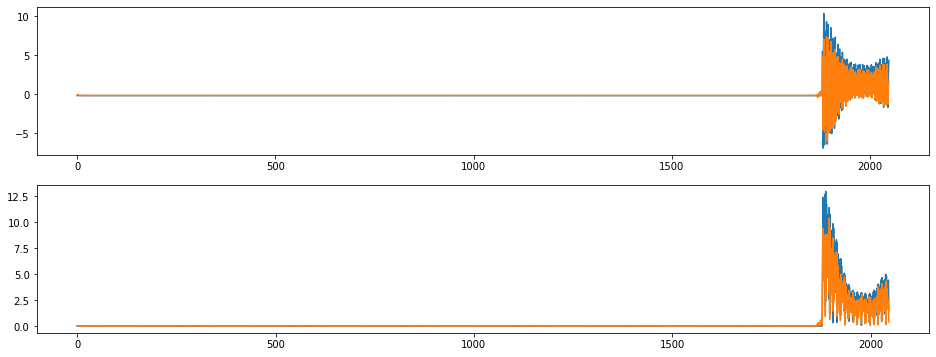

index:  372345
MAE:  0.08217559337245581
n_bunches       636
bunch_index     118
bunch_number     62
Name: 12936, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


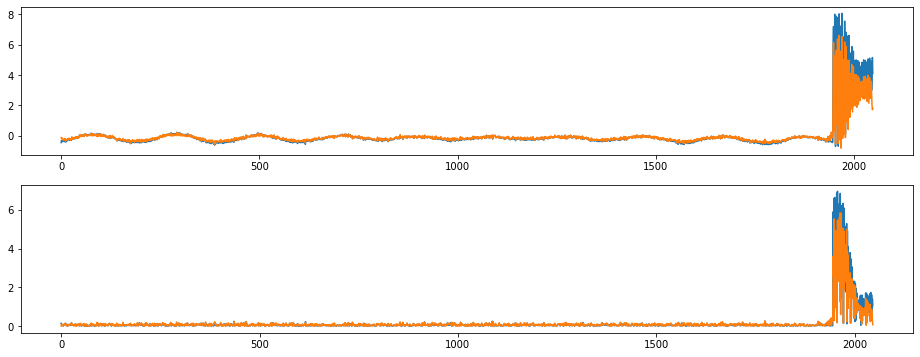

index:  311335
MAE:  0.0823136449244388
n_bunches        648
bunch_index     1923
bunch_number     358
Name: 10833, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


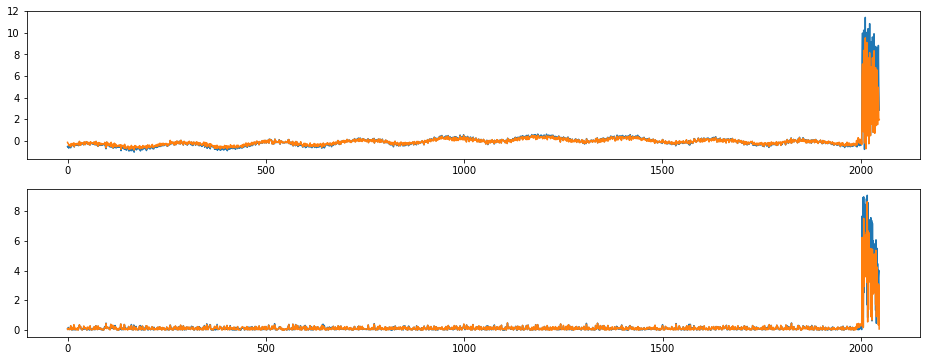

index:  191111
MAE:  0.08249591991115027
n_bunches       1227
bunch_index     1675
bunch_number     646
Name: 6644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


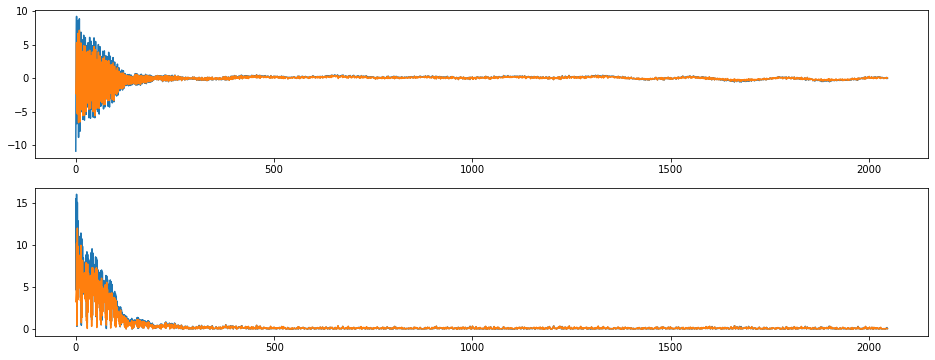

index:  197046
MAE:  0.08361430774692048
n_bunches       1227
bunch_index     2290
bunch_number     847
Name: 6845, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


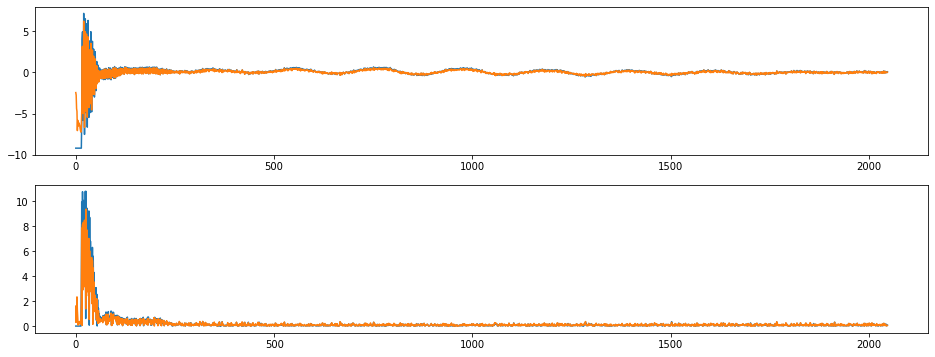

index:  38417
MAE:  0.06612314811943565
n_bunches       733
bunch_index     691
bunch_number    145
Name: 1330, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


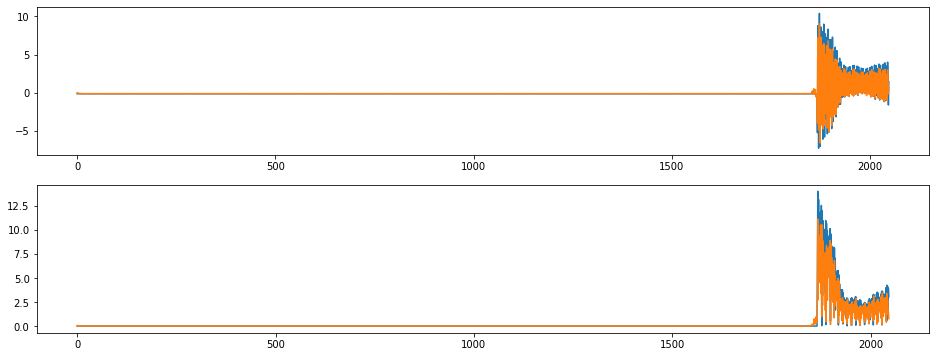

index:  210131
MAE:  0.08414397412520638
n_bunches       987
bunch_index     235
bunch_number     71
Name: 7299, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


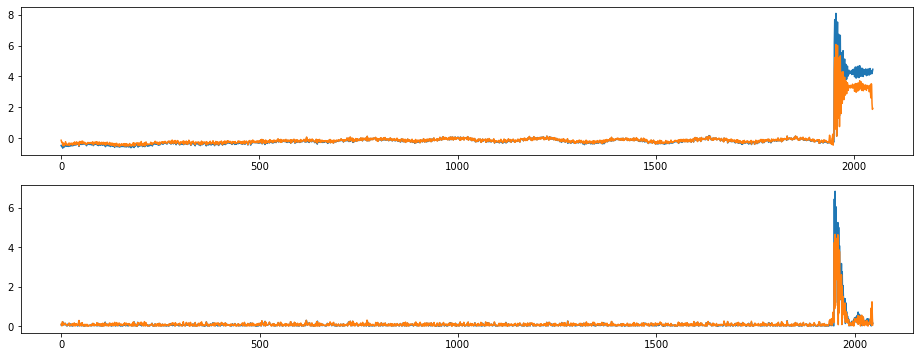

index:  184555
MAE:  0.06576198497591926
n_bunches       1227
bunch_index     1161
bunch_number     418
Name: 6416, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


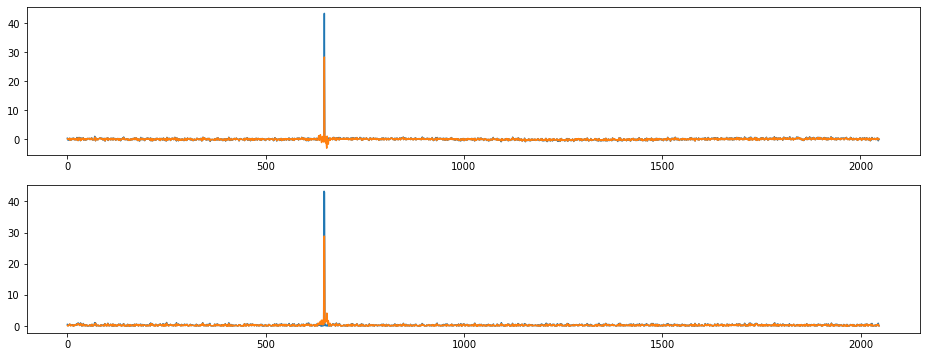

index:  217723
MAE:  0.06529449781187921
n_bunches        987
bunch_index     1146
bunch_number     334
Name: 7562, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


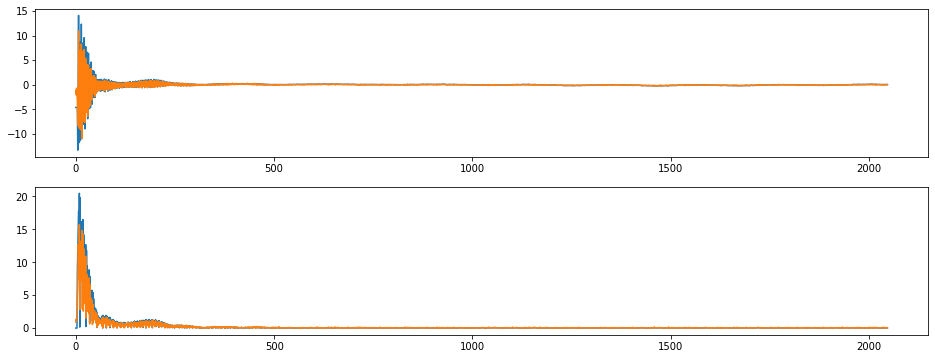

index:  64948
MAE:  0.06472884915157678
n_bunches       444
bunch_index     610
bunch_number    337
Name: 2255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


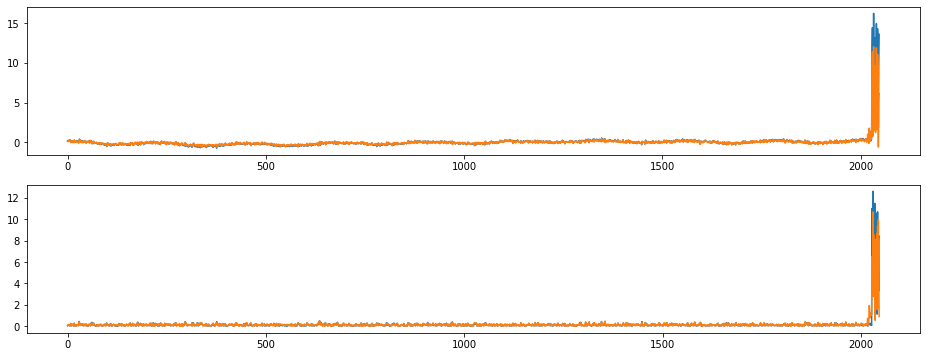

index:  91246
MAE:  0.0854863797378956
n_bunches       418
bunch_index     491
bunch_number    102
Name: 3172, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h48m56s.h5


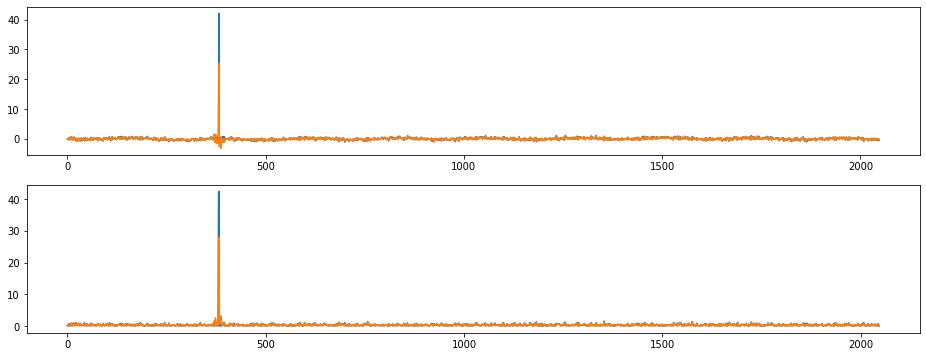

index:  303171
MAE:  0.06443414723520527
n_bunches       648
bunch_index     441
bunch_number     77
Name: 10552, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


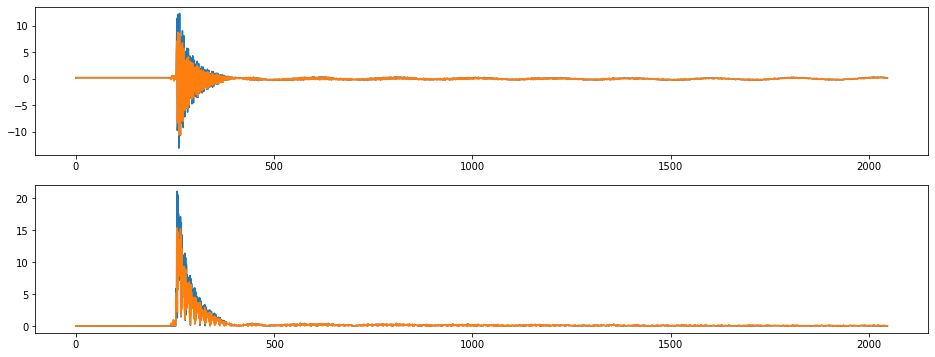

index:  113510
MAE:  0.08675149207871262
n_bunches       796
bunch_index       9
bunch_number      2
Name: 3936, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


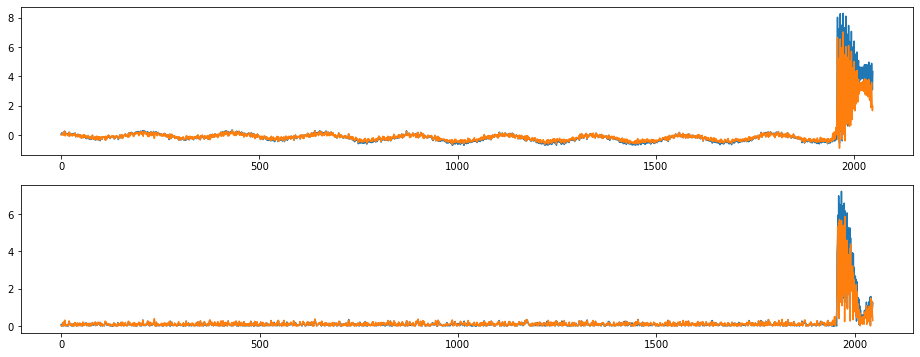

index:  310576
MAE:  0.08753543492027671
n_bunches        648
bunch_index     1779
bunch_number     332
Name: 10807, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


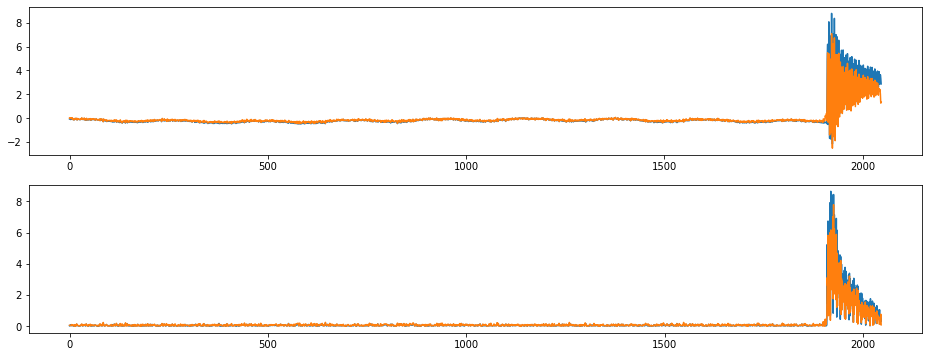

index:  145412
MAE:  0.08796478001552707
n_bunches       572
bunch_index     521
bunch_number    287
Name: 5029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


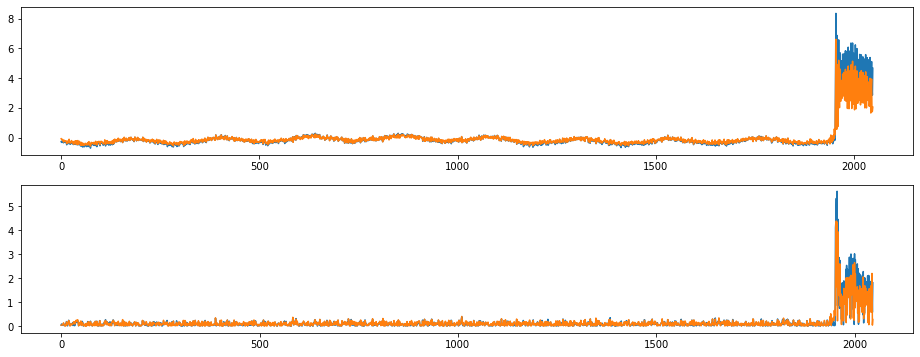

index:  43242
MAE:  0.08870181632253314
n_bunches        733
bunch_index     1522
bunch_number     319
Name: 1504, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


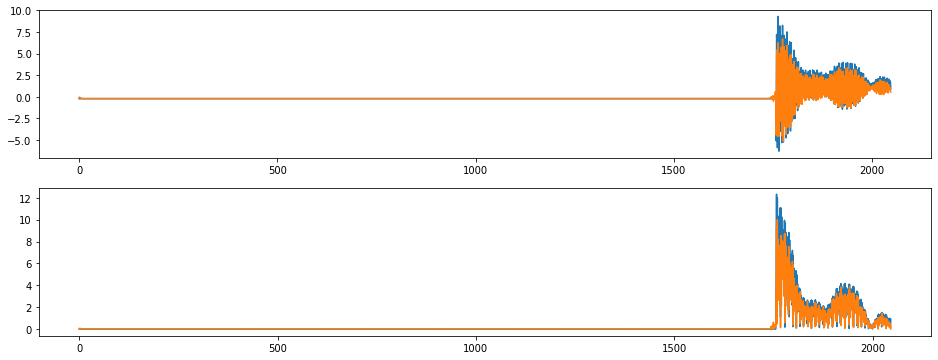

index:  170636
MAE:  0.08902900844647502
n_bunches        684
bunch_index     1115
bunch_number     604
Name: 5918, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


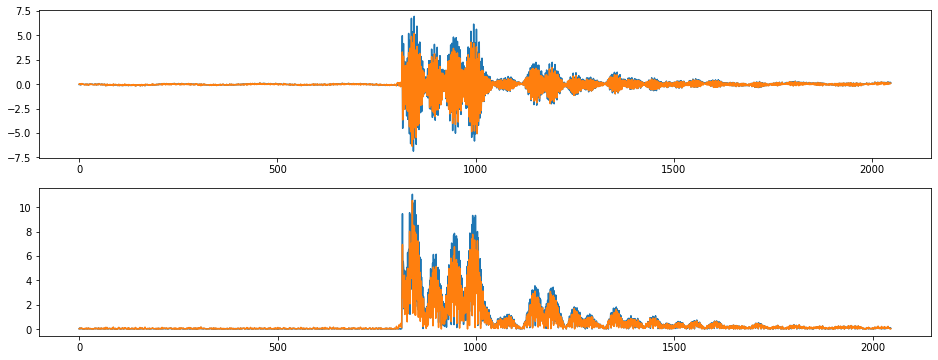

index:  204076
MAE:  0.08911088800652192
n_bunches       1227
bunch_index     3133
bunch_number    1092
Name: 7090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


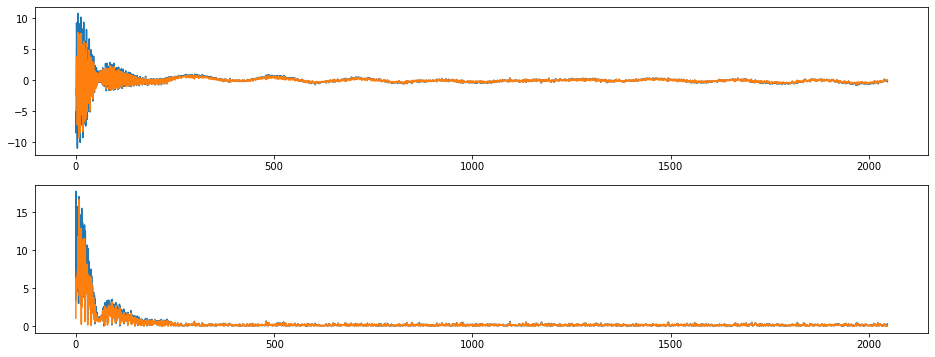

index:  397119
MAE:  0.08918468389175938
n_bunches       396
bunch_index     416
bunch_number    284
Name: 13794, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


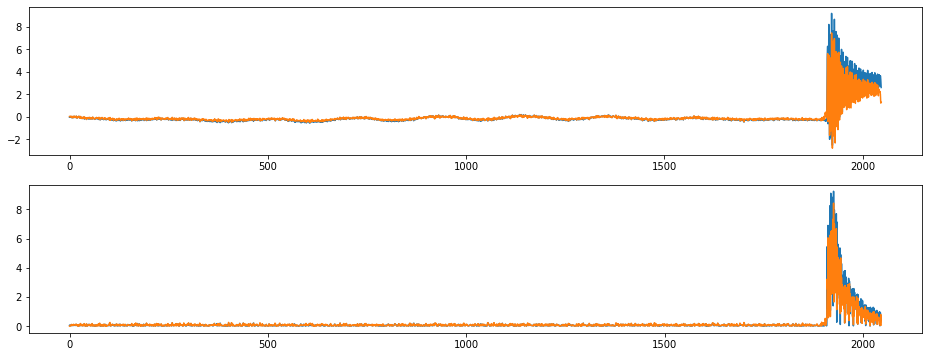

index:  271510
MAE:  0.09341122206081956
n_bunches       252
bunch_index     201
bunch_number    114
Name: 9443, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


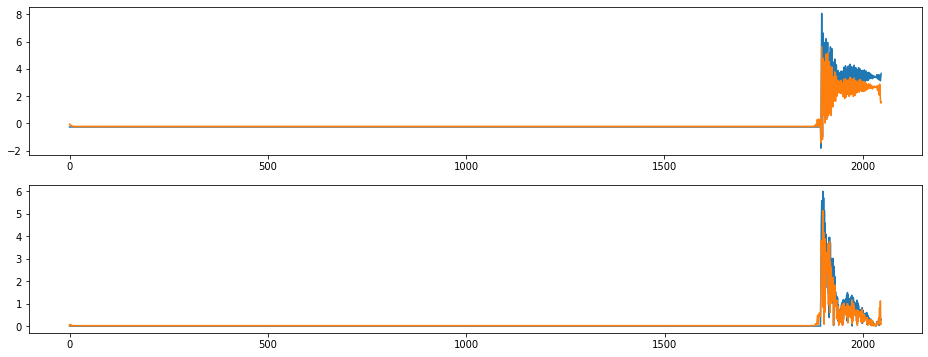

index:  232827
MAE:  0.09383857096531117
n_bunches        987
bunch_index     3143
bunch_number     862
Name: 8090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


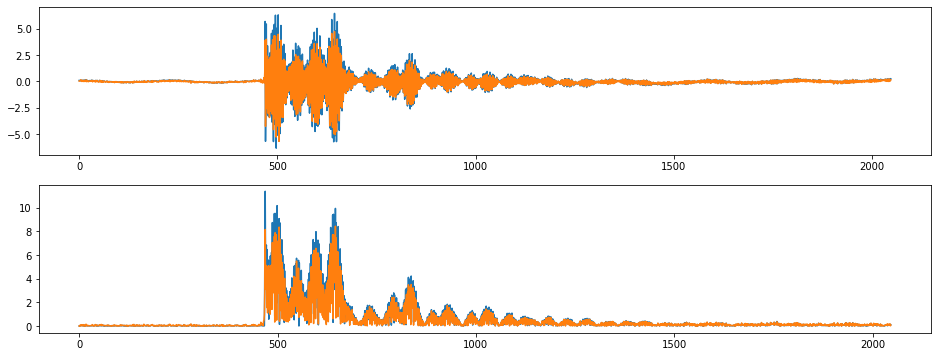

index:  521
MAE:  0.09409289527864764
n_bunches         20
bunch_index     2804
bunch_number      17
Name: 18, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/instability_data/07478_Inst_B1H_Q7_20181127_14h49m16s.h5


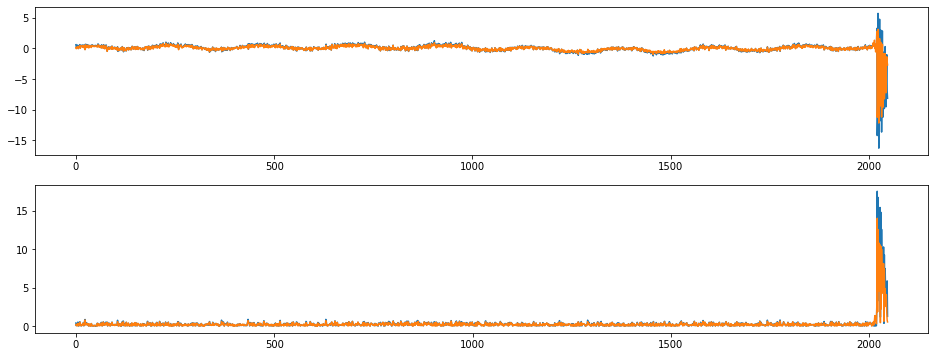

index:  259496
MAE:  0.09439116513546056
n_bunches        372
bunch_index     1072
bunch_number     199
Name: 9005, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


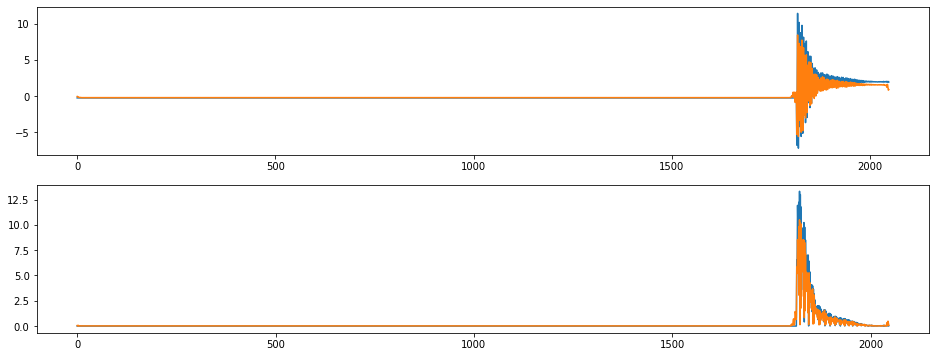

index:  69354
MAE:  0.09442837654618691
n_bunches       252
bunch_index      94
bunch_number     45
Name: 2407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7223/instability_data/07223_Inst_B1H_Q7_20180927_17h56m01s.h5


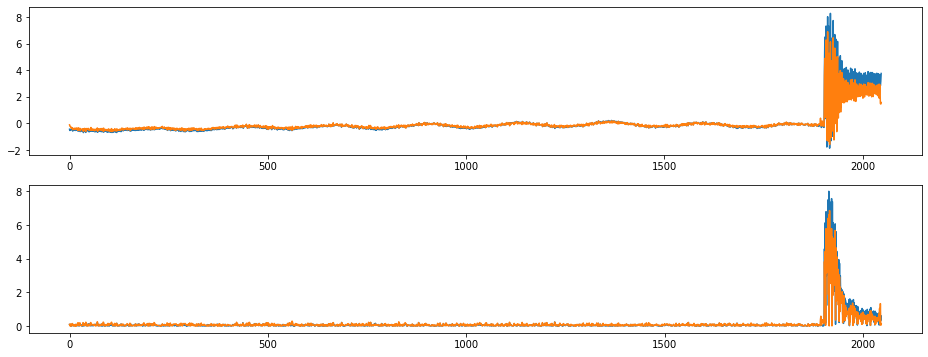

index:  193777
MAE:  0.05414314389095605
n_bunches       1227
bunch_index     2027
bunch_number     734
Name: 6732, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


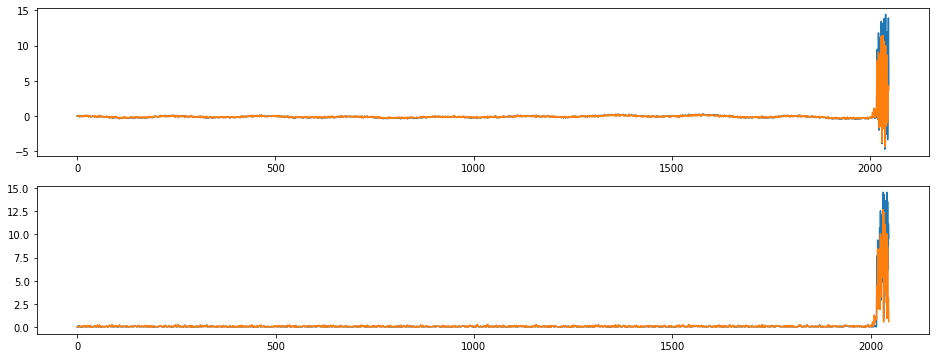

index:  154462
MAE:  0.0968810646802647
n_bunches       684
bunch_index      74
bunch_number     28
Name: 5342, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


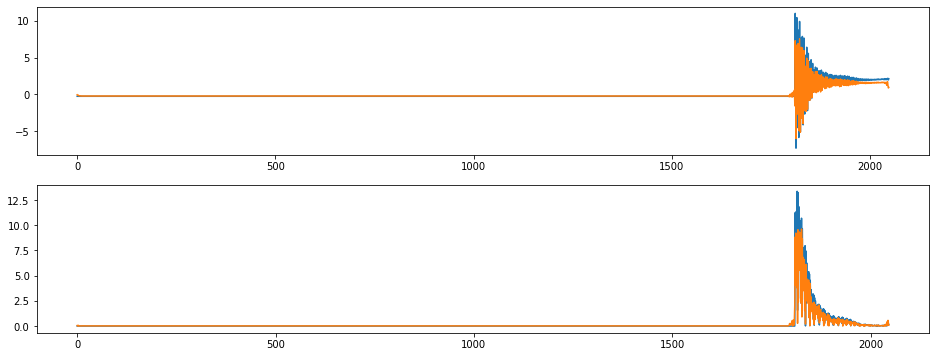

index:  35406
MAE:  0.09741047269325266
n_bunches       733
bunch_index     231
bunch_number     43
Name: 1228, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


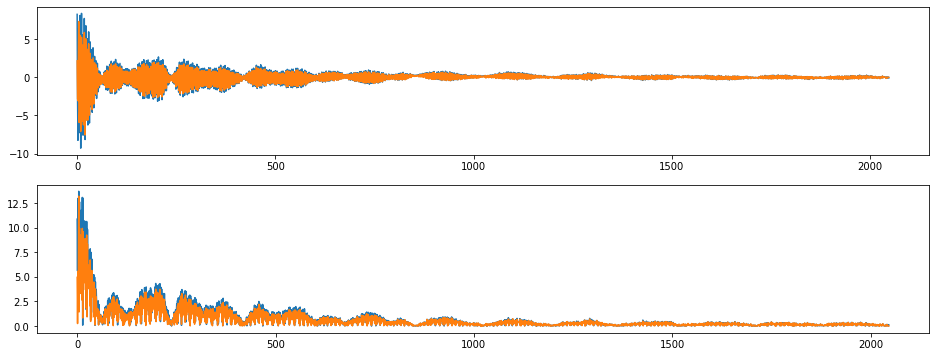

index:  38076
MAE:  0.09800405080161007
n_bunches       733
bunch_index     637
bunch_number    132
Name: 1317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


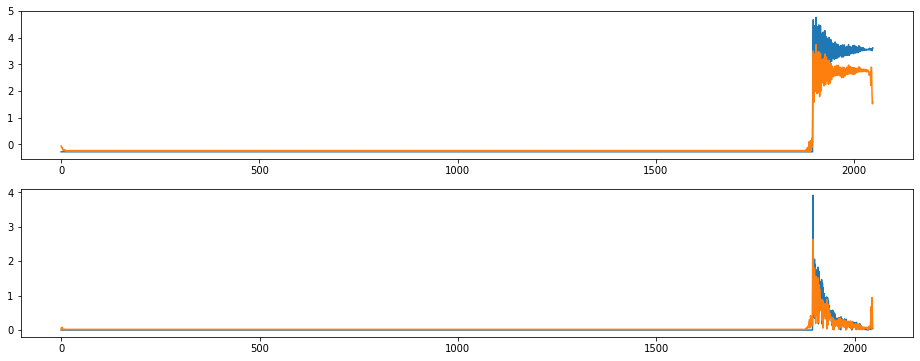

index:  198803
MAE:  0.09818743318211415
n_bunches       1227
bunch_index     2363
bunch_number     913
Name: 6911, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


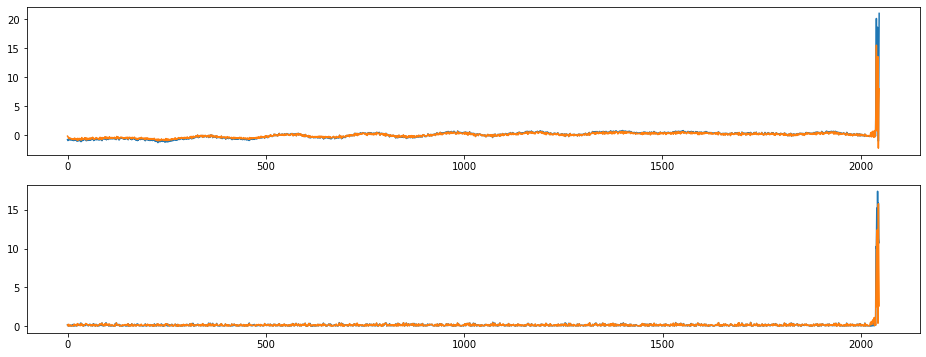

index:  65137
MAE:  0.09896551845472883
n_bunches       444
bunch_index     616
bunch_number    343
Name: 2261, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


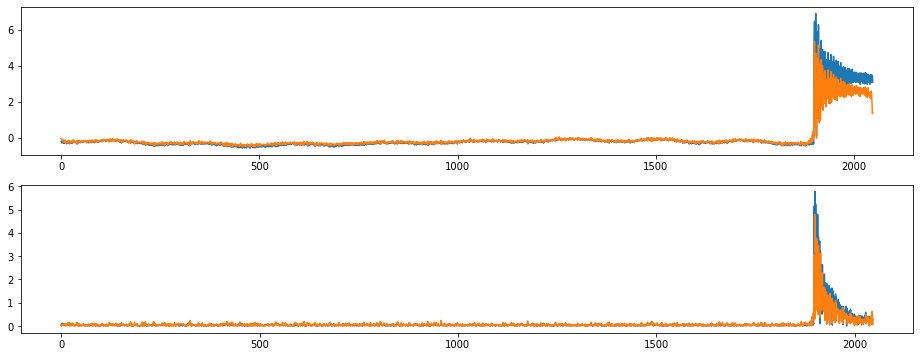

index:  154206
MAE:  0.09920811691676788
n_bunches       684
bunch_index      56
bunch_number     18
Name: 5332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


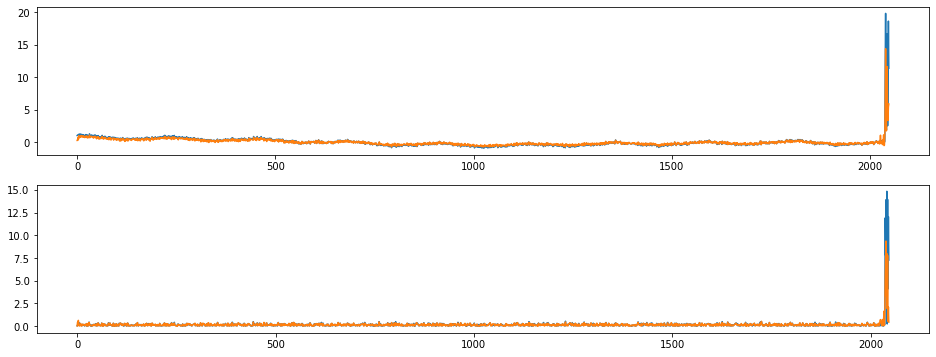

index:  41408
MAE:  0.09939306861235744
n_bunches        733
bunch_index     1224
bunch_number     258
Name: 1443, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


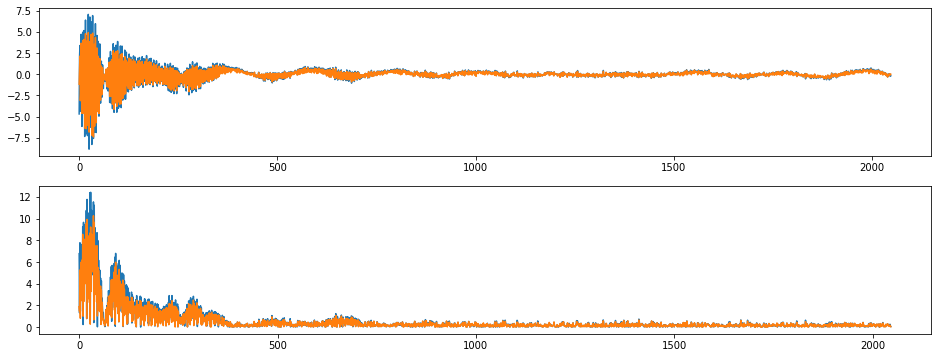

index:  42503
MAE:  0.09940926614390029
n_bunches        733
bunch_index     1394
bunch_number     294
Name: 1479, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


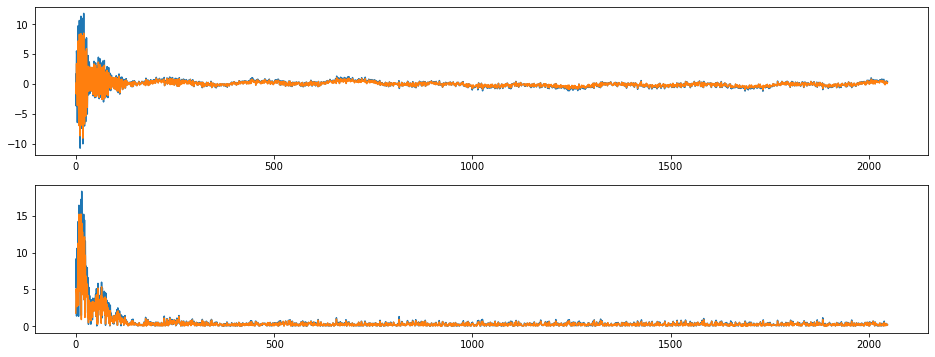

index:  372092
MAE:  0.10057448593451822
n_bunches       636
bunch_index     101
bunch_number     52
Name: 12926, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


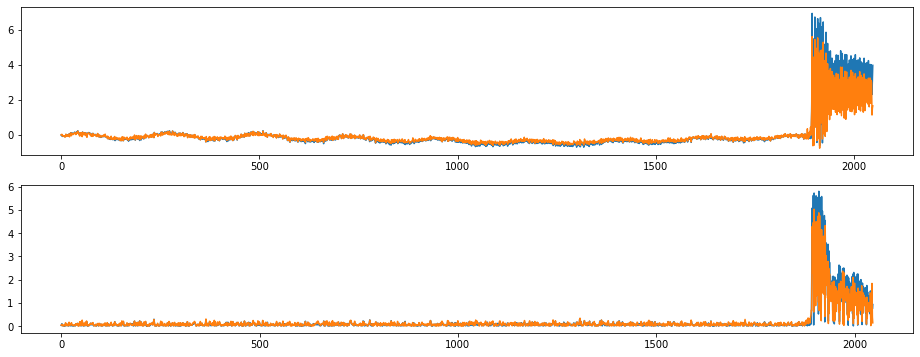

index:  405347
MAE:  0.10137684568486967
n_bunches       502
bunch_index     806
bunch_number    166
Name: 14080, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


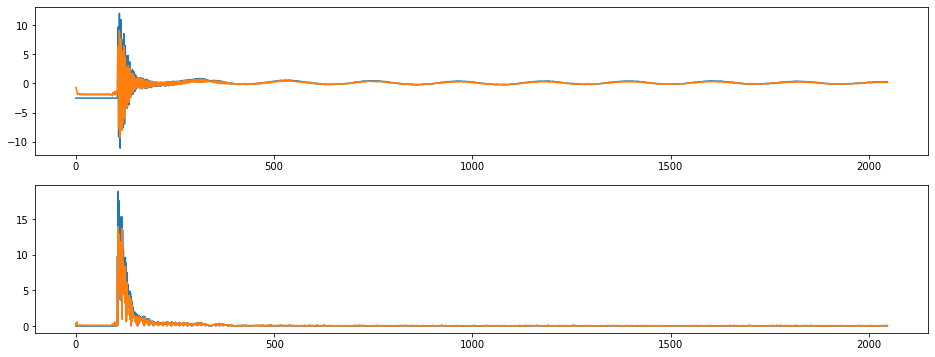

index:  241467
MAE:  0.10212746112975576
n_bunches       300
bunch_index     339
bunch_number    142
Name: 8383, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


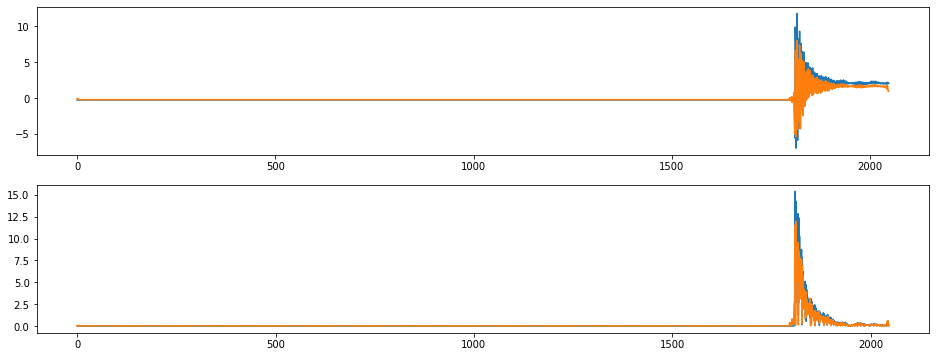

index:  233191
MAE:  0.1027022192589902
n_bunches        987
bunch_index     3156
bunch_number     875
Name: 8103, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


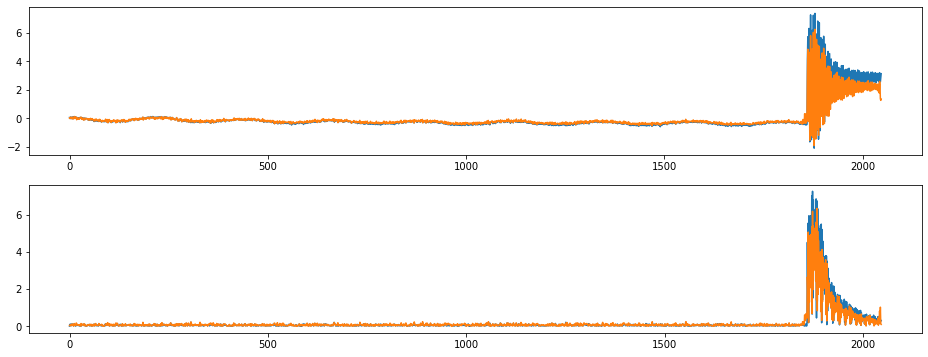

index:  313057
MAE:  0.10282635283119586
n_bunches        648
bunch_index     2245
bunch_number     418
Name: 10893, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


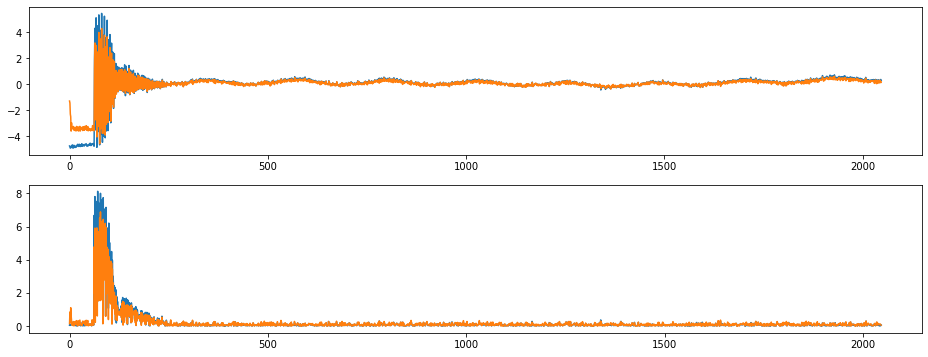

index:  337900
MAE:  0.10330222863513056
n_bunches       1358
bunch_index     1536
bunch_number     633
Name: 11756, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


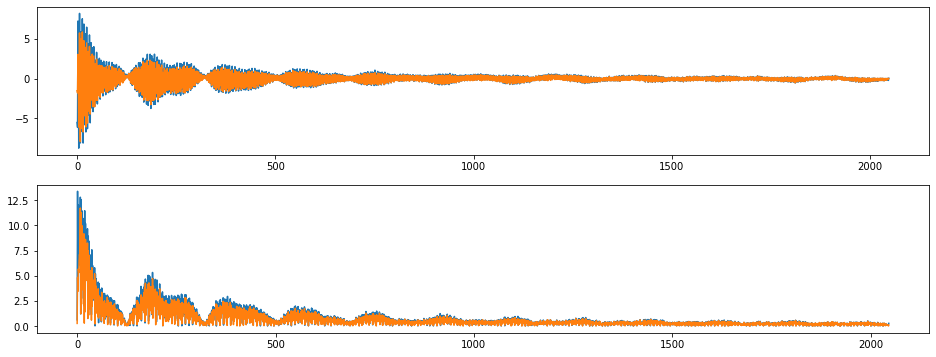

index:  398531
MAE:  0.10430242273036938
n_bunches       396
bunch_index     473
bunch_number    334
Name: 13844, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


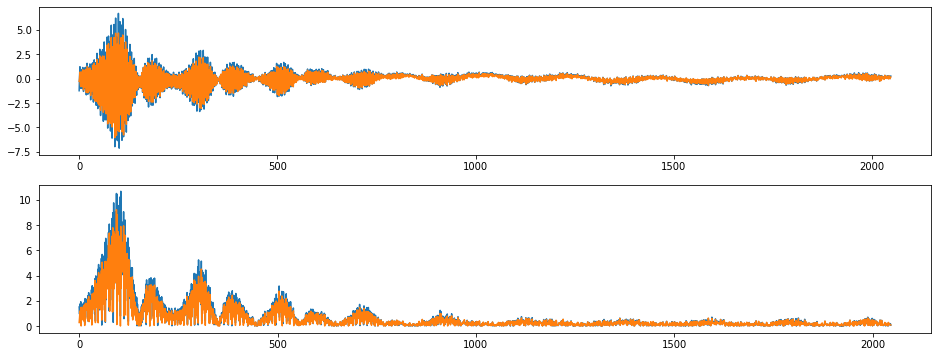

index:  152573
MAE:  0.10460221438734489
n_bunches       572
bunch_index     985
bunch_number    537
Name: 5279, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


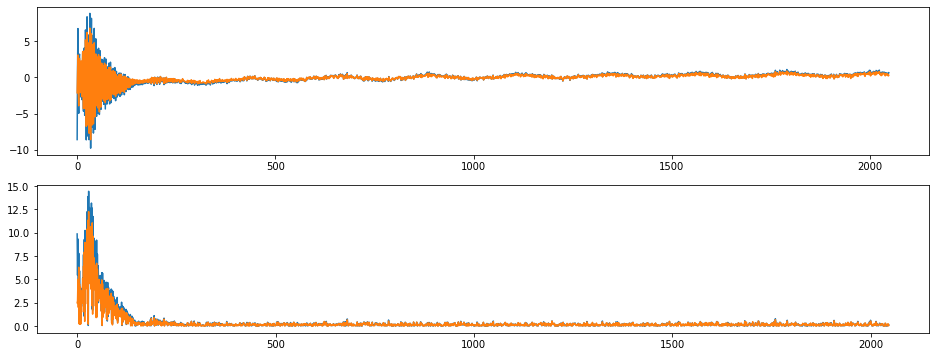

index:  296715
MAE:  0.10492091722630963
n_bunches       158
bunch_index     211
bunch_number     13
Name: 10330, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7343/instability_data/07343_Inst_B1H_Q7_20181025_05h31m18s.h5


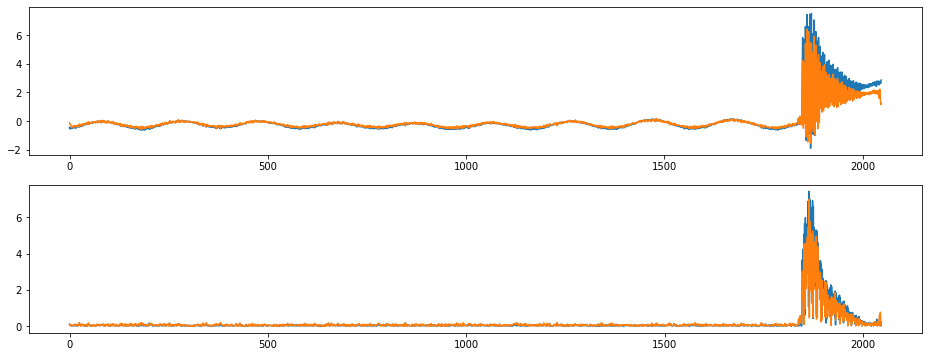

index:  149724
MAE:  0.10528305586327368
n_bunches       572
bunch_index     808
bunch_number    438
Name: 5180, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


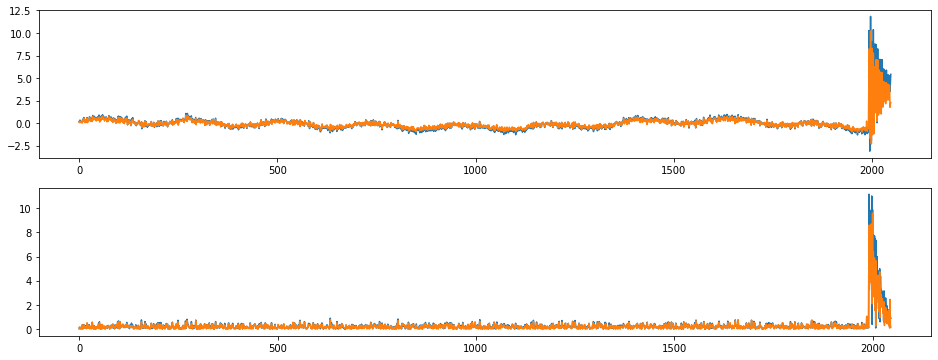

index:  104473
MAE:  0.10530397812067314
n_bunches       324
bunch_index      55
bunch_number     19
Name: 3629, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7229/instability_data/07229_Inst_B1H_Q7_20180928_08h38m14s.h5


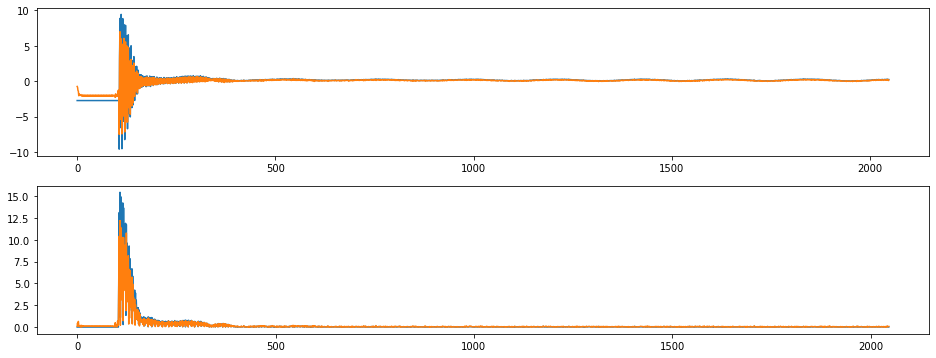

index:  319436
MAE:  0.10540096545398514
n_bunches        648
bunch_index     3370
bunch_number     632
Name: 11107, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


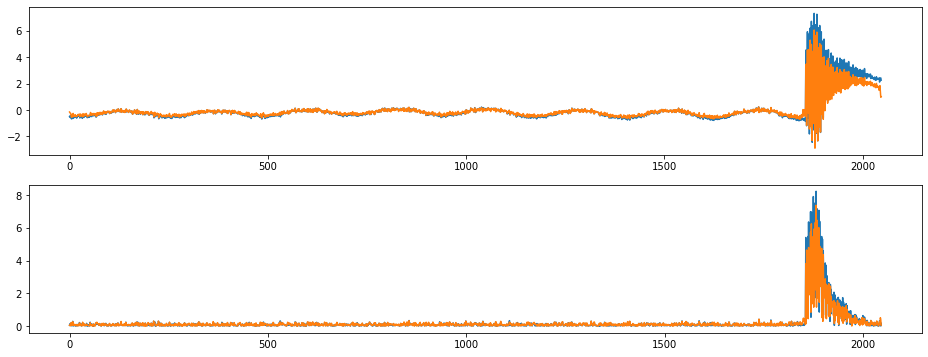

index:  71106
MAE:  0.10562120938892007
n_bunches       252
bunch_index     196
bunch_number    109
Name: 2471, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7223/instability_data/07223_Inst_B1H_Q7_20180927_17h56m01s.h5


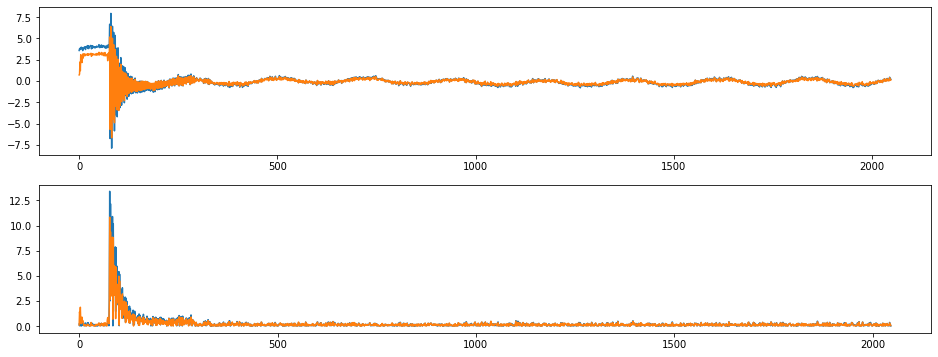

index:  306013
MAE:  0.044321461855405274
n_bunches       648
bunch_index     956
bunch_number    173
Name: 10648, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


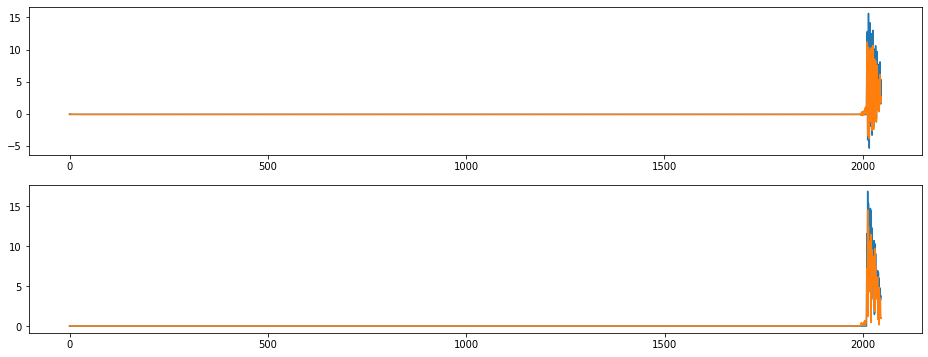

index:  227090
MAE:  0.04417408509978128
n_bunches        987
bunch_index     2298
bunch_number     663
Name: 7891, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


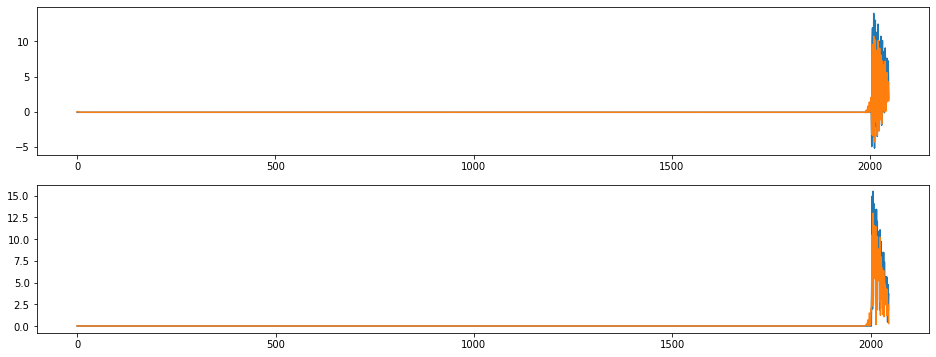

index:  96558
MAE:  0.10622754692719659
n_bunches        418
bunch_index     1367
bunch_number     287
Name: 3357, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h48m56s.h5


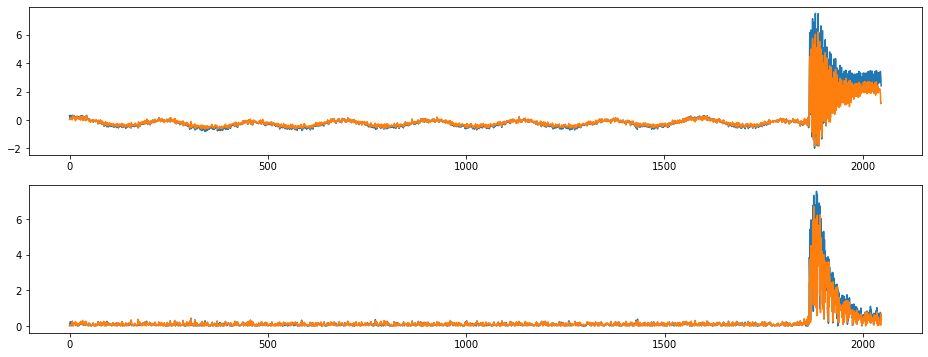

index:  342579
MAE:  0.10712764051241652
n_bunches       1358
bunch_index     2105
bunch_number     793
Name: 11916, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


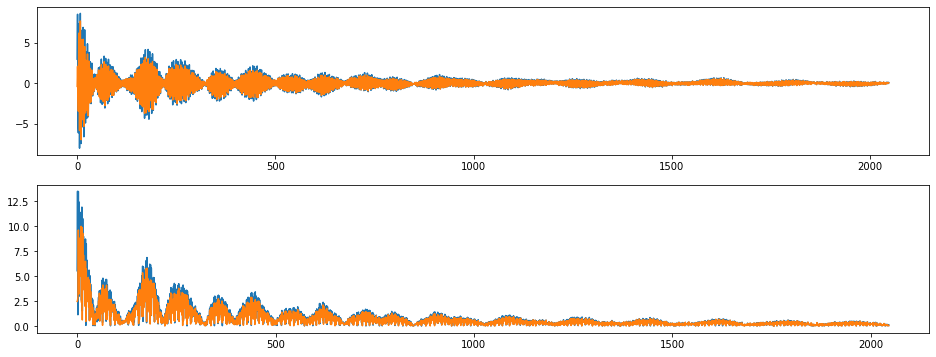

index:  334288
MAE:  0.10785630733445352
n_bunches       1358
bunch_index     1312
bunch_number     506
Name: 11629, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


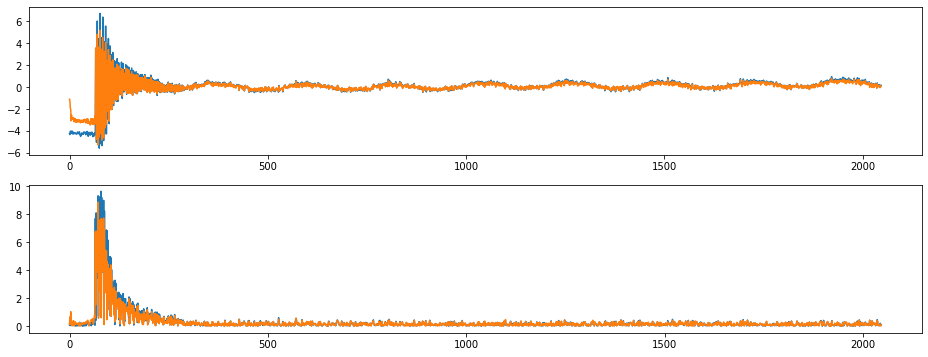

index:  41854
MAE:  0.10790472152355017
n_bunches        733
bunch_index     1304
bunch_number     271
Name: 1456, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


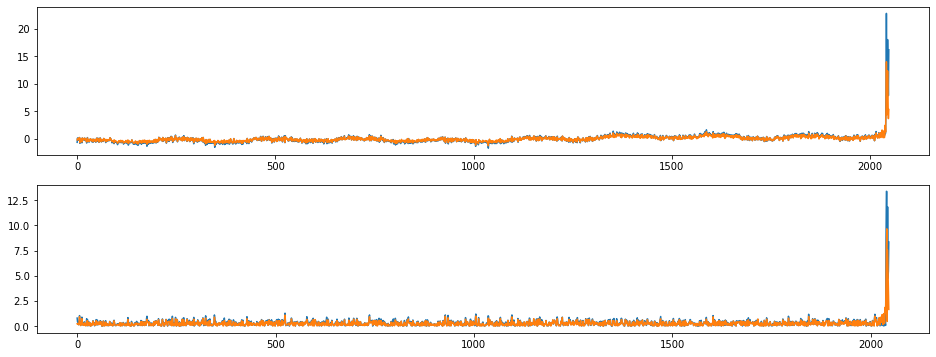

index:  351326
MAE:  0.10808461070585113
n_bunches       1358
bunch_index     2954
bunch_number    1100
Name: 12223, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


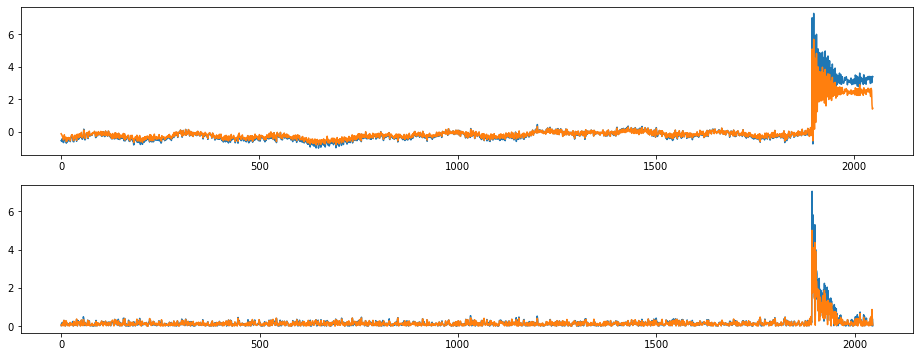

index:  62312
MAE:  0.108269004911872
n_bunches       444
bunch_index     477
bunch_number    242
Name: 2160, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


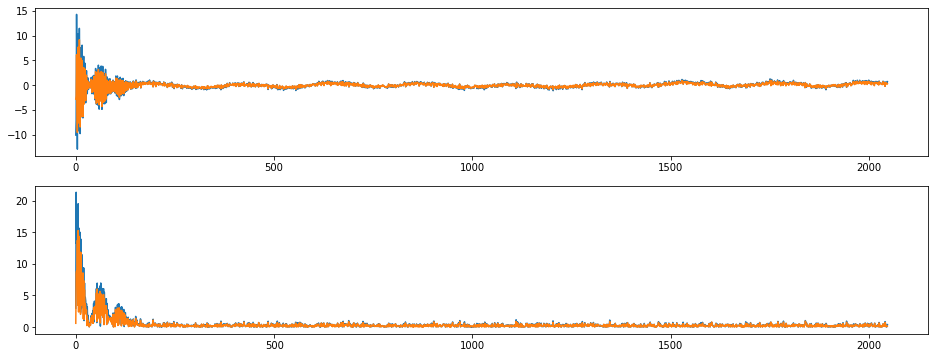

index:  283410
MAE:  0.10885869624149361
n_bunches        648
bunch_index     1006
bunch_number     184
Name: 9853, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


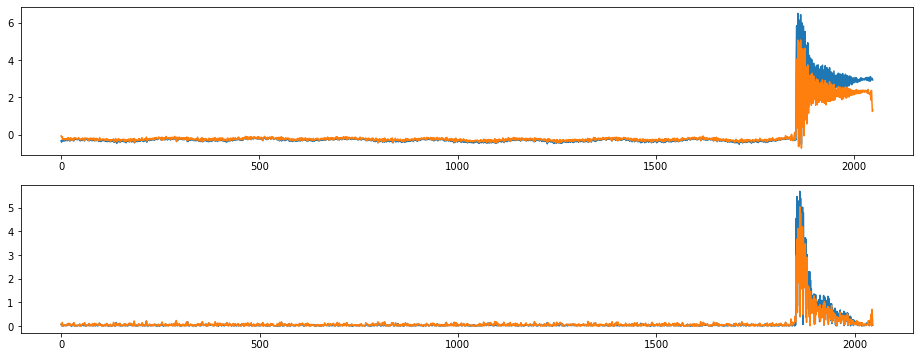

index:  153718
MAE:  0.10894461093989019
n_bunches       684
bunch_index       9
bunch_number      2
Name: 5316, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


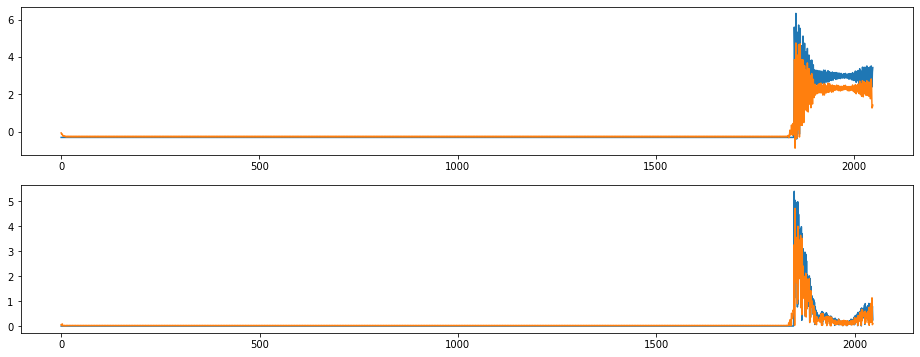

index:  158791
MAE:  0.10904451123830228
n_bunches       684
bunch_index     363
bunch_number    184
Name: 5498, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


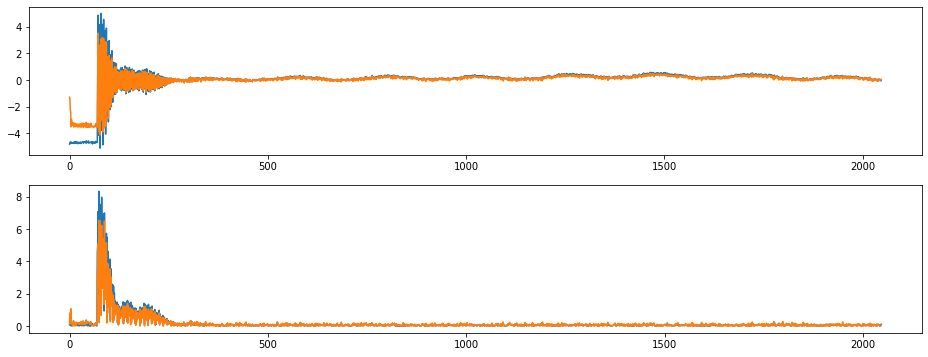

index:  258950
MAE:  0.1093389421544042
n_bunches       372
bunch_index     982
bunch_number    179
Name: 8985, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


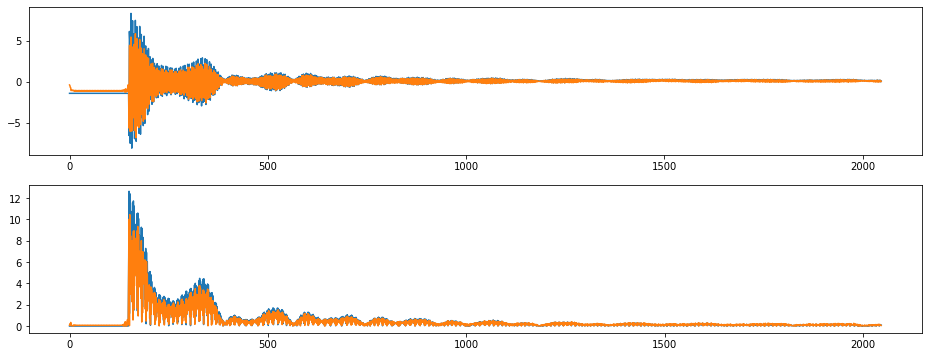

index:  317425
MAE:  0.11006317935021193
n_bunches        648
bunch_index     2994
bunch_number     560
Name: 11035, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


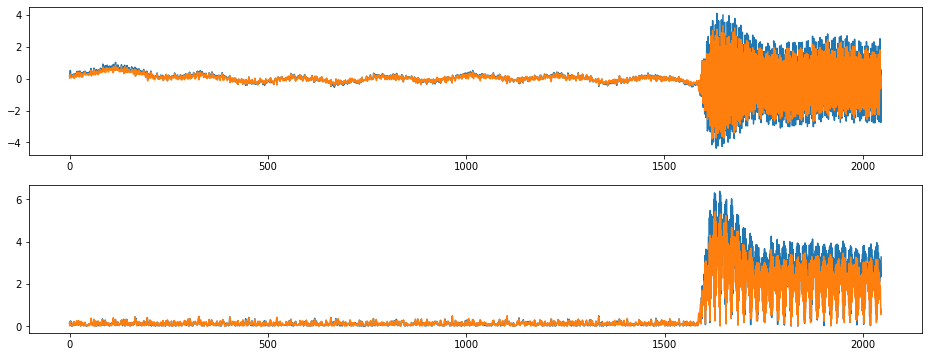

index:  59574
MAE:  0.11019610741308697
n_bunches       444
bunch_index     348
bunch_number    151
Name: 2069, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


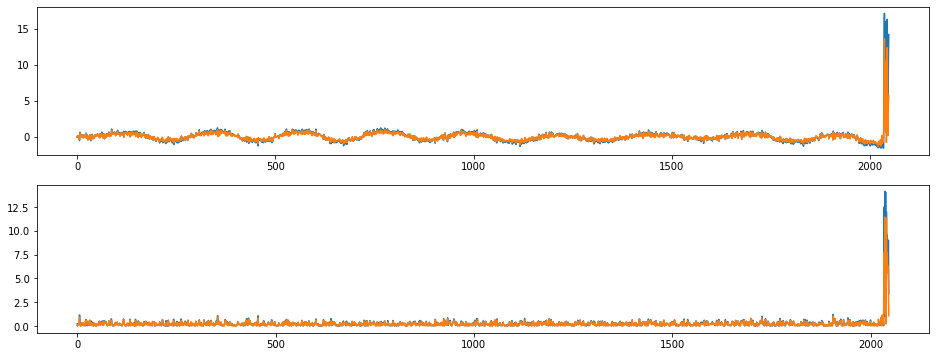

index:  145071
MAE:  0.11049994375115005
n_bunches       572
bunch_index     500
bunch_number    274
Name: 5016, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


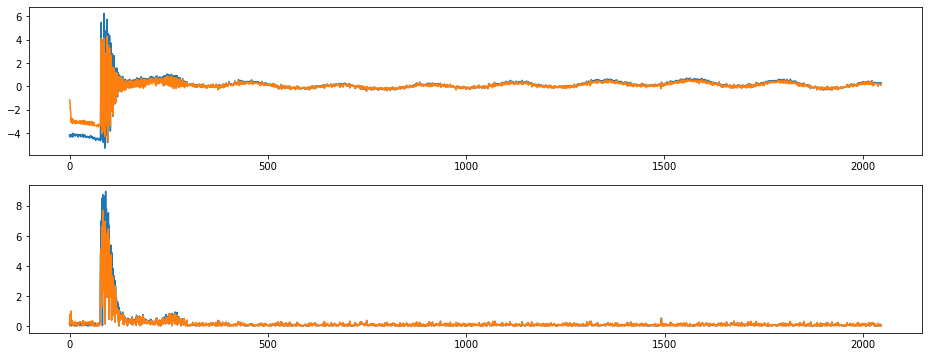

index:  46698
MAE:  0.11092446123397967
n_bunches        733
bunch_index     2079
bunch_number     438
Name: 1623, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


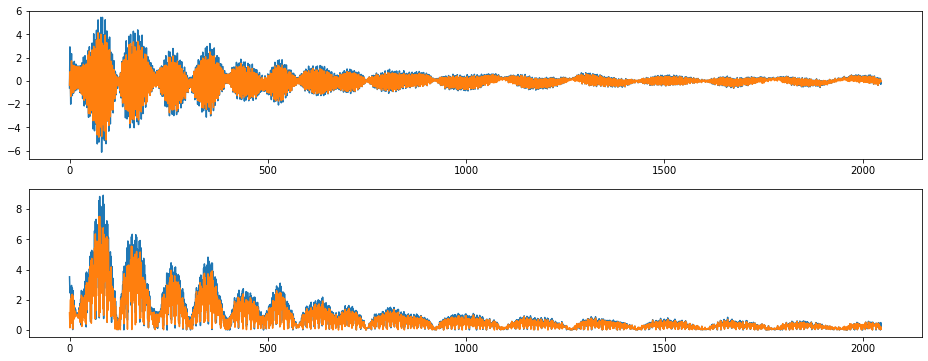

index:  223195
MAE:  0.11105398079780825
n_bunches        987
bunch_index     1984
bunch_number     526
Name: 7754, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


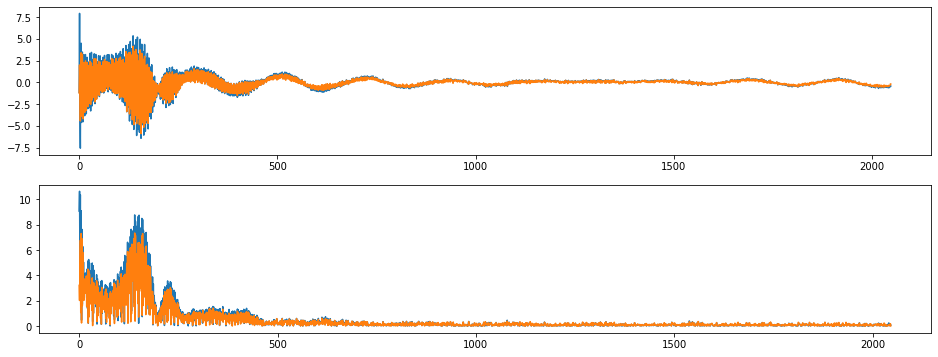

index:  390774
MAE:  0.11162522933599477
n_bunches       396
bunch_index     118
bunch_number     62
Name: 13572, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


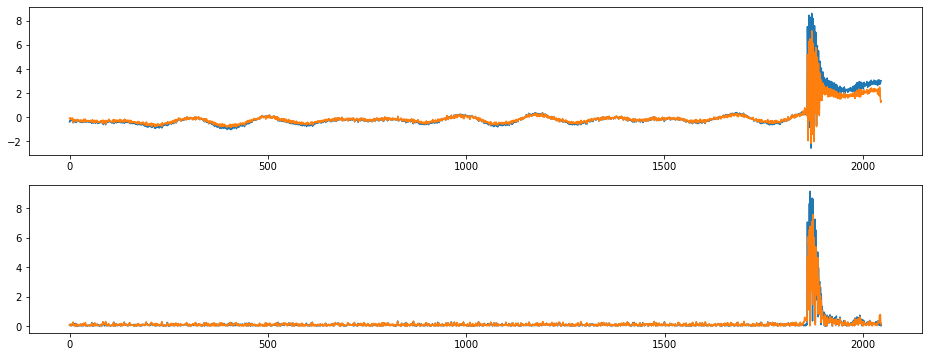

index:  19728
MAE:  0.11237559343845878
n_bunches       972
bunch_index     896
bunch_number    471
Name: 684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


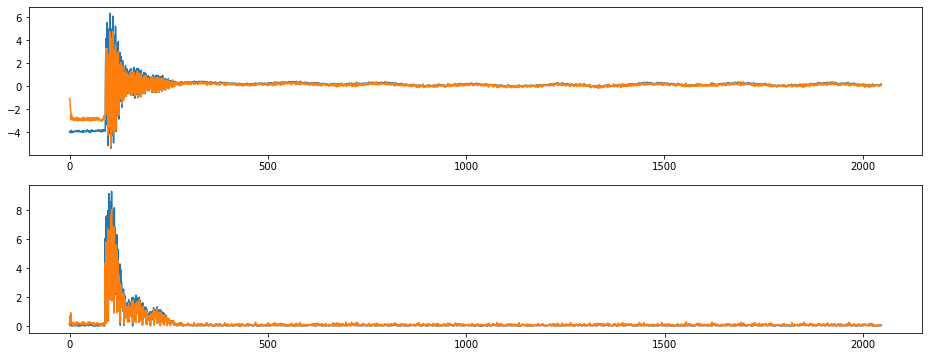

index:  119867
MAE:  0.11257081345854864
n_bunches       796
bunch_index     424
bunch_number    225
Name: 4159, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


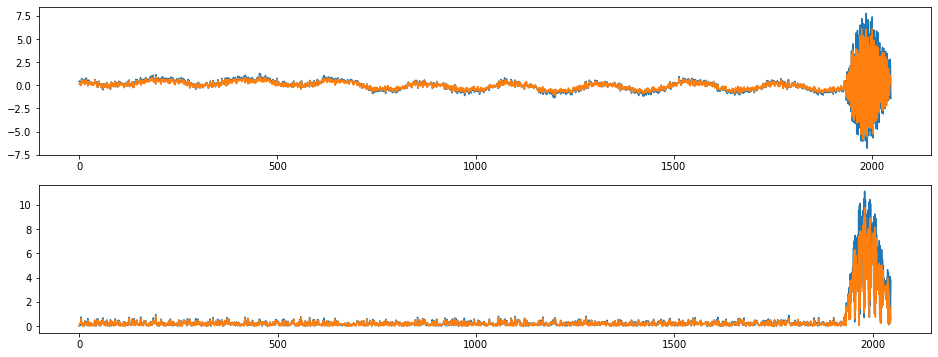

index:  191612
MAE:  0.11360152074890872
n_bunches       1227
bunch_index     1949
bunch_number     663
Name: 6661, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


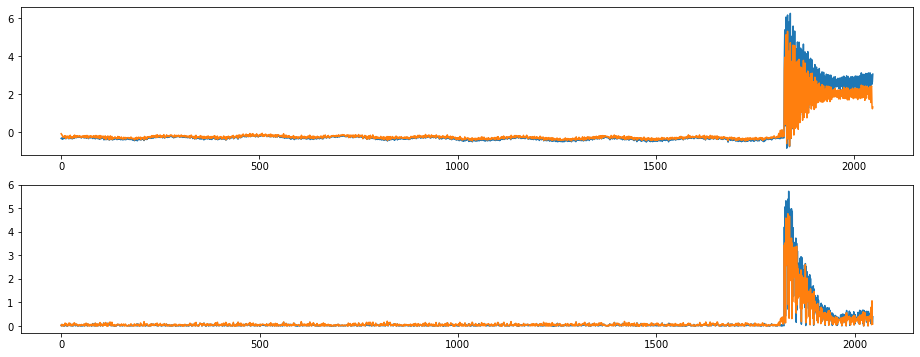

index:  263169
MAE:  0.1140193185898698
n_bunches        372
bunch_index     1773
bunch_number     331
Name: 9137, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


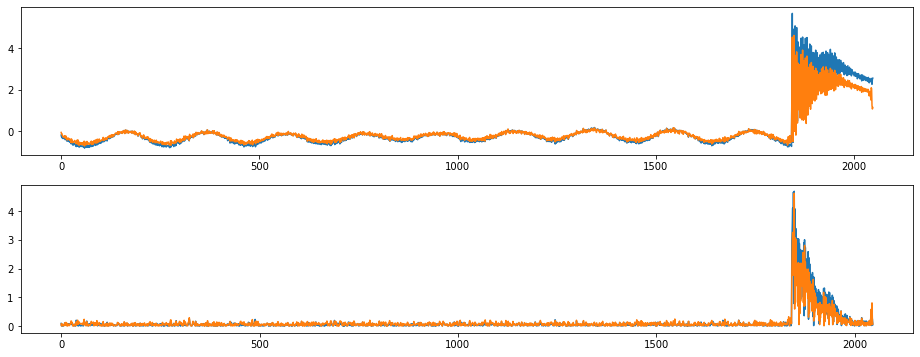

index:  247156
MAE:  0.11462928248580899
n_bunches       252
bunch_index     106
bunch_number     38
Name: 8579, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h51m14s.h5


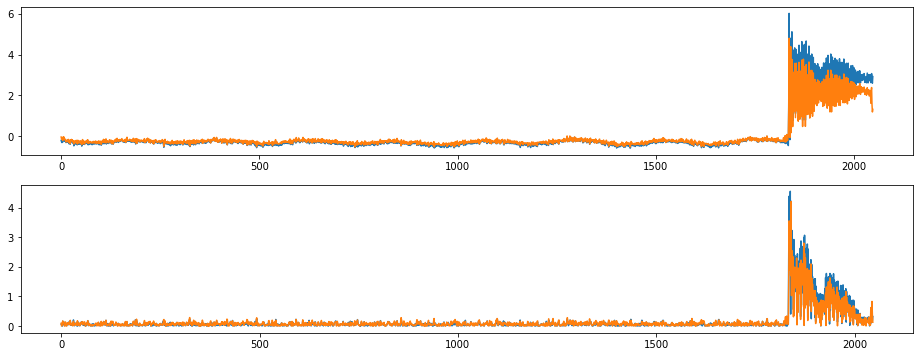

index:  281199
MAE:  0.1151326347428534
n_bunches       648
bunch_index     607
bunch_number    108
Name: 9777, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


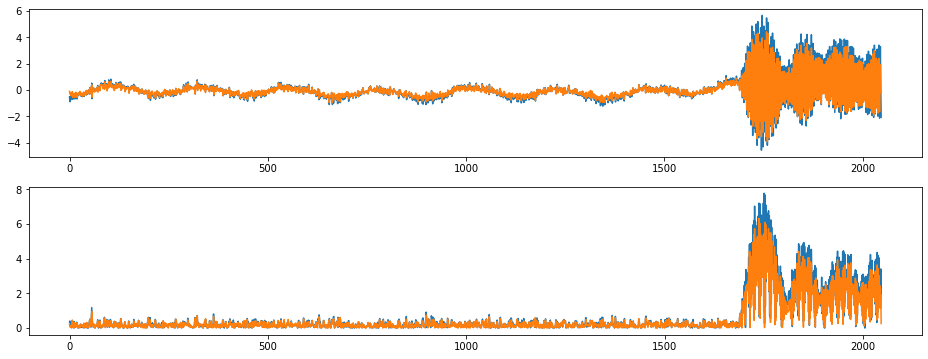

index:  262135
MAE:  0.11531621736816272
n_bunches        372
bunch_index     1588
bunch_number     296
Name: 9102, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


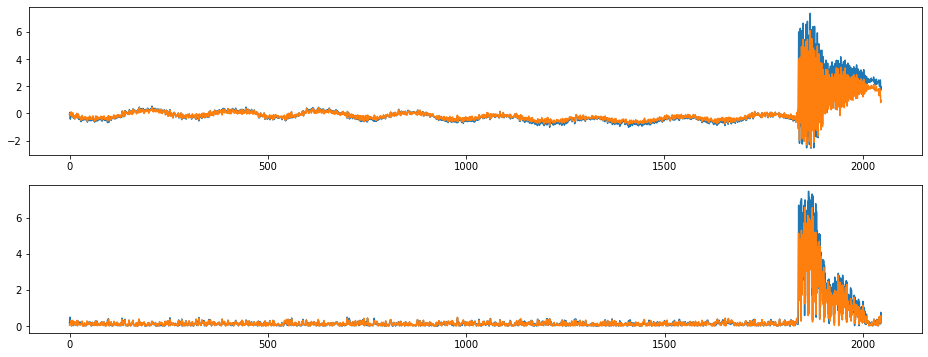

index:  185279
MAE:  0.11555714046789507
n_bunches       1227
bunch_index     1184
bunch_number     441
Name: 6439, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


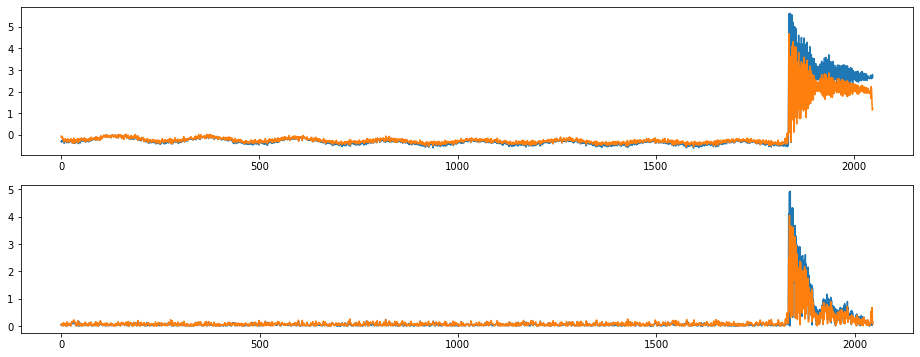

index:  347107
MAE:  0.03437926020719431
n_bunches       1358
bunch_index     2406
bunch_number     957
Name: 12080, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


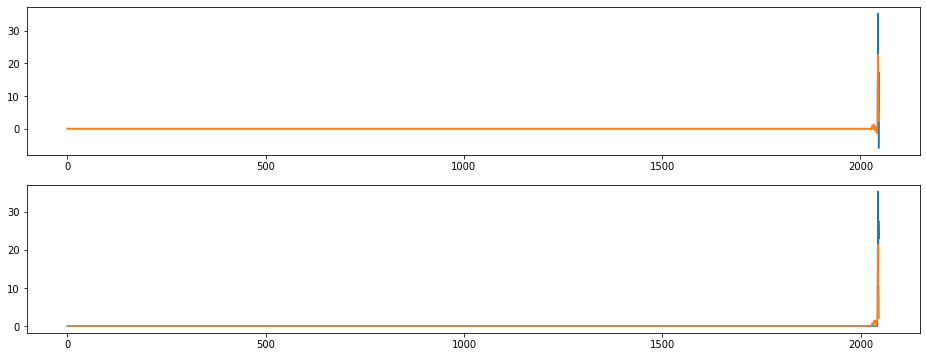

index:  49139
MAE:  0.11578615671783403
n_bunches        733
bunch_index     2473
bunch_number     523
Name: 1708, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


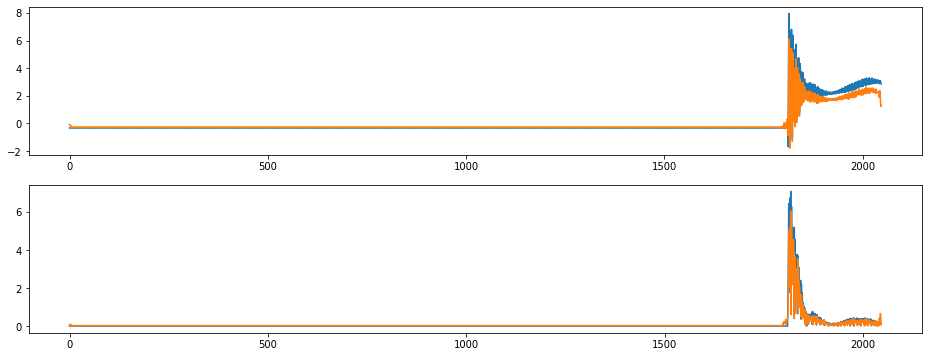

index:  87003
MAE:  0.11688920136371606
n_bunches        456
bunch_index     1379
bunch_number     406
Name: 3020, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7378/instability_data/07378_Inst_B1H_Q7_20181028_22h46m14s.h5


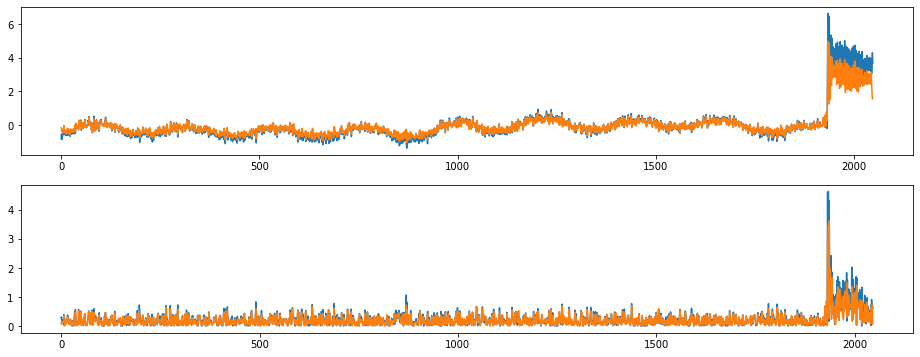

index:  308331
MAE:  0.11739453509220488
n_bunches        648
bunch_index     1368
bunch_number     253
Name: 10728, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


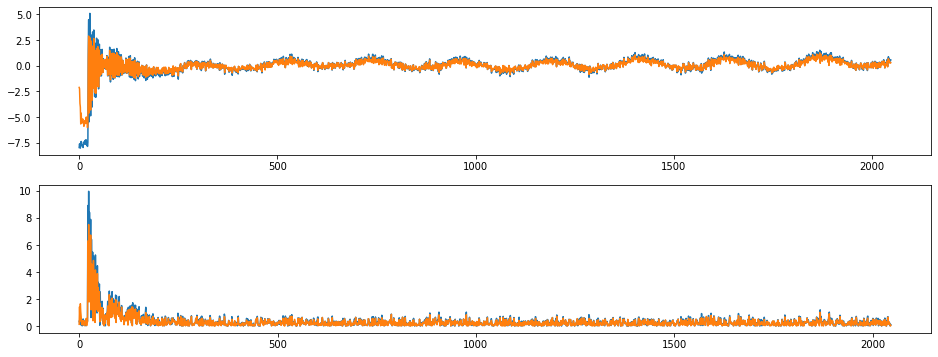

index:  378768
MAE:  0.11775533501275551
n_bunches       636
bunch_index     412
bunch_number    280
Name: 13154, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


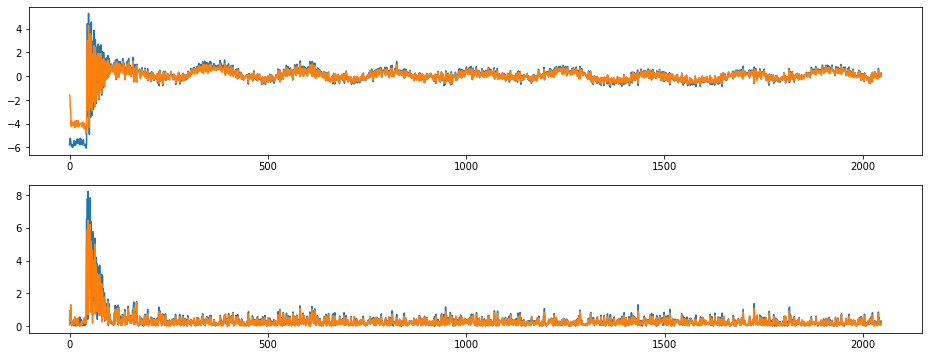

index:  213869
MAE:  0.11788394163950355
n_bunches       987
bunch_index     541
bunch_number    200
Name: 7428, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


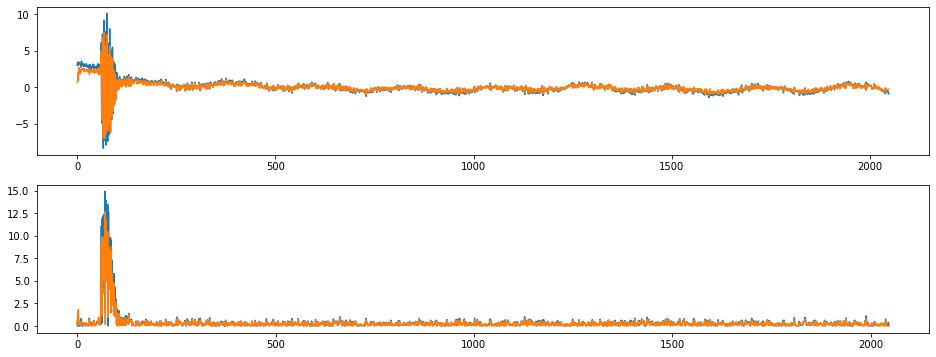

index:  323279
MAE:  0.11932843737316434
n_bunches       1358
bunch_index      319
bunch_number     122
Name: 11245, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


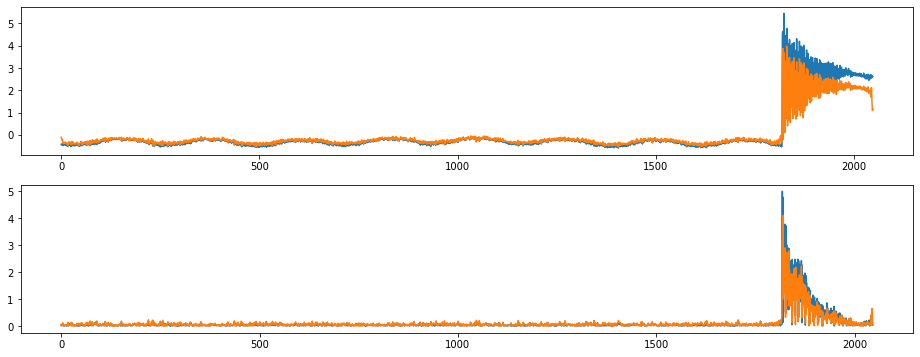

index:  280100
MAE:  0.1196028970579419
n_bunches       648
bunch_index     419
bunch_number     72
Name: 9741, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


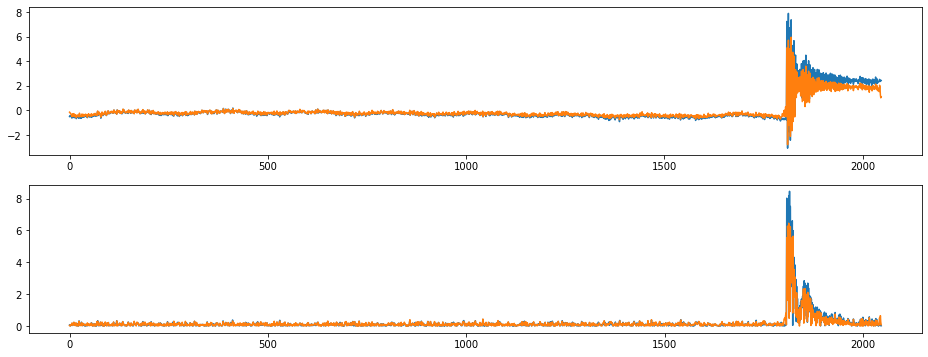

index:  73467
MAE:  0.12017242931338272
n_bunches       252
bunch_index     283
bunch_number    189
Name: 2551, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7223/instability_data/07223_Inst_B1H_Q7_20180927_17h56m01s.h5


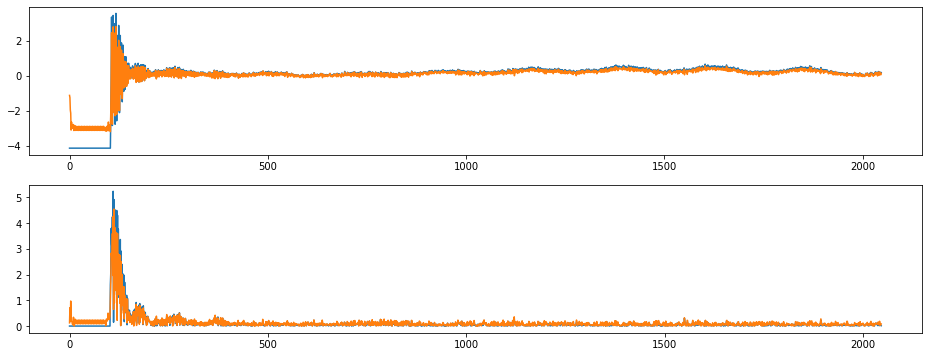

index:  331016
MAE:  0.12062140960191203
n_bunches       1358
bunch_index     1113
bunch_number     393
Name: 11516, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


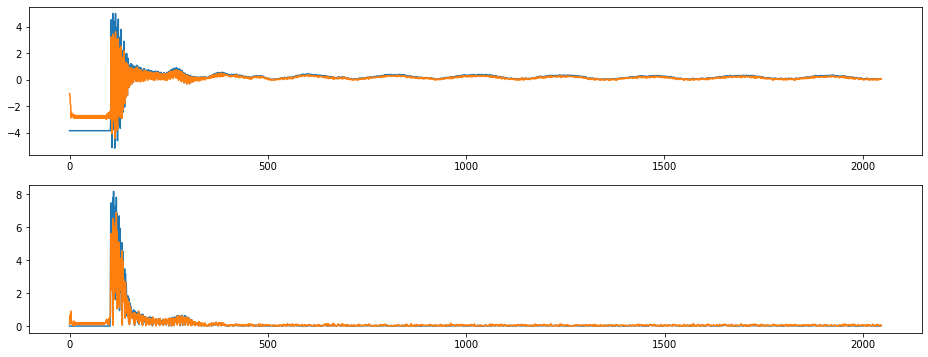

index:  154034
MAE:  0.12163959625450639
n_bunches       684
bunch_index      50
bunch_number     12
Name: 5326, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


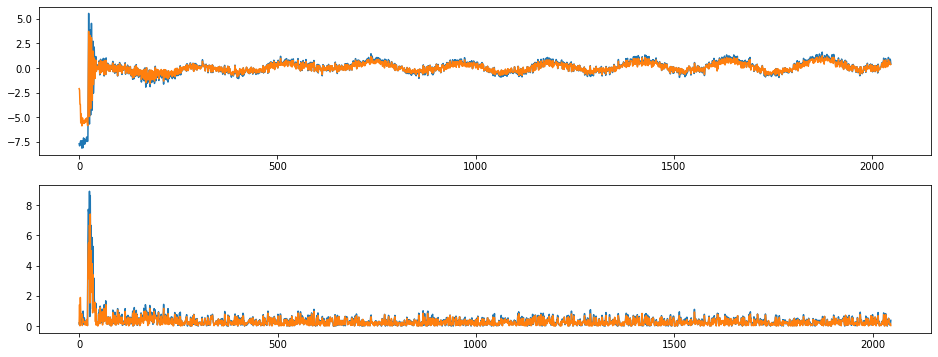

index:  59935
MAE:  0.12186503409453595
n_bunches       444
bunch_index     391
bunch_number    163
Name: 2081, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_09h47m15s.h5


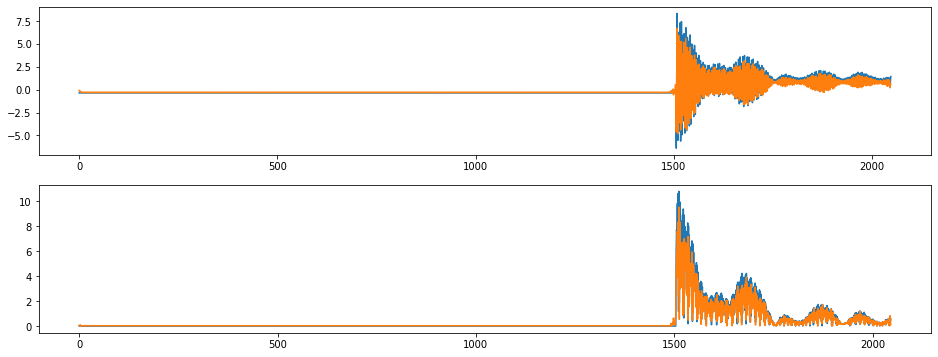

index:  325555
MAE:  0.12200763686888631
n_bunches       1358
bunch_index      466
bunch_number     199
Name: 11322, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


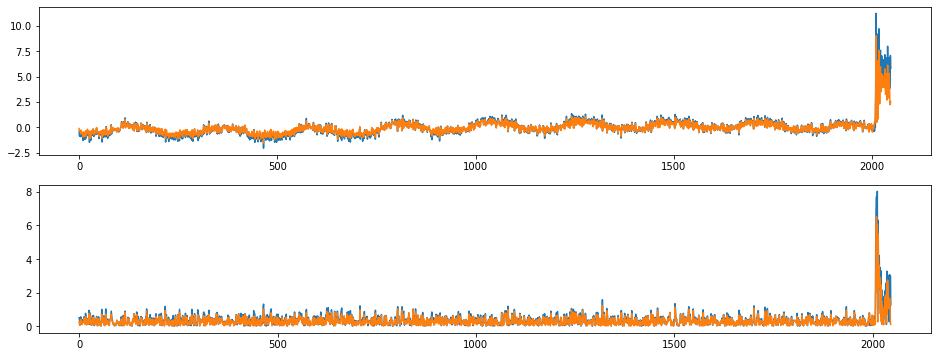

index:  216439
MAE:  0.12445721787339221
n_bunches        987
bunch_index     1092
bunch_number     287
Name: 7515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


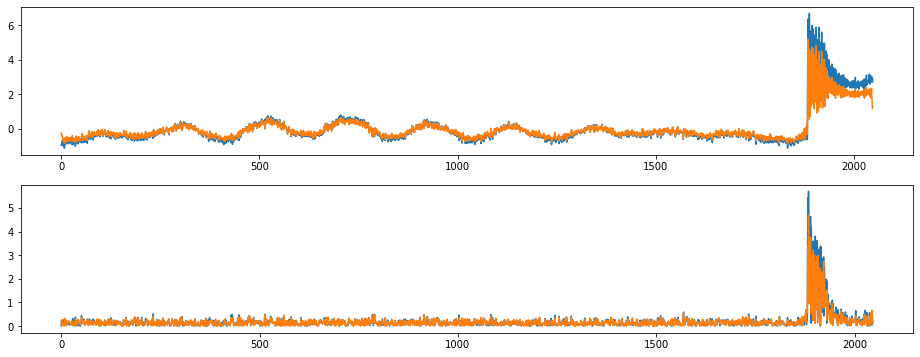

index:  128191
MAE:  0.12446798388917071
n_bunches       796
bunch_index     956
bunch_number    516
Name: 4450, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


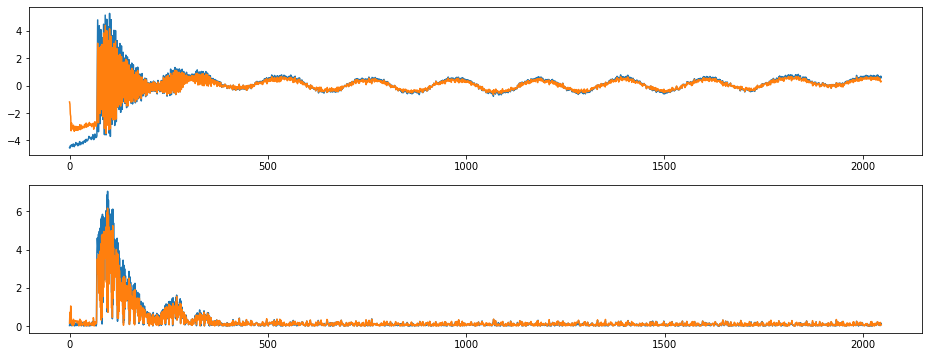

index:  254631
MAE:  0.1252002764744785
n_bunches       372
bunch_index     235
bunch_number     37
Name: 8843, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


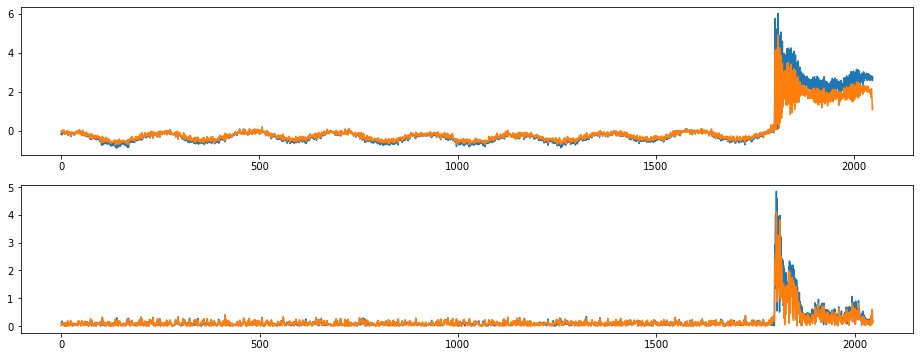

index:  373427
MAE:  0.1253631808191354
n_bunches       636
bunch_index     153
bunch_number     97
Name: 12971, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


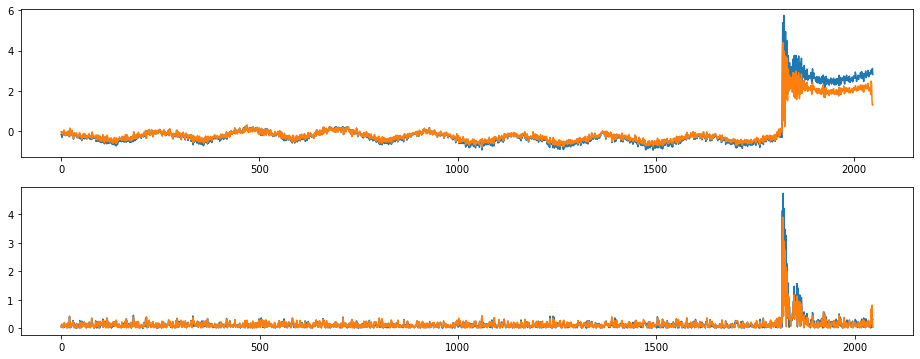

index:  144529
MAE:  0.12541716128112418
n_bunches       572
bunch_index     473
bunch_number    255
Name: 4997, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


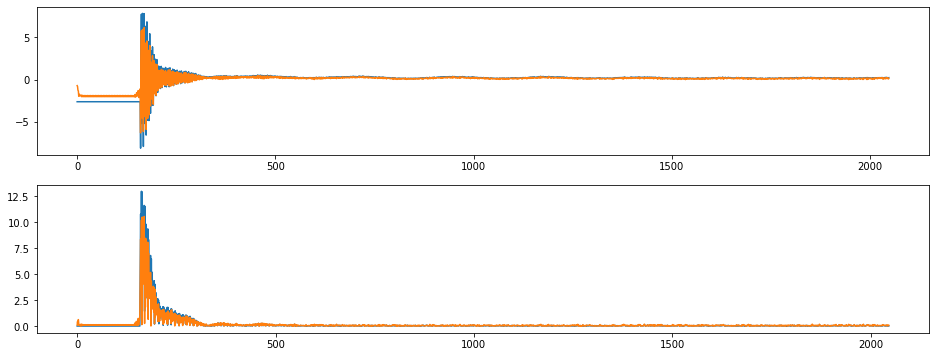

index:  348037
MAE:  0.12603088542095273
n_bunches       1358
bunch_index     2464
bunch_number     992
Name: 12115, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


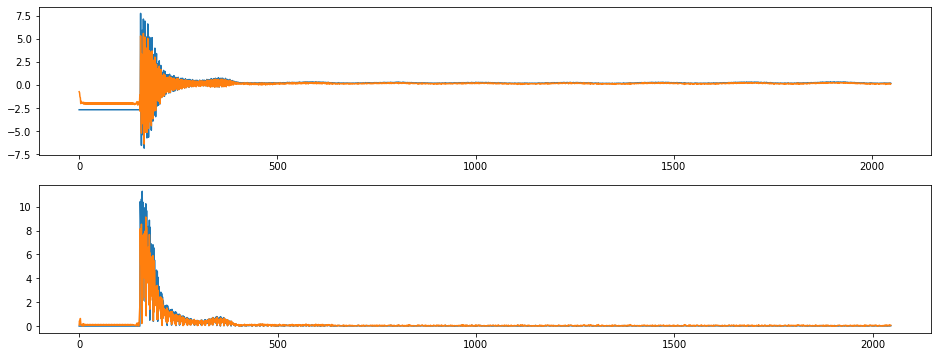

index:  187801
MAE:  0.12603553650118557
n_bunches       1227
bunch_index     1421
bunch_number     535
Name: 6533, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


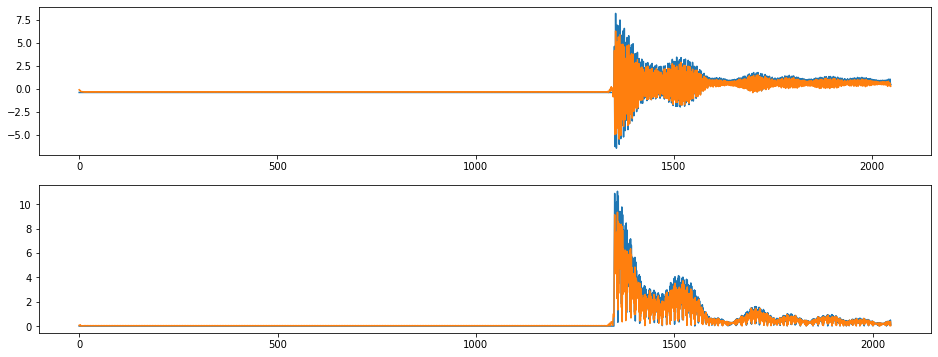

index:  346643
MAE:  0.12612089508648236
n_bunches       1358
bunch_index     2381
bunch_number     940
Name: 12063, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


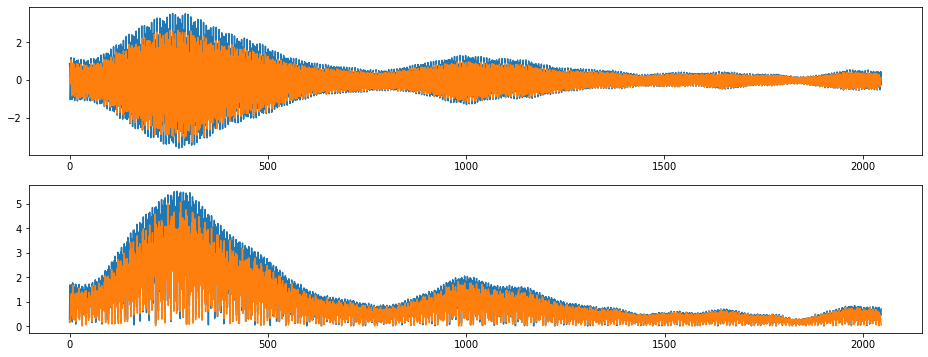

index:  269349
MAE:  0.12634360020567983
n_bunches       252
bunch_index      90
bunch_number     41
Name: 9370, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


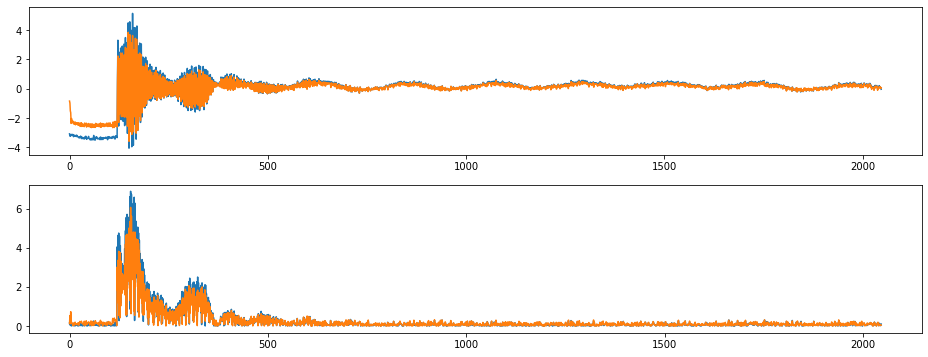

index:  128278
MAE:  0.12660189749401868
n_bunches       796
bunch_index     960
bunch_number    520
Name: 4454, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


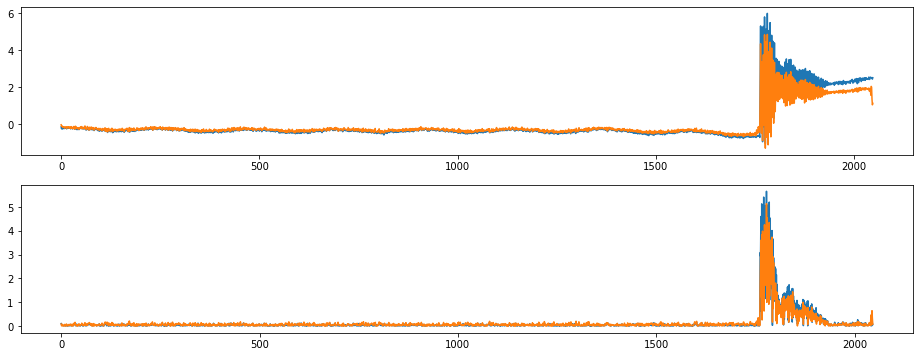

index:  360714
MAE:  0.12678271133524782
n_bunches       376
bunch_index     243
bunch_number     46
Name: 12544, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h34m32s.h5


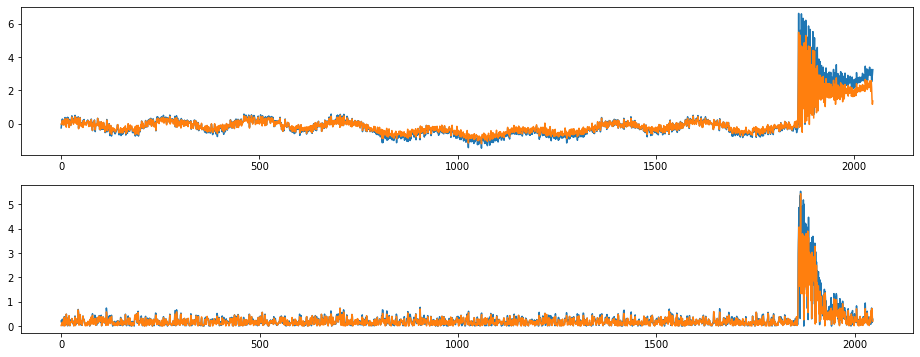

index:  402667
MAE:  0.12681007204216085
n_bunches       502
bunch_index     363
bunch_number     76
Name: 13990, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


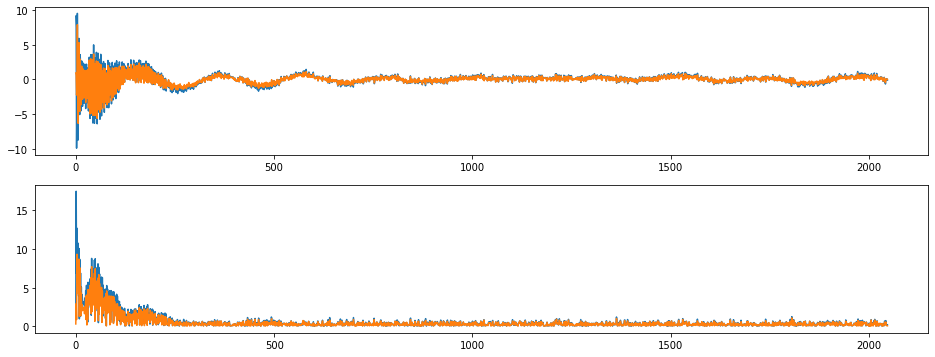

index:  186503
MAE:  0.12717169831934075
n_bunches       1227
bunch_index     1364
bunch_number     485
Name: 6483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


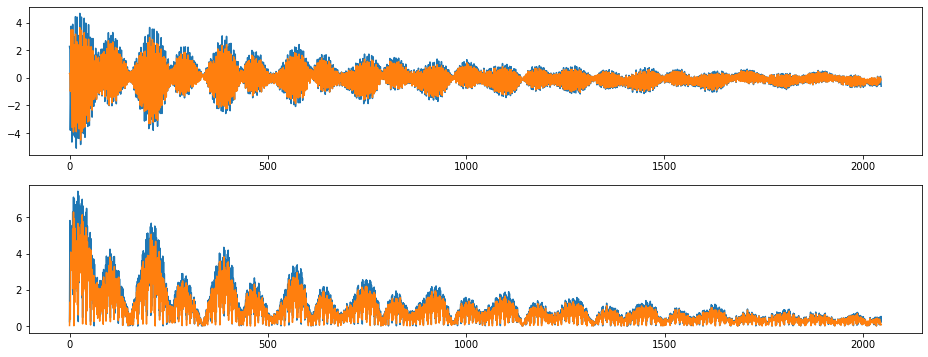

index:  50137
MAE:  0.1277723272745413
n_bunches        733
bunch_index     2639
bunch_number     557
Name: 1742, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


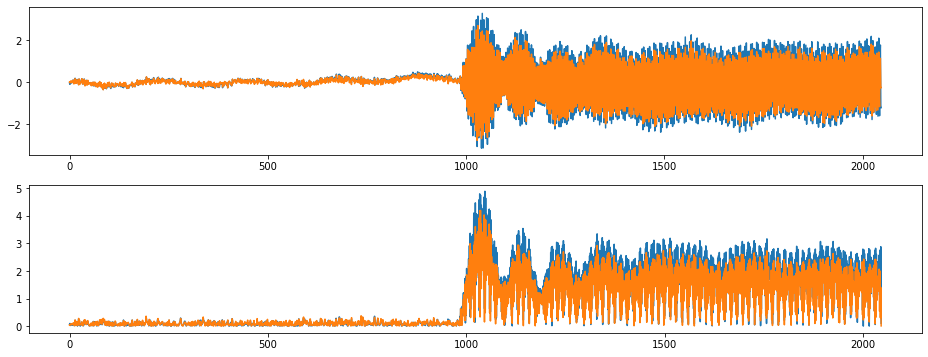

index:  124332
MAE:  0.12780655961351967
n_bunches       796
bunch_index     692
bunch_number    380
Name: 4314, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


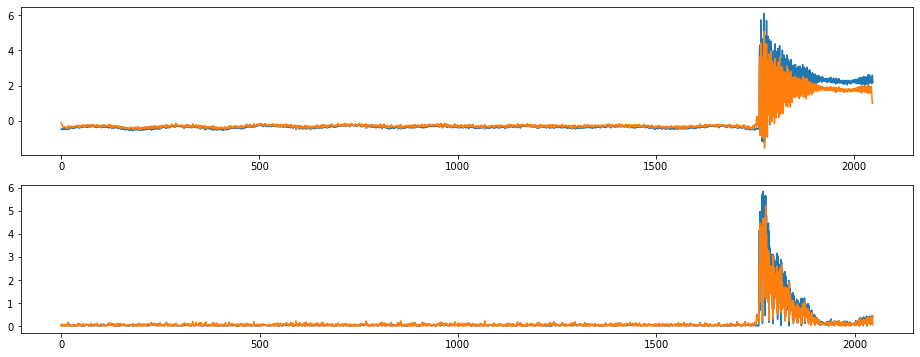

index:  364948
MAE:  0.12785204432855496
n_bunches       376
bunch_index     919
bunch_number    188
Name: 12686, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h34m32s.h5


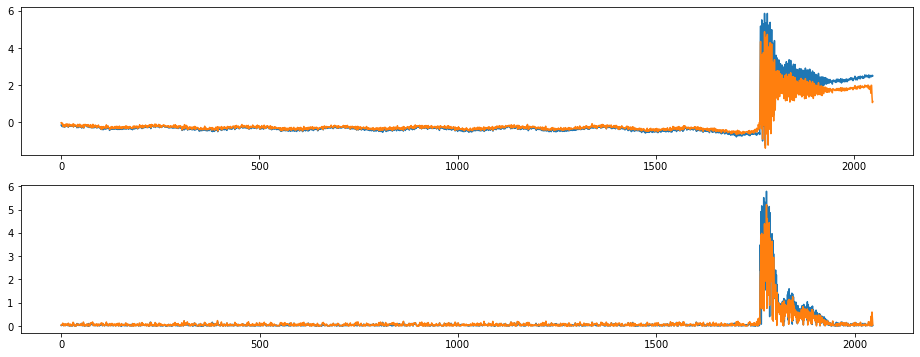

index:  87033
MAE:  0.12788285662554943
n_bunches        456
bunch_index     1388
bunch_number     408
Name: 3022, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7378/instability_data/07378_Inst_B1H_Q7_20181028_22h46m14s.h5


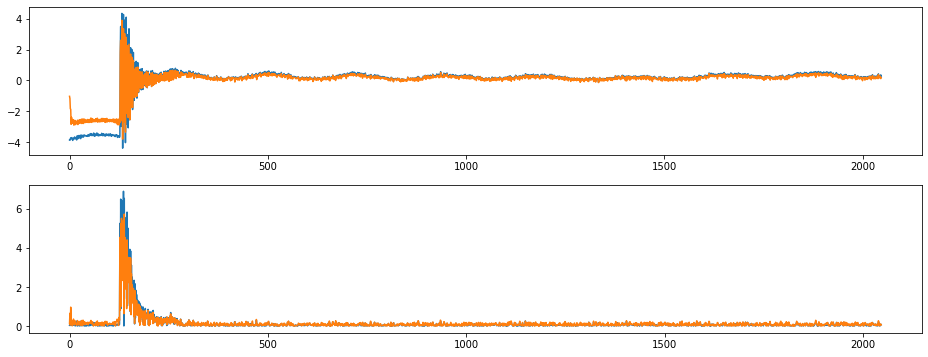

index:  306897
MAE:  0.1279553692382981
n_bunches        648
bunch_index     1122
bunch_number     204
Name: 10679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


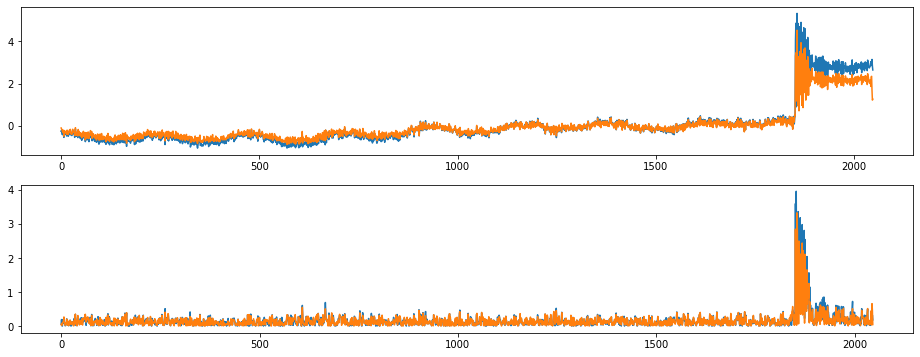

index:  80816
MAE:  0.12825297939151659
n_bunches        456
bunch_index     1115
bunch_number     194
Name: 2808, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7378/instability_data/07378_Inst_B1H_Q7_20181028_22h46m14s.h5


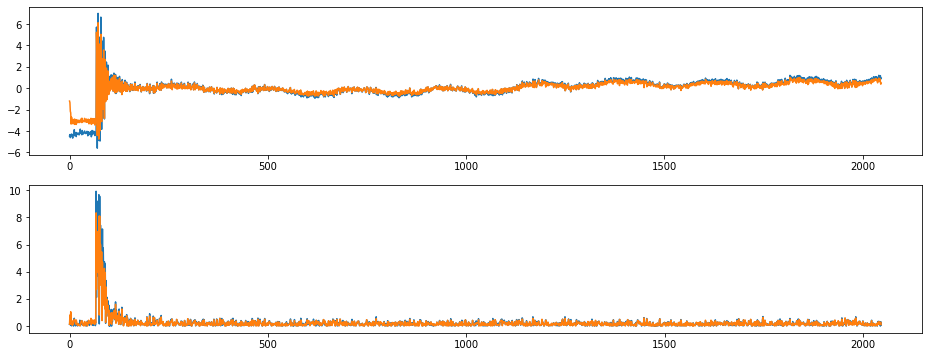

index:  173078
MAE:  0.12839077910453606
n_bunches       1227
bunch_index       68
bunch_number      19
Name: 6017, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


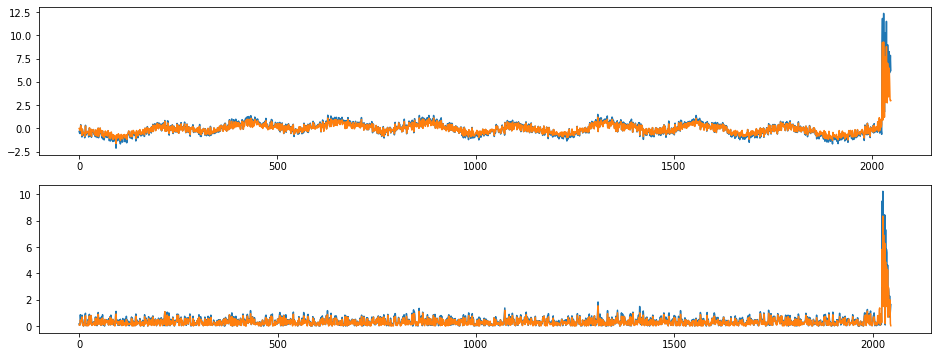

index:  44136
MAE:  0.12877811820404192
n_bunches        733
bunch_index     1645
bunch_number     350
Name: 1535, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


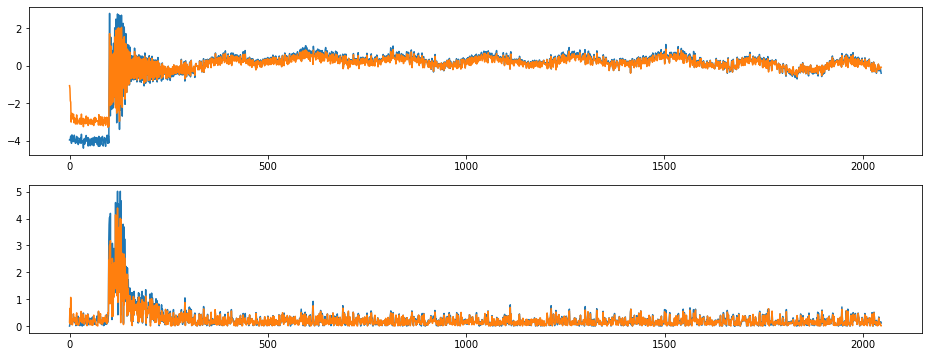

index:  41819
MAE:  0.12900210957477115
n_bunches        733
bunch_index     1272
bunch_number     270
Name: 1455, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


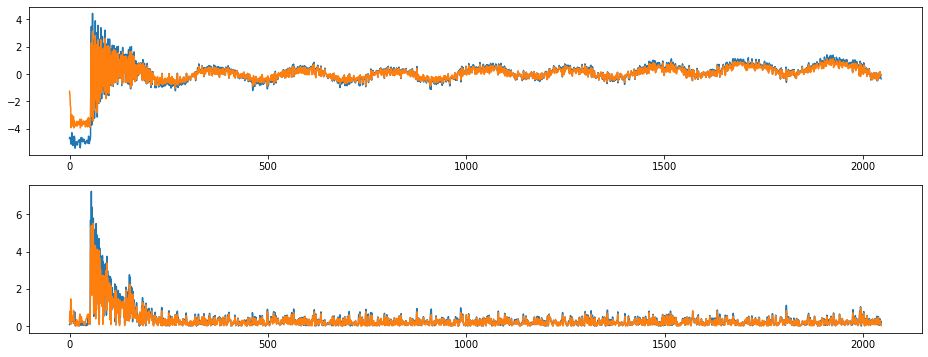

index:  49279
MAE:  0.12944780754322086
n_bunches        733
bunch_index     2488
bunch_number     527
Name: 1712, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


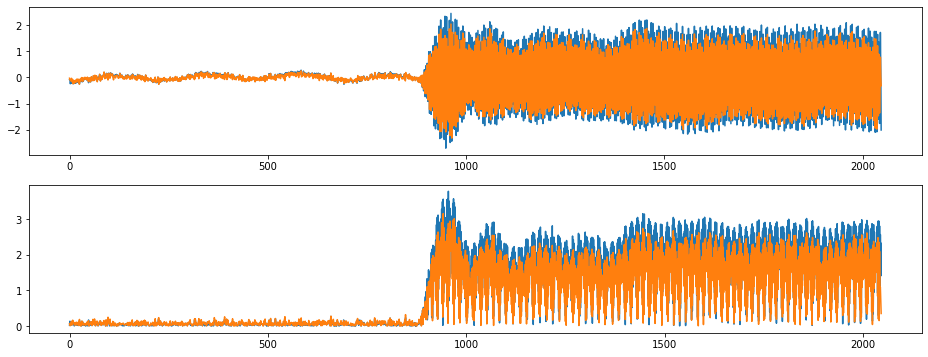

index:  252807
MAE:  0.13025455452624546
n_bunches       252
bunch_index     362
bunch_number    242
Name: 8783, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h51m14s.h5


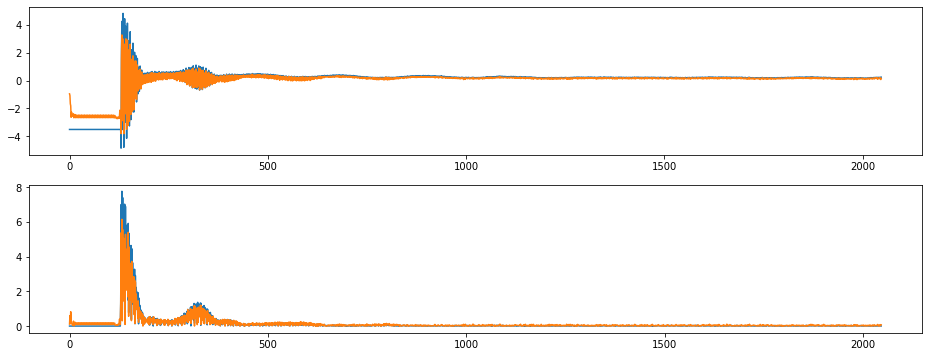

index:  233066
MAE:  0.1305105465648664
n_bunches        987
bunch_index     3151
bunch_number     870
Name: 8098, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


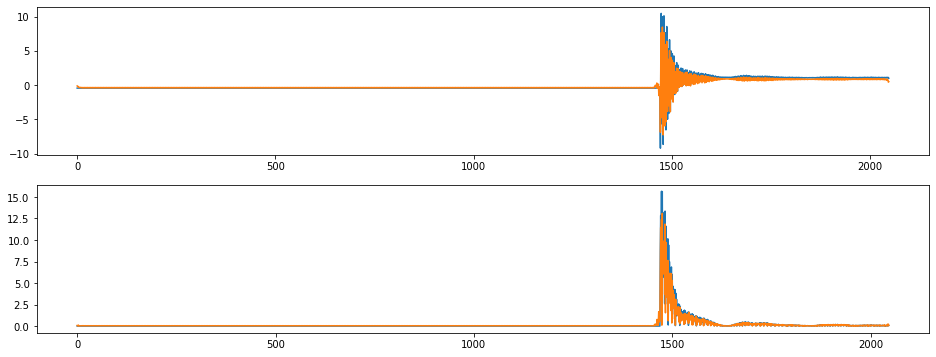

index:  237223
MAE:  0.13090415584490495
n_bunches       300
bunch_index      18
bunch_number      0
Name: 8241, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


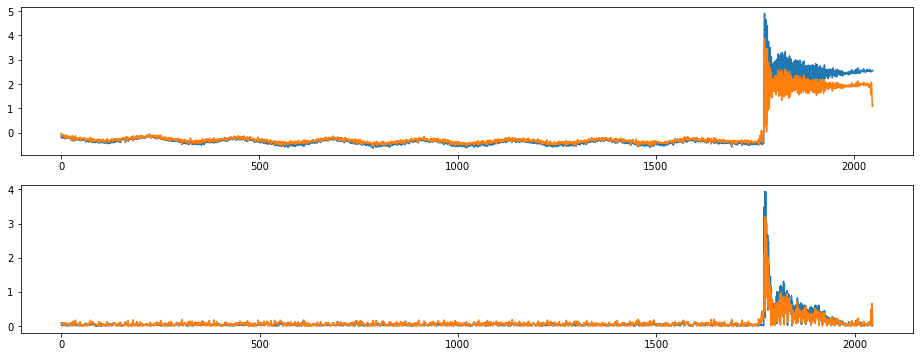

index:  144666
MAE:  0.019067612996423122
n_bunches       572
bunch_index     477
bunch_number    259
Name: 5001, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


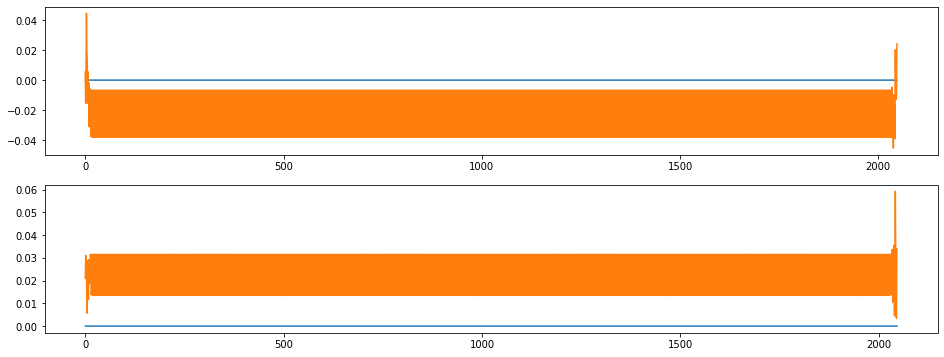

index:  400014
MAE:  0.019067612996423122
n_bunches       396
bunch_index     529
bunch_number    383
Name: 13893, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


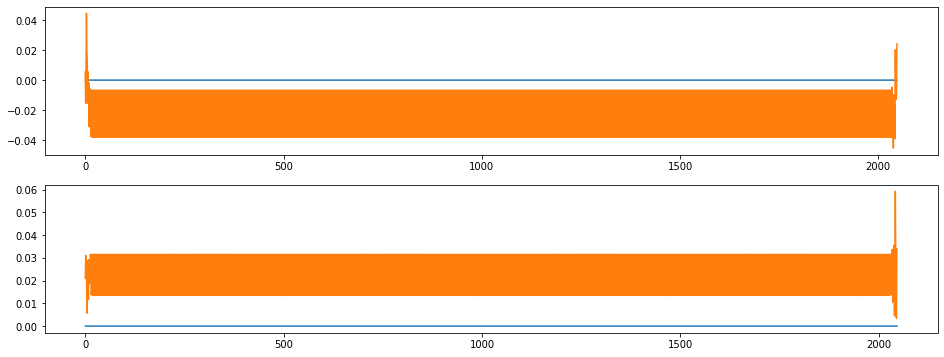

index:  167638
MAE:  0.019067612996423122
n_bunches       684
bunch_index     923
bunch_number    498
Name: 5812, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


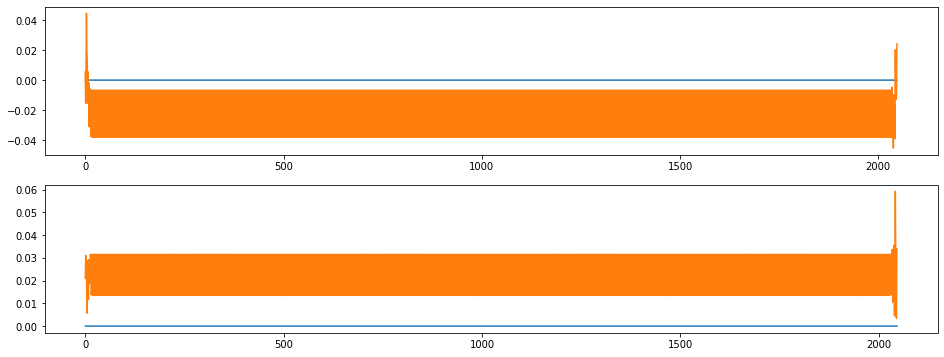

index:  165885
MAE:  0.019067612996423122
n_bunches       684
bunch_index     810
bunch_number    440
Name: 5754, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


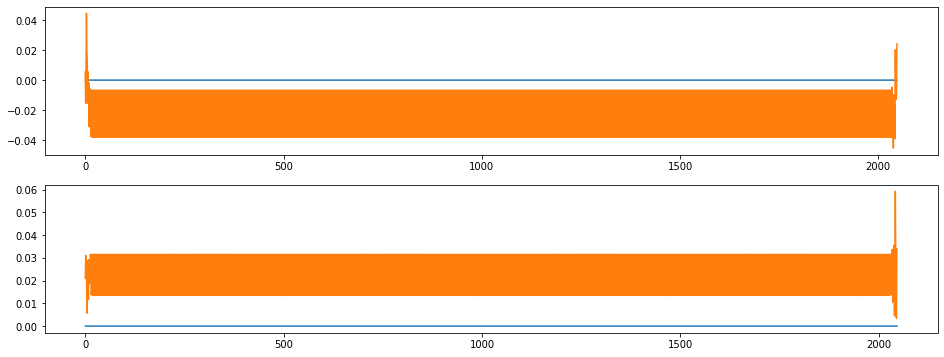

index:  406619
MAE:  0.019067612996423122
n_bunches        502
bunch_index     1006
bunch_number     210
Name: 14124, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


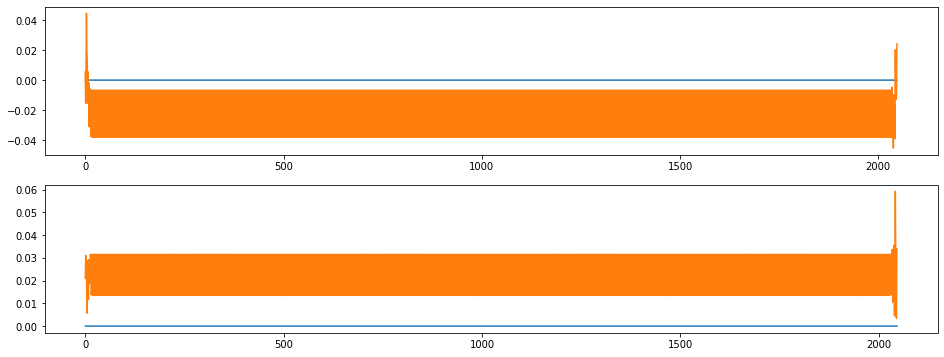

index:  317896
MAE:  0.019067612996423122
n_bunches        648
bunch_index     3092
bunch_number     576
Name: 11051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


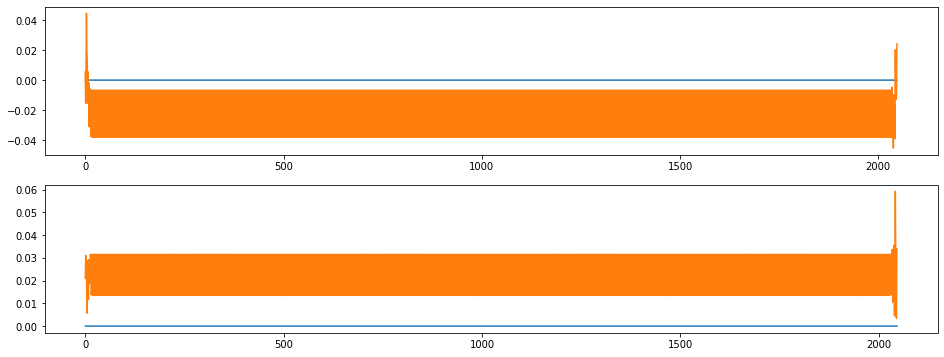

index:  122609
MAE:  0.019067612996423122
n_bunches       796
bunch_index     598
bunch_number    321
Name: 4255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


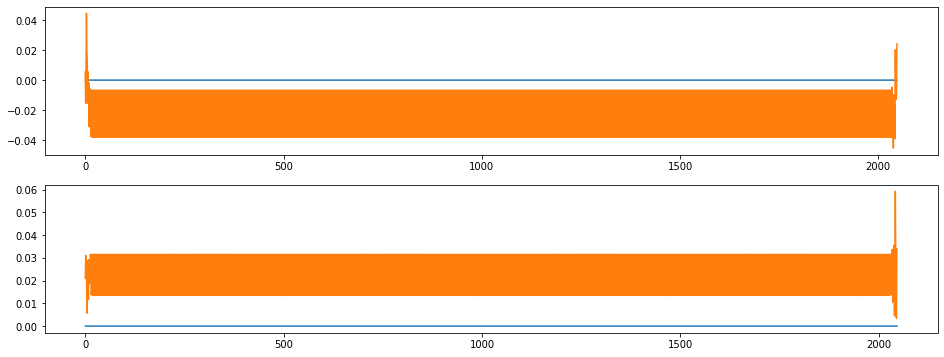

index:  374220
MAE:  0.019067612996423122
n_bunches       636
bunch_index     209
bunch_number    122
Name: 12996, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


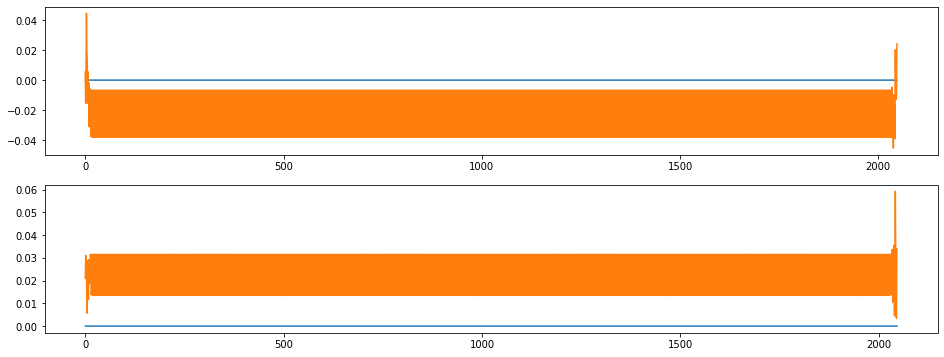

index:  302482
MAE:  0.019067612996423122
n_bunches       648
bunch_index     307
bunch_number     53
Name: 10528, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


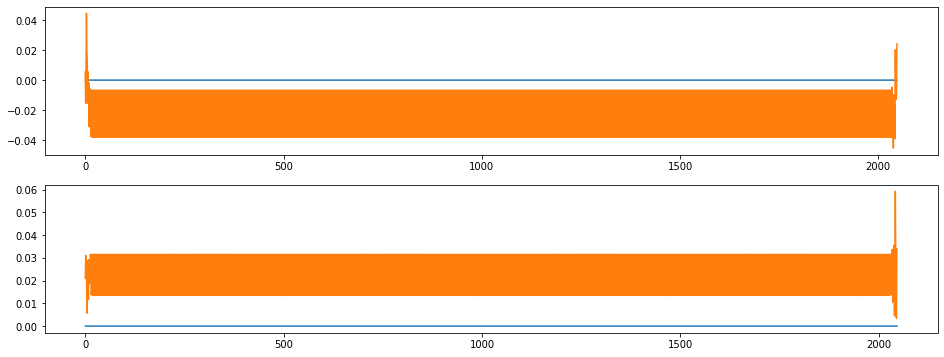

index:  284637
MAE:  0.019067612996423122
n_bunches        648
bunch_index     1230
bunch_number     228
Name: 9897, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


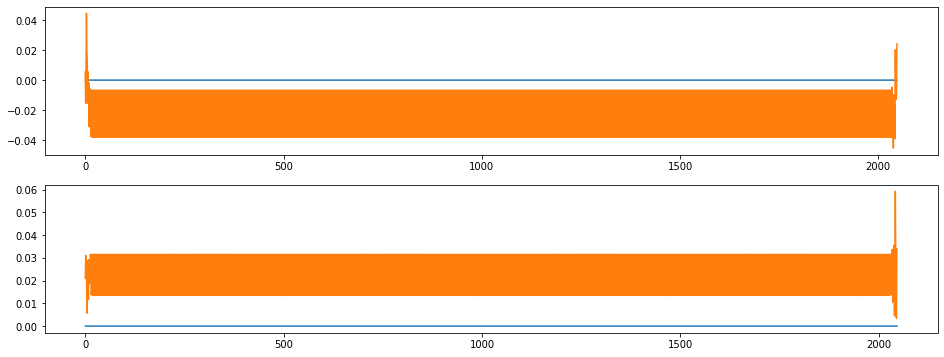

index:  317910
MAE:  0.019067612996423122
n_bunches        648
bunch_index     3092
bunch_number     576
Name: 11051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


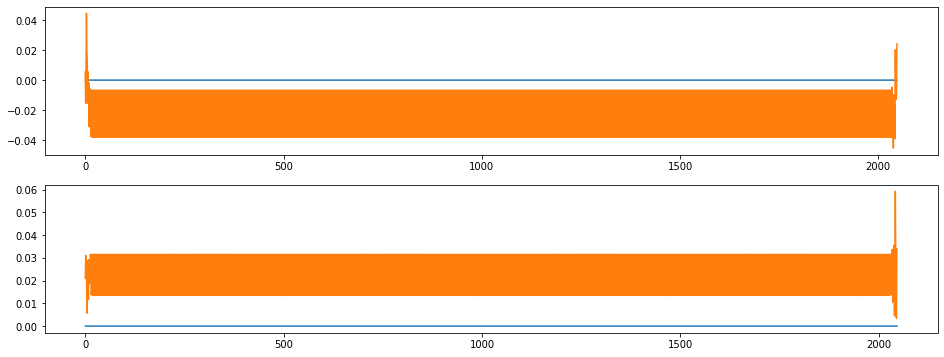

index:  192319
MAE:  0.019067612996423122
n_bunches       1227
bunch_index     1972
bunch_number     686
Name: 6684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


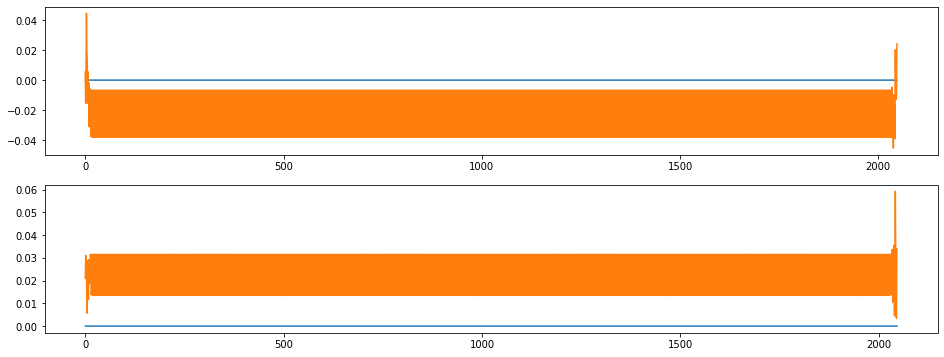

index:  308337
MAE:  0.019067612996423122
n_bunches        648
bunch_index     1368
bunch_number     253
Name: 10728, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


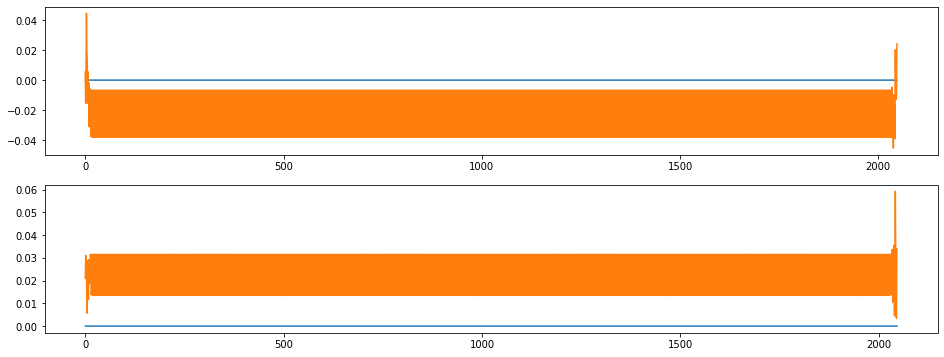

index:  402930
MAE:  0.019067612996423122
n_bunches       502
bunch_index     425
bunch_number     85
Name: 13999, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


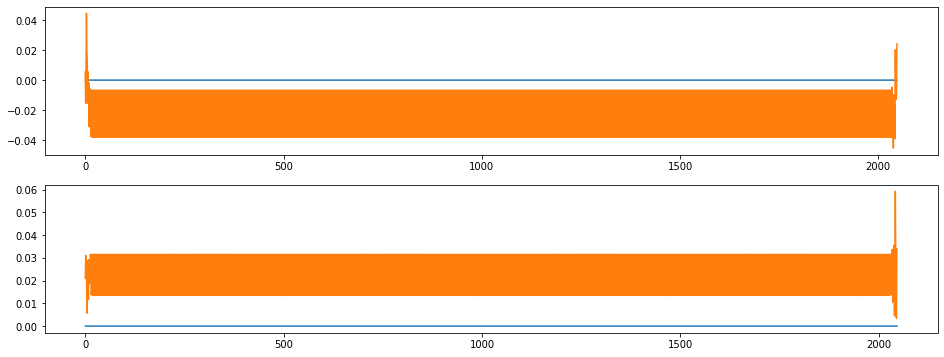

index:  345999
MAE:  0.019067612996423122
n_bunches       1358
bunch_index     2345
bunch_number     916
Name: 12039, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


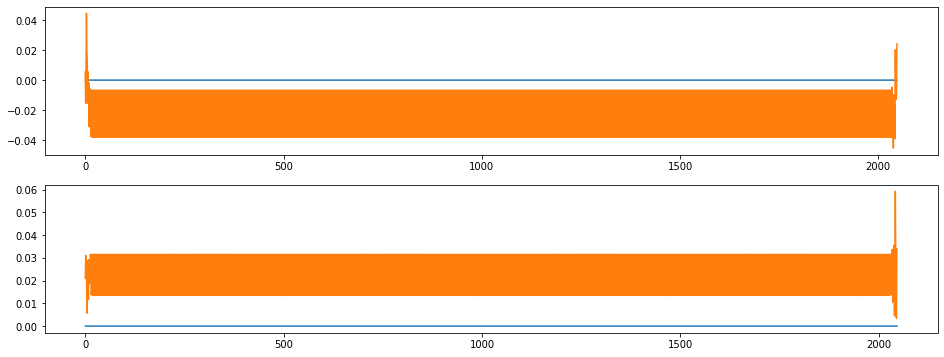

index:  251447
MAE:  0.019067612996423122
n_bunches       252
bunch_index     302
bunch_number    189
Name: 8730, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h51m14s.h5


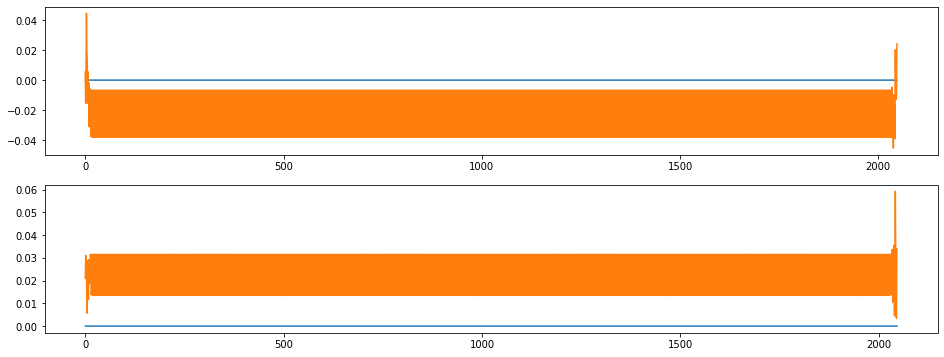

index:  165978
MAE:  0.019067612996423122
n_bunches       684
bunch_index     813
bunch_number    443
Name: 5757, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


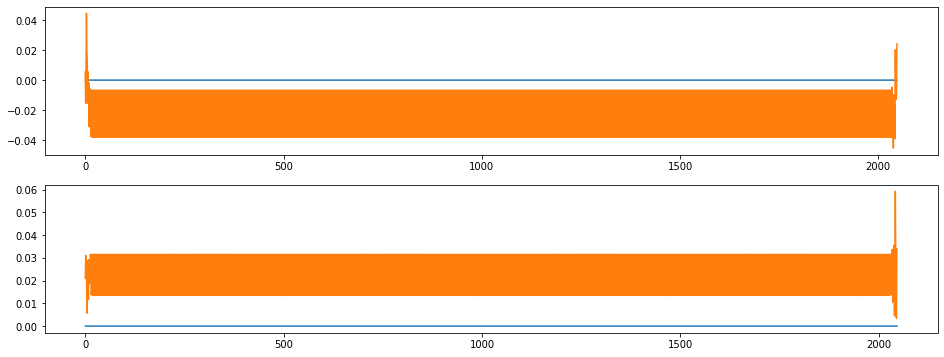

index:  135808
MAE:  0.019067612996423122
n_bunches        796
bunch_index     1400
bunch_number     772
Name: 4706, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


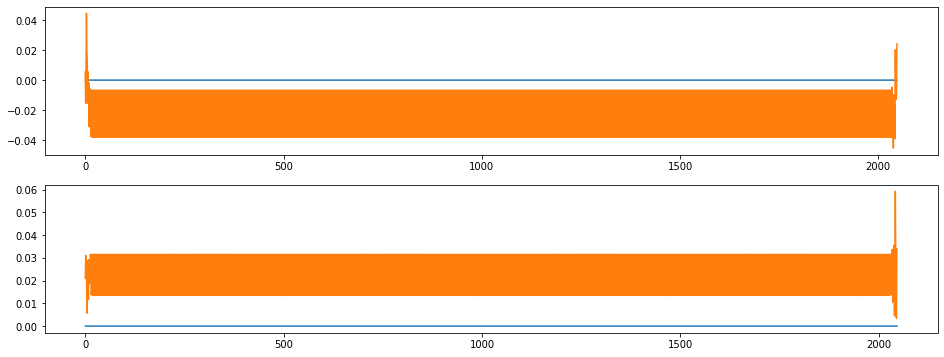

index:  237007
MAE:  0.019067612996423122
n_bunches       12
bunch_index     23
bunch_number     5
Name: 8234, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7068/instability_data/07068_Inst_B1H_Q7_20180820_00h27m53s.h5


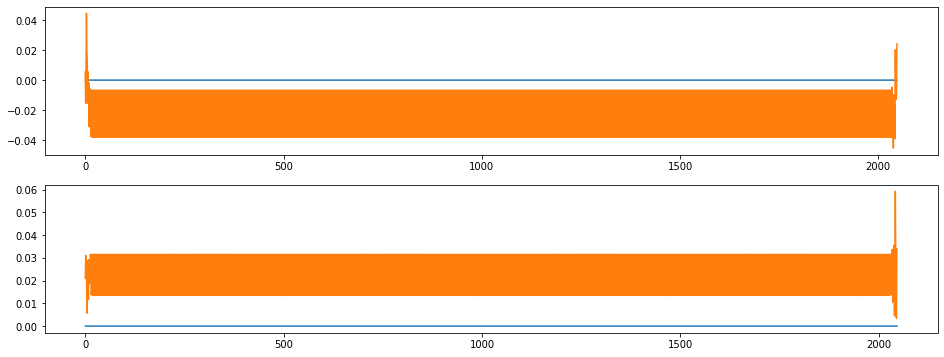

index:  35025
MAE:  0.019067612996423122
n_bunches       733
bunch_index     157
bunch_number     31
Name: 1216, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


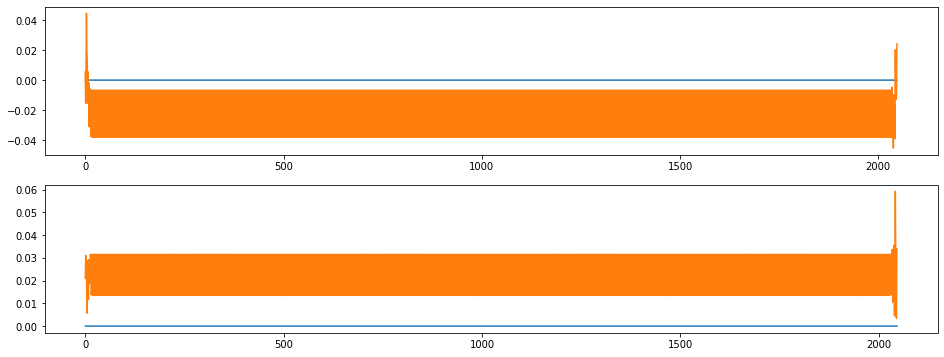

index:  212027
MAE:  0.019067612996423122
n_bunches       987
bunch_index     471
bunch_number    137
Name: 7365, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


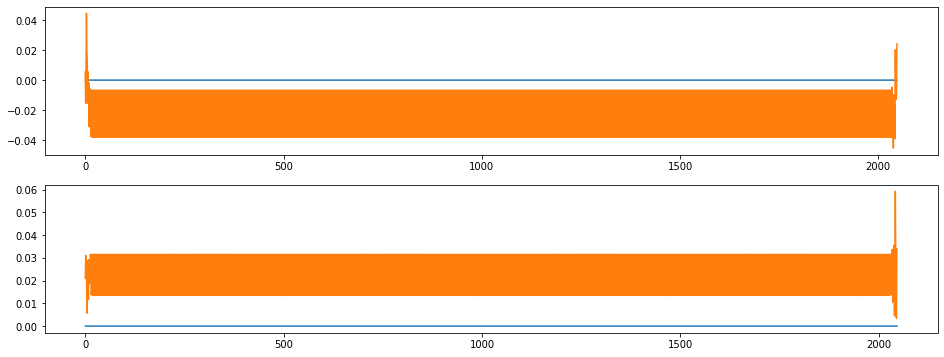

index:  251464
MAE:  0.019067612996423122
n_bunches       252
bunch_index     304
bunch_number    191
Name: 8732, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h51m14s.h5


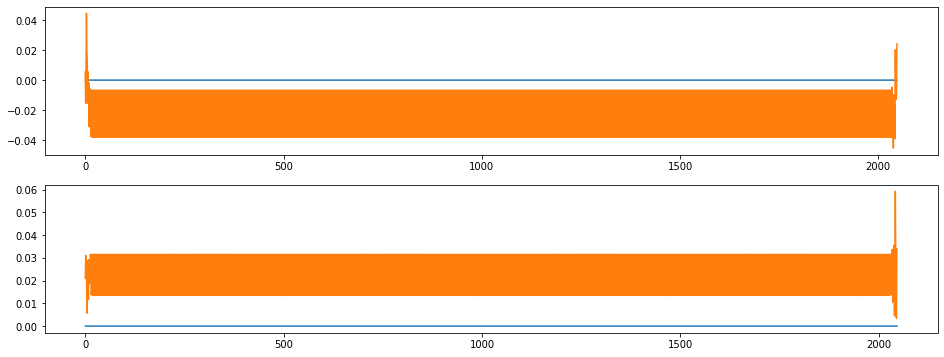

index:  271191
MAE:  0.019067612996423122
n_bunches       252
bunch_index     159
bunch_number    103
Name: 9432, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


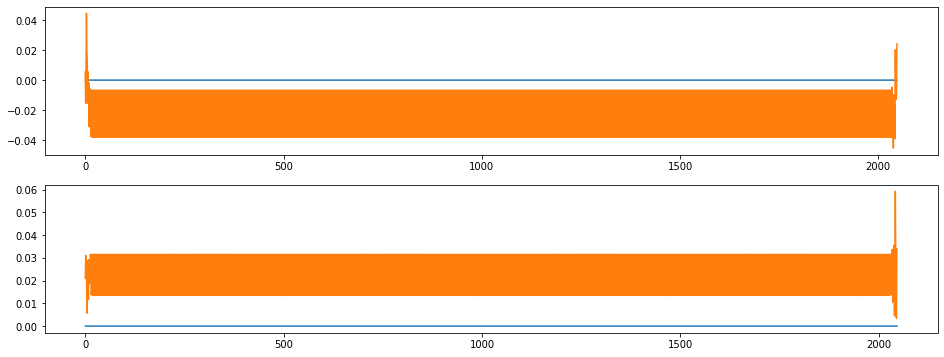

index:  256779
MAE:  0.019067612996423122
n_bunches       372
bunch_index     567
bunch_number    105
Name: 8911, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


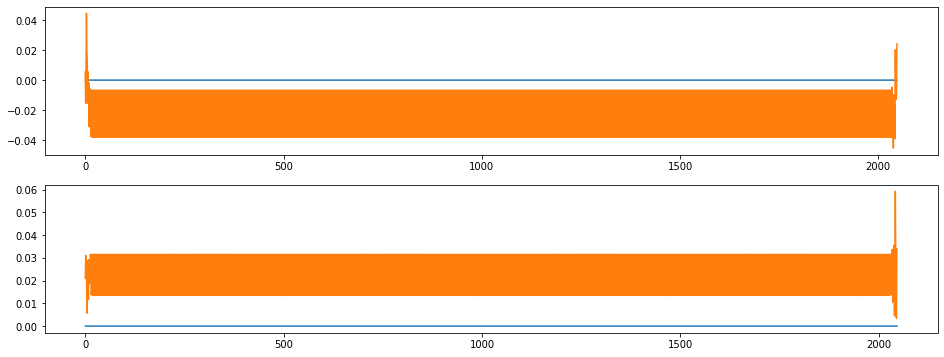

index:  41890
MAE:  0.019067612996423122
n_bunches        733
bunch_index     1310
bunch_number     273
Name: 1458, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


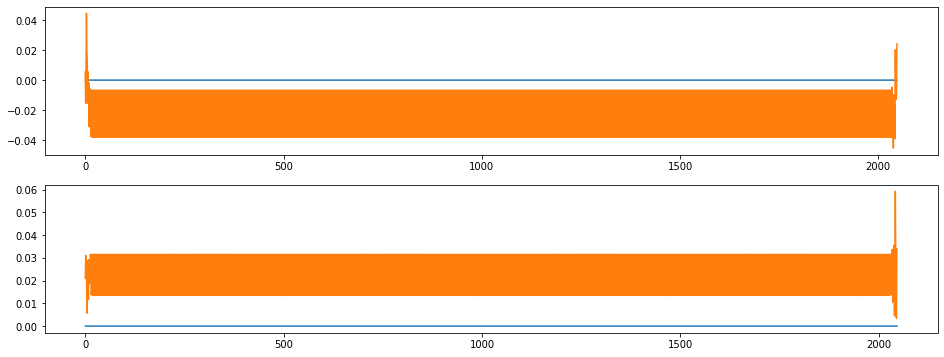

index:  106113
MAE:  0.019067612996423122
n_bunches       324
bunch_index     424
bunch_number     74
Name: 3684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7229/instability_data/07229_Inst_B1H_Q7_20180928_08h38m14s.h5


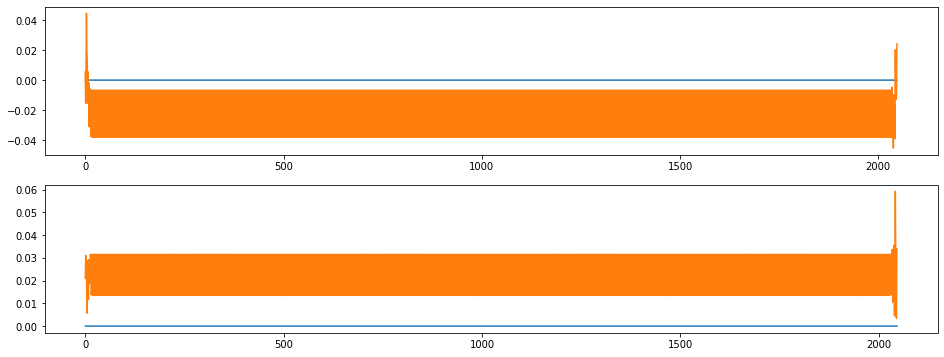

index:  317875
MAE:  0.019067612996423122
n_bunches        648
bunch_index     3060
bunch_number     575
Name: 11050, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


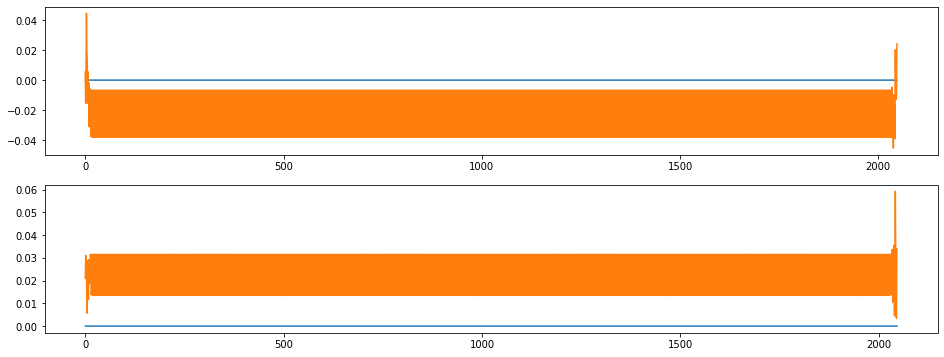

index:  378481
MAE:  0.019067612996423122
n_bunches       636
bunch_index     400
bunch_number    268
Name: 13142, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


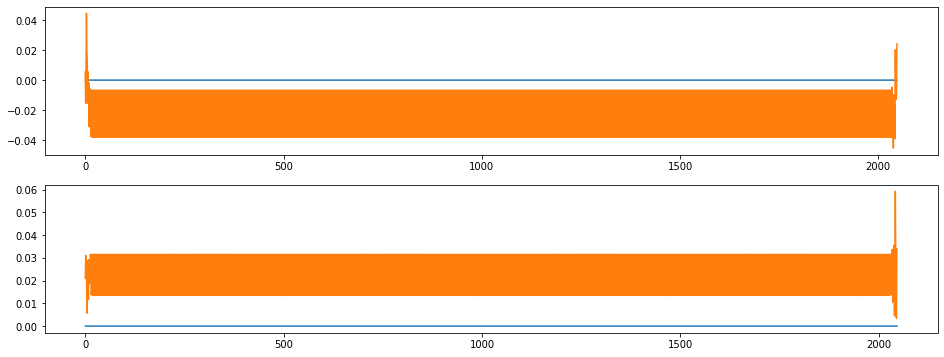

index:  313342
MAE:  0.019067612996423122
n_bunches        648
bunch_index     2285
bunch_number     427
Name: 10902, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


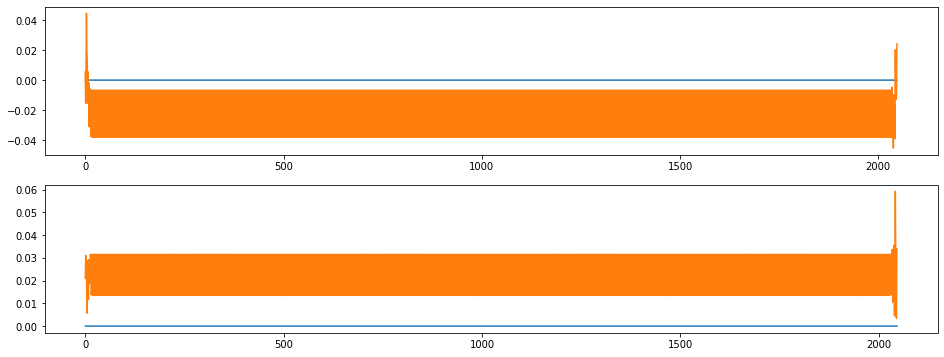

index:  313507
MAE:  0.019067612996423122
n_bunches        648
bunch_index     2317
bunch_number     434
Name: 10909, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


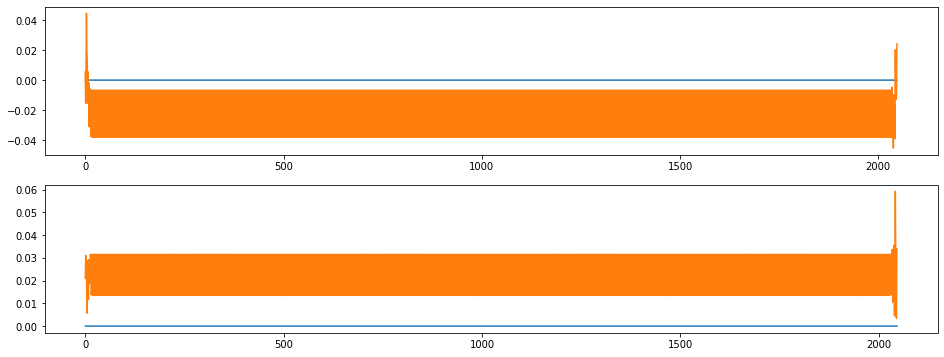

index:  6363
MAE:  0.019067612996423122
n_bunches       972
bunch_index      14
bunch_number      2
Name: 215, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


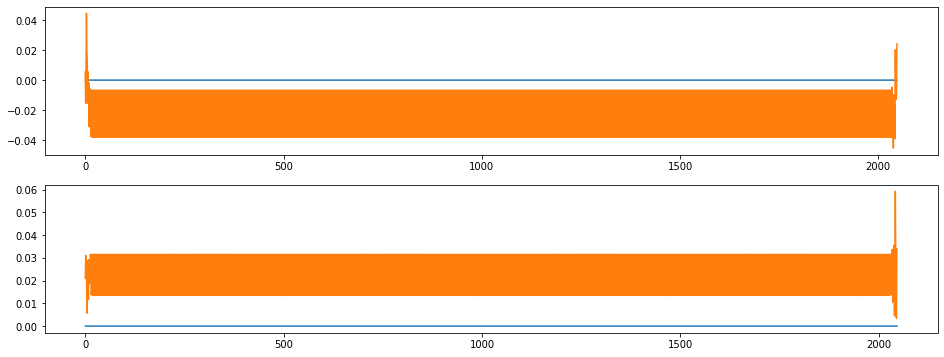

index:  218998
MAE:  0.019067612996423122
n_bunches        987
bunch_index     1352
bunch_number     377
Name: 7605, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


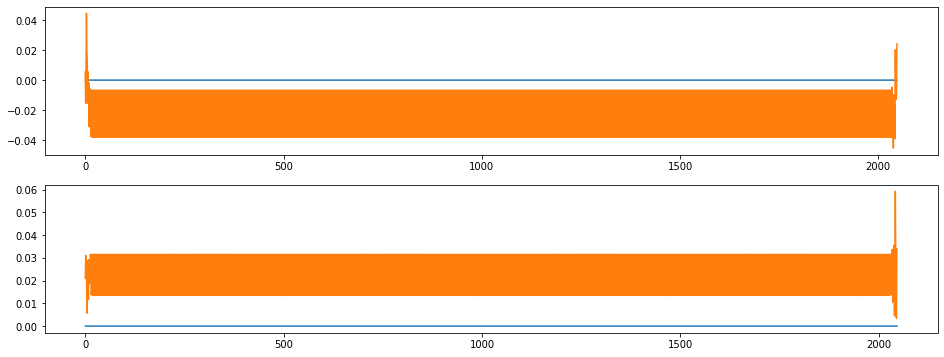

index:  257007
MAE:  0.019067612996423122
n_bunches       372
bunch_index     633
bunch_number    114
Name: 8920, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


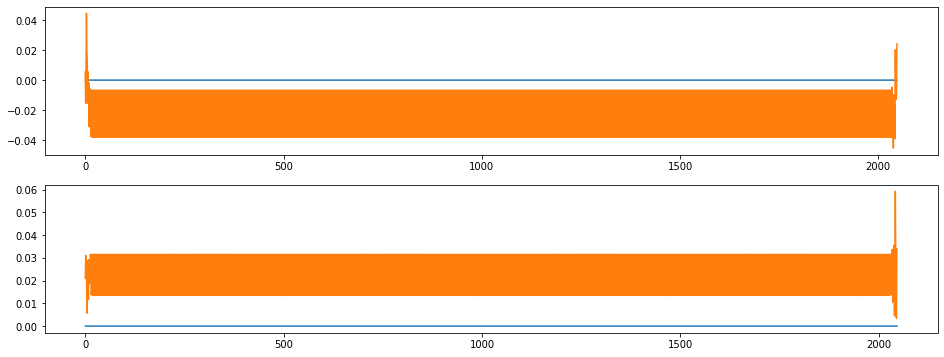

index:  333780
MAE:  0.019067612996423122
n_bunches       1358
bunch_index     1285
bunch_number     487
Name: 11610, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h23m14s.h5


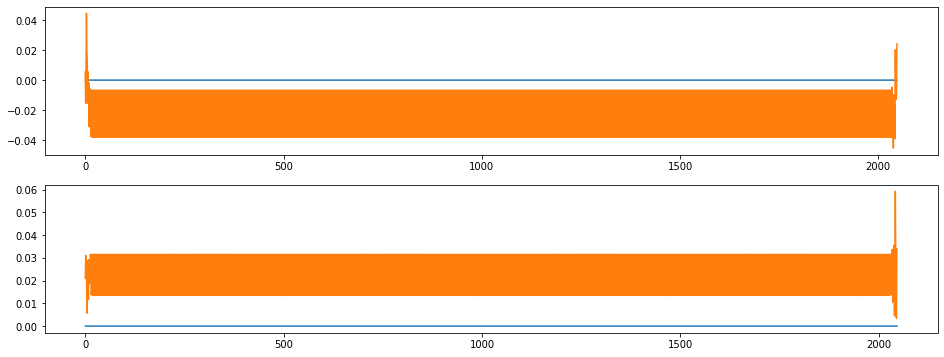

index:  28089
MAE:  0.019067612996423122
n_bunches        972
bunch_index     1428
bunch_number     760
Name: 973, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


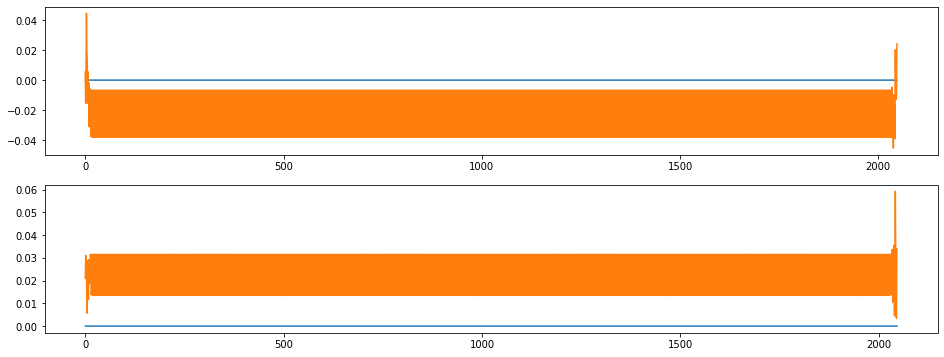

index:  167935
MAE:  0.019067612996423122
n_bunches       684
bunch_index     941
bunch_number    508
Name: 5822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


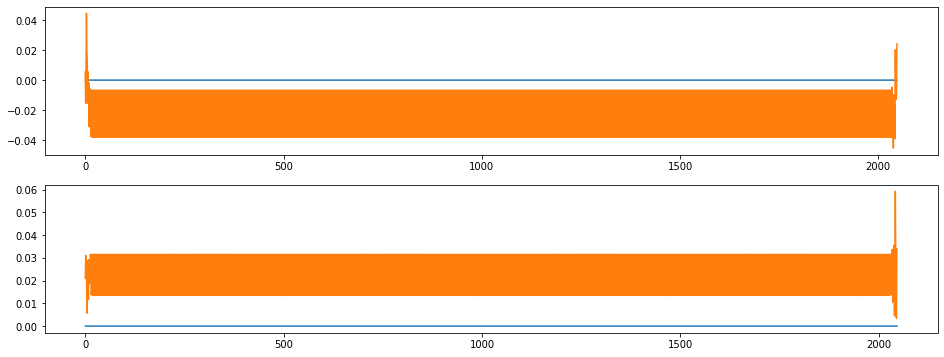

index:  381036
MAE:  0.019067612996423122
n_bunches       636
bunch_index     508
bunch_number    362
Name: 13236, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


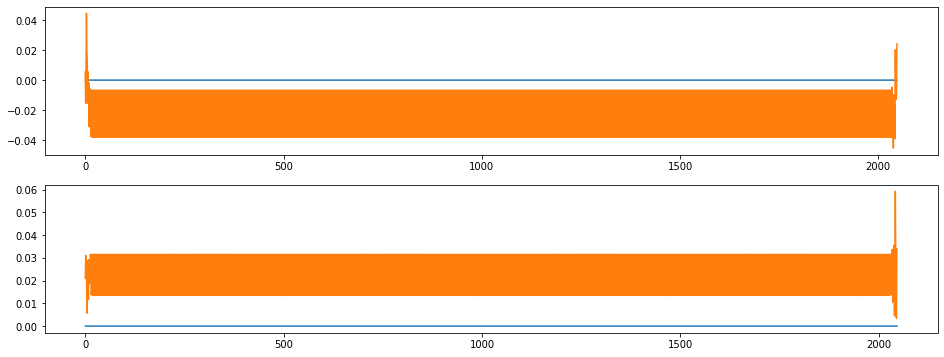

index:  204075
MAE:  0.019067612996423122
n_bunches       1227
bunch_index     3133
bunch_number    1092
Name: 7090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


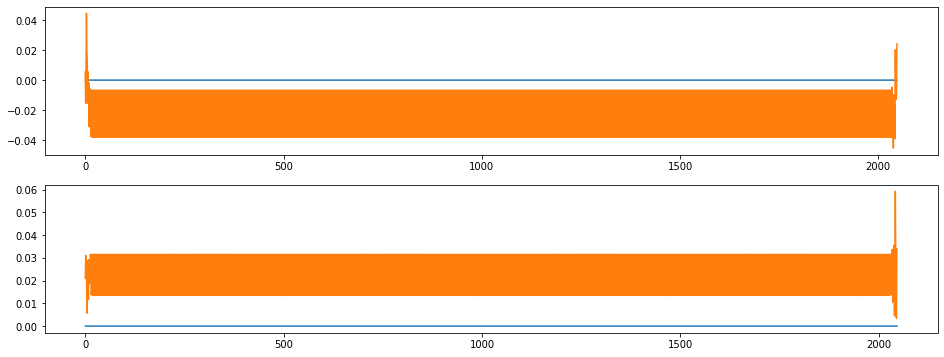

index:  388249
MAE:  0.019067612996423122
n_bunches       636
bunch_index     841
bunch_number    608
Name: 13482, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


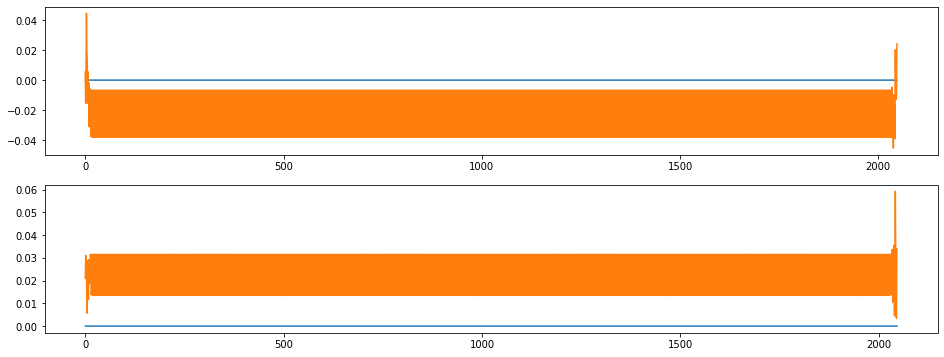

index:  243336
MAE:  0.019067612996423122
n_bunches       300
bunch_index     439
bunch_number    204
Name: 8445, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


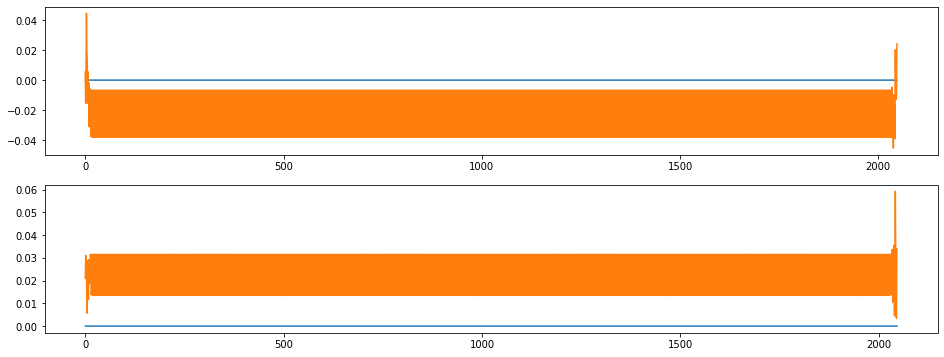

index:  313347
MAE:  0.019067612996423122
n_bunches        648
bunch_index     2291
bunch_number     428
Name: 10903, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


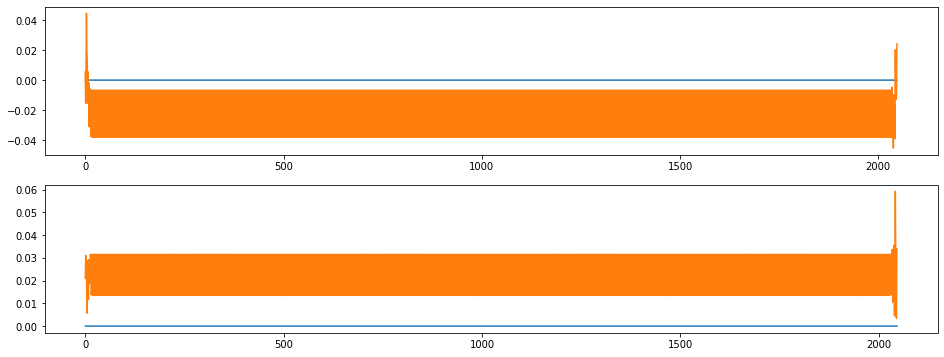

index:  388066
MAE:  0.019067612996423122
n_bunches       636
bunch_index     836
bunch_number    603
Name: 13477, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


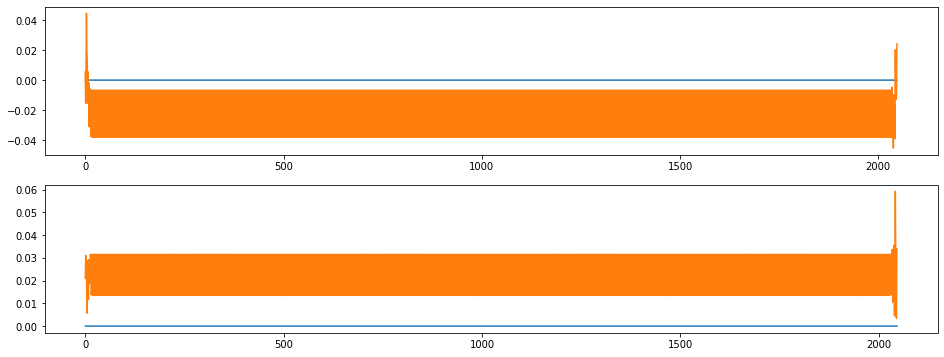

index:  33008
MAE:  0.019067612996423122
n_bunches        972
bunch_index     1754
bunch_number     930
Name: 1143, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


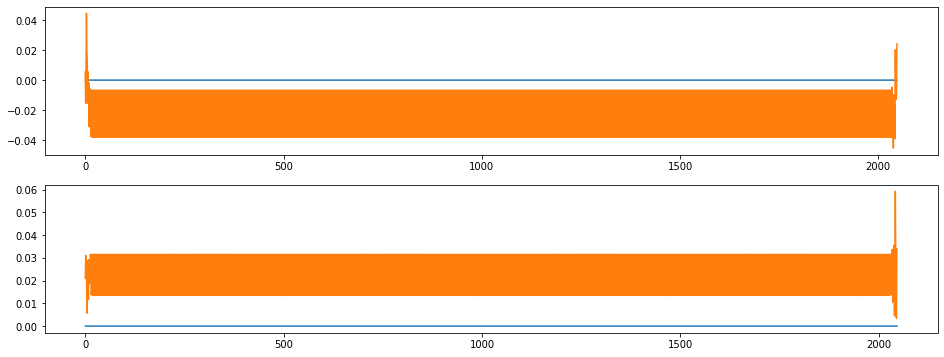

index:  381422
MAE:  0.019067612996423122
n_bunches       636
bunch_index     521
bunch_number    375
Name: 13249, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


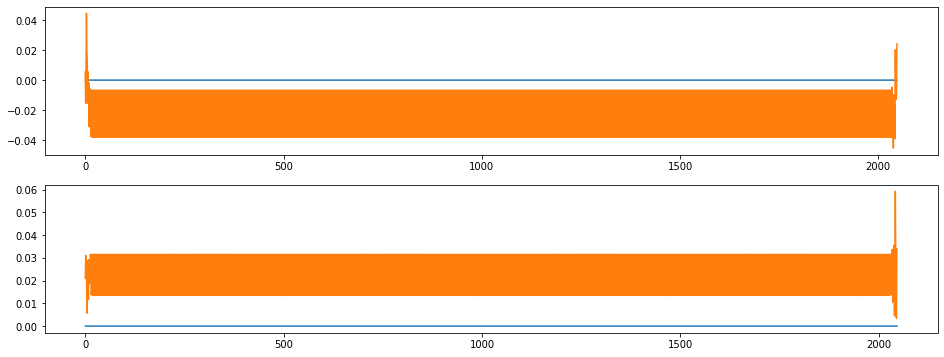

index:  144016
MAE:  0.019067612996423122
n_bunches       572
bunch_index     447
bunch_number    237
Name: 4979, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


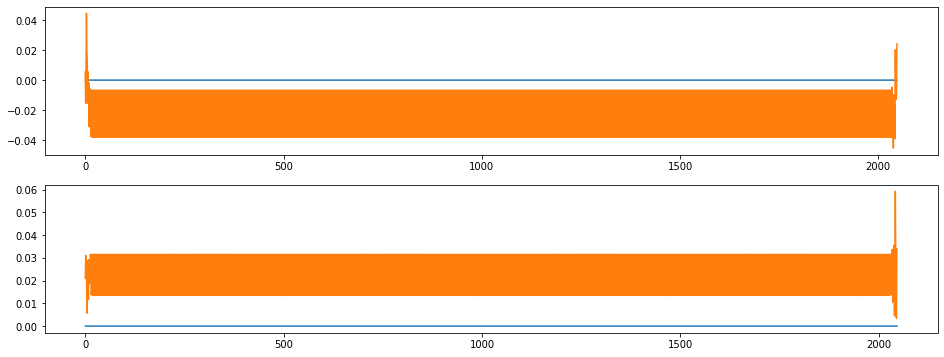

index:  38404
MAE:  0.019067612996423122
n_bunches       733
bunch_index     691
bunch_number    145
Name: 1330, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


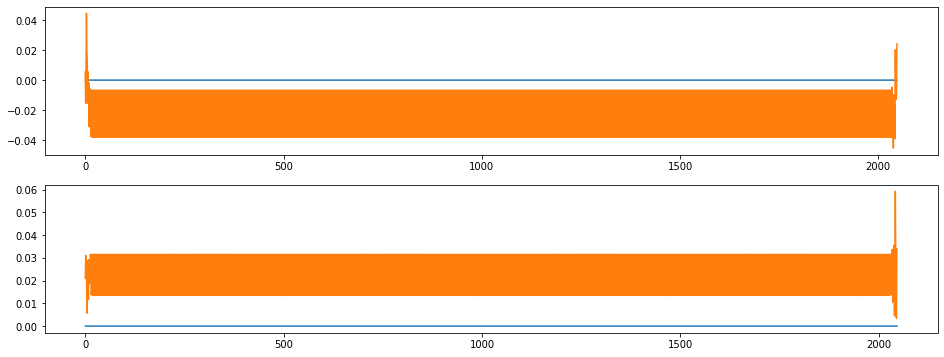

index:  145156
MAE:  0.019067612996423122
n_bunches       572
bunch_index     508
bunch_number    278
Name: 5020, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


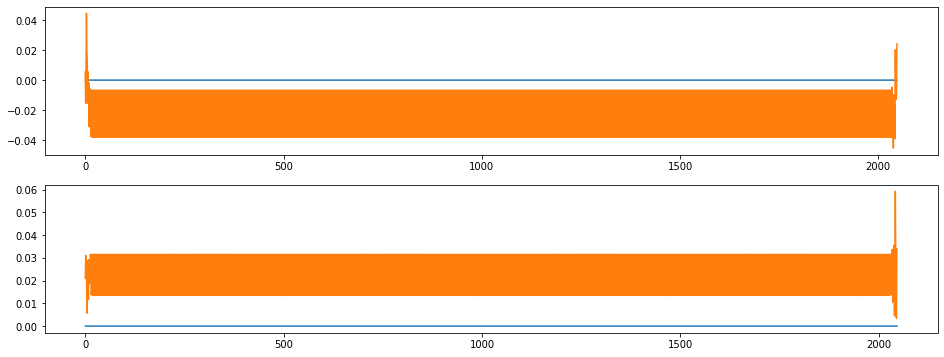

index:  95410
MAE:  0.019067612996423122
n_bunches        418
bunch_index     1173
bunch_number     245
Name: 3315, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h48m56s.h5


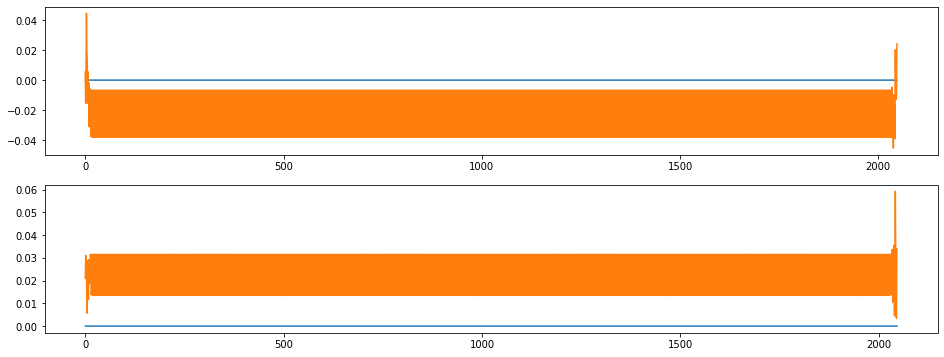

index:  192345
MAE:  0.019067612996423122
n_bunches       1227
bunch_index     1973
bunch_number     687
Name: 6685, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


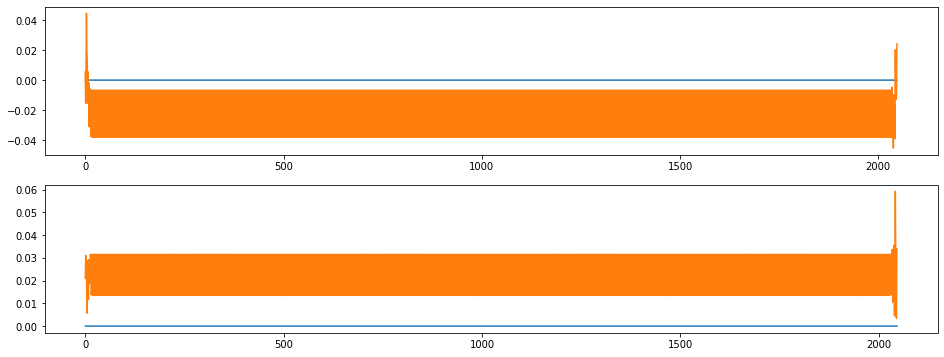

index:  165875
MAE:  0.019067612996423122
n_bunches       684
bunch_index     810
bunch_number    440
Name: 5754, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


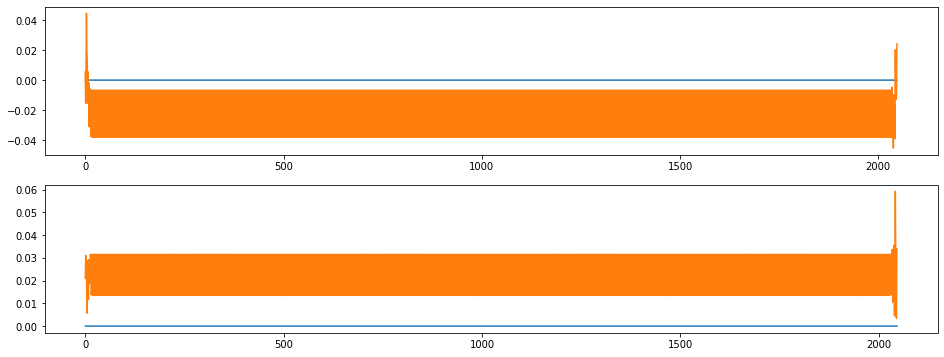

index:  196506
MAE:  0.019067612996423122
n_bunches       1227
bunch_index     2264
bunch_number     828
Name: 6826, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h45m14s.h5


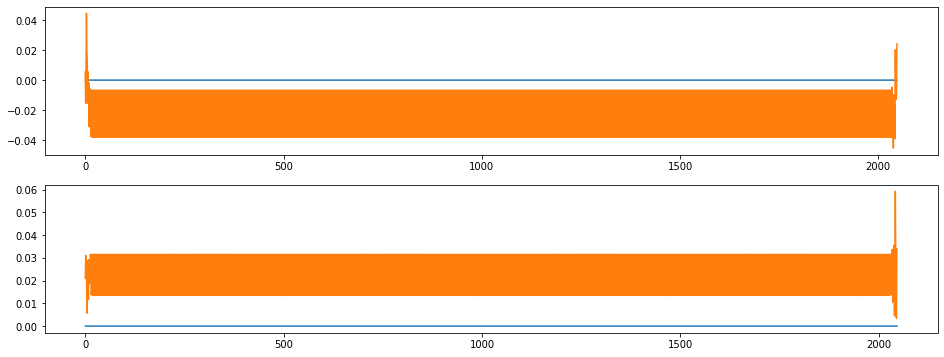

index:  151874
MAE:  0.019067612996423122
n_bunches       572
bunch_index     945
bunch_number    512
Name: 5254, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


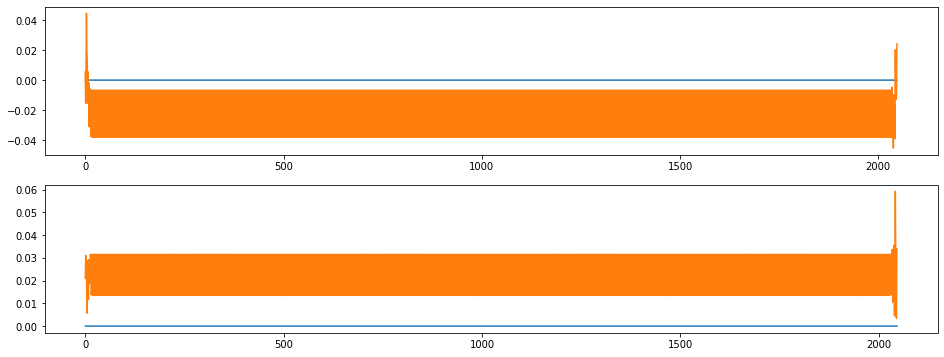

index:  284530
MAE:  0.019067612996423122
n_bunches        648
bunch_index     1206
bunch_number     223
Name: 9892, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


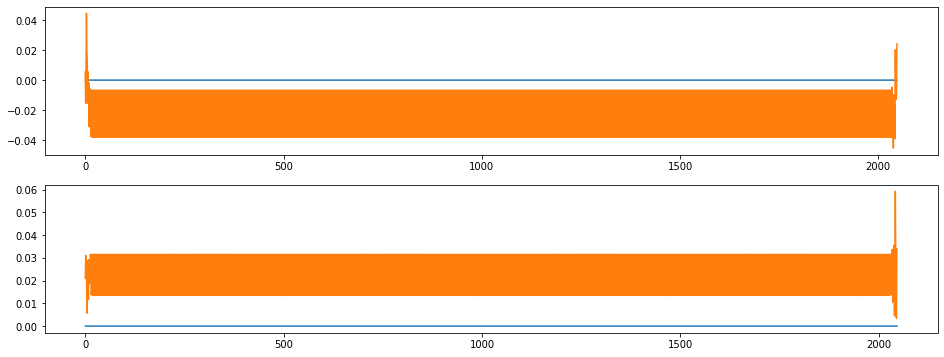

index:  317470
MAE:  0.019067612996423122
n_bunches        648
bunch_index     2998
bunch_number     561
Name: 11036, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


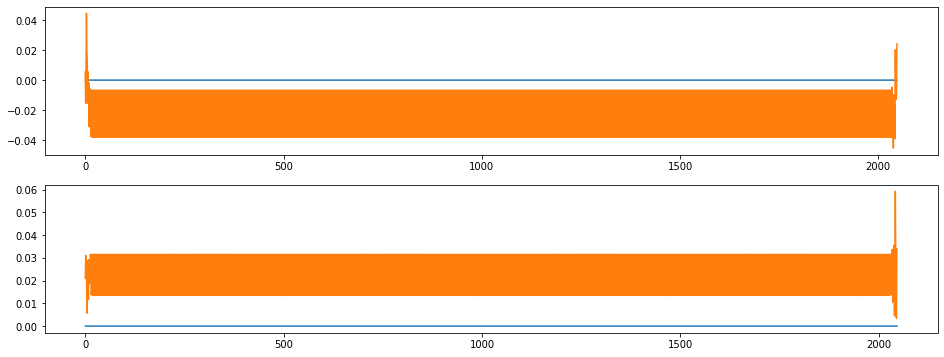

index:  308326
MAE:  0.019067612996423122
n_bunches        648
bunch_index     1368
bunch_number     253
Name: 10728, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_07h56m14s.h5


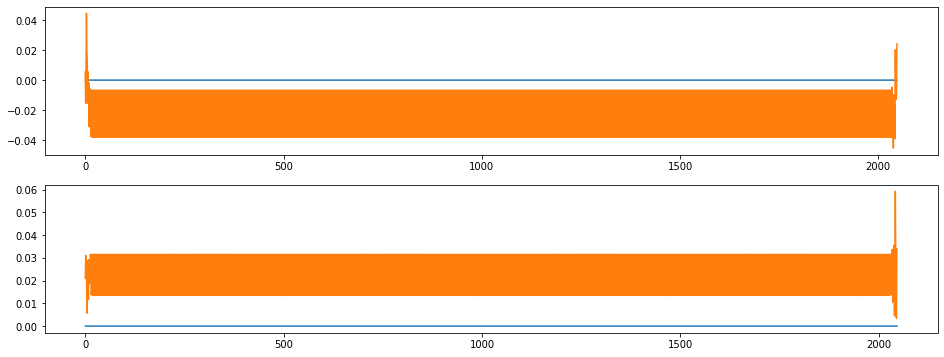

index:  167832
MAE:  0.019067612996423122
n_bunches       684
bunch_index     934
bunch_number    505
Name: 5819, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


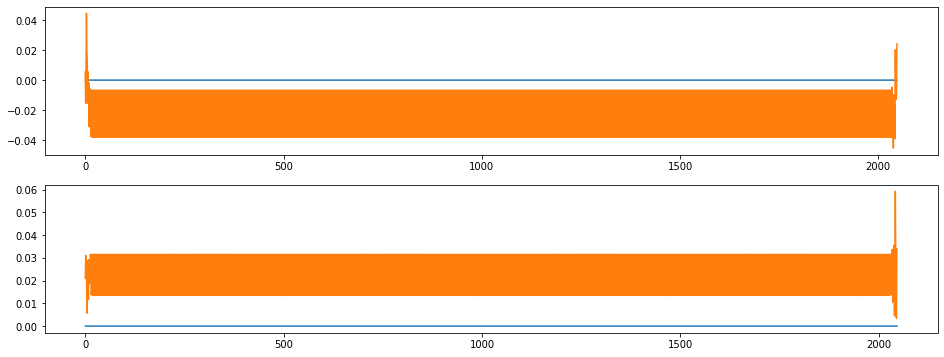

index:  47340
MAE:  0.019067612996423122
n_bunches        733
bunch_index     2195
bunch_number     460
Name: 1645, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_09h54m15s.h5


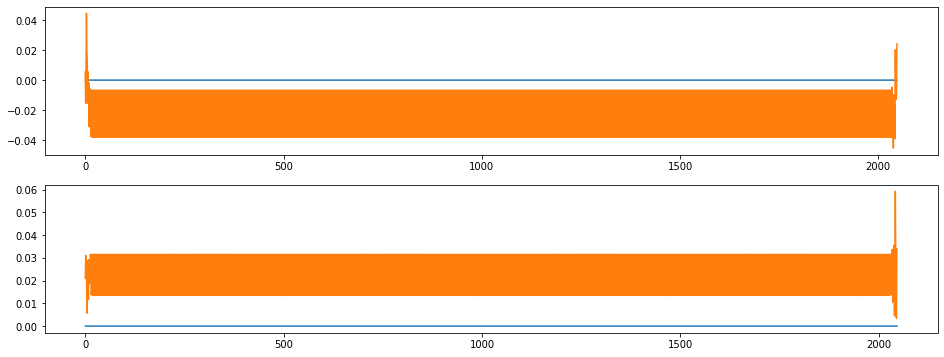

index:  230798
MAE:  0.019067612996423122
n_bunches        987
bunch_index     2903
bunch_number     792
Name: 8020, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h23m14s.h5


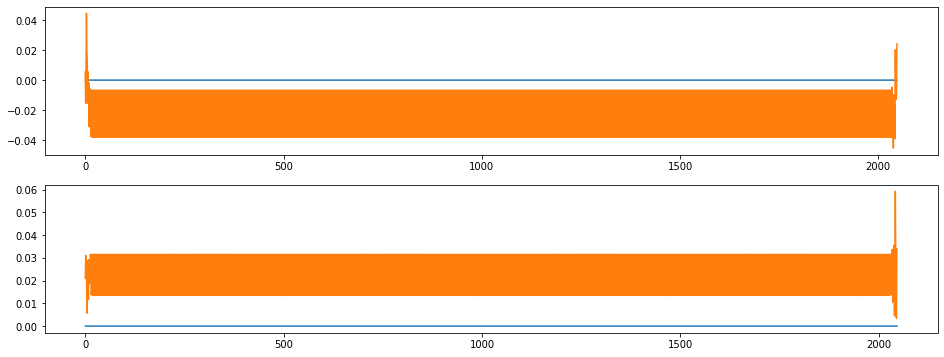

index:  155435
MAE:  0.019067612996423122
n_bunches       684
bunch_index     127
bunch_number     65
Name: 5379, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


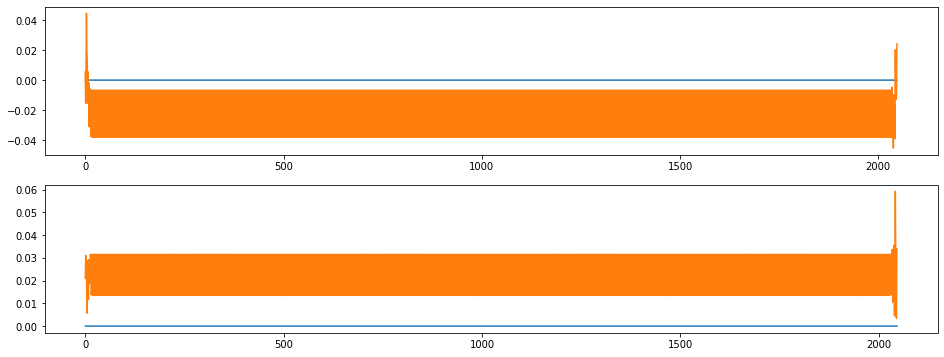

index:  388095
MAE:  0.019067612996423122
n_bunches       636
bunch_index     836
bunch_number    603
Name: 13477, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h43m34s.h5


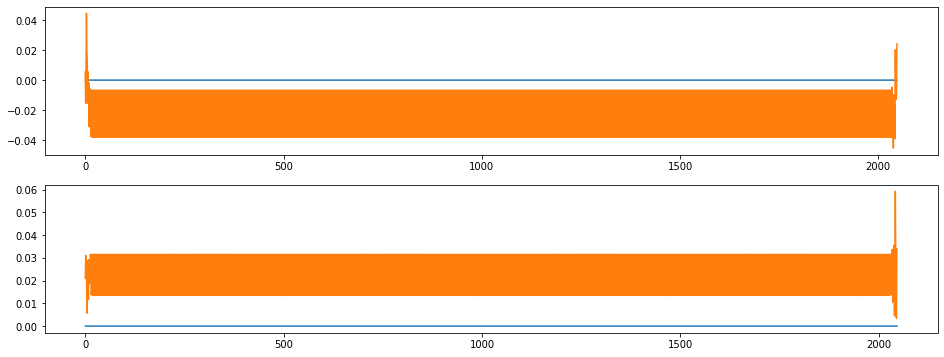

index:  156135
MAE:  0.019067612996423122
n_bunches       684
bunch_index     192
bunch_number     91
Name: 5405, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m43s.h5


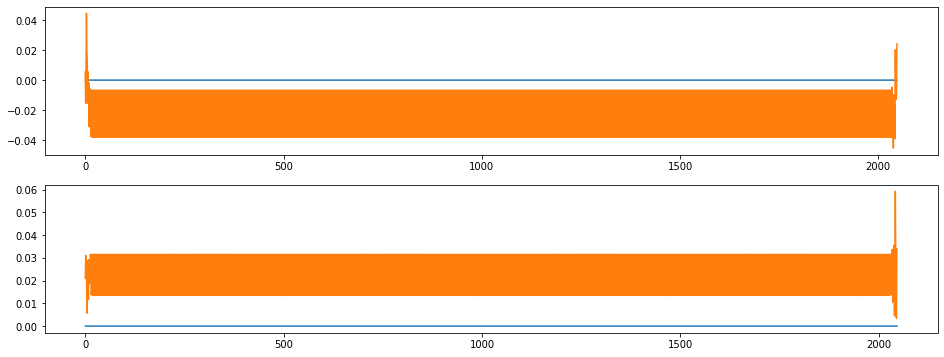

index:  28112
MAE:  0.019067612996423122
n_bunches        972
bunch_index     1429
bunch_number     761
Name: 974, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


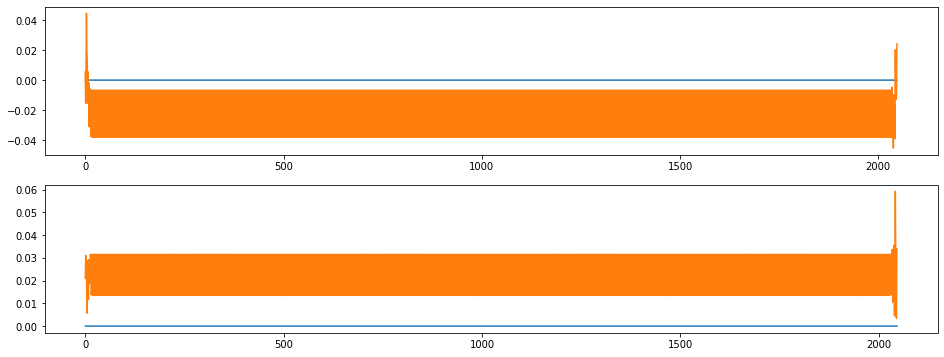

index:  256708
MAE:  0.019067612996423122
n_bunches       372
bunch_index     557
bunch_number    103
Name: 8909, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h25m20s.h5


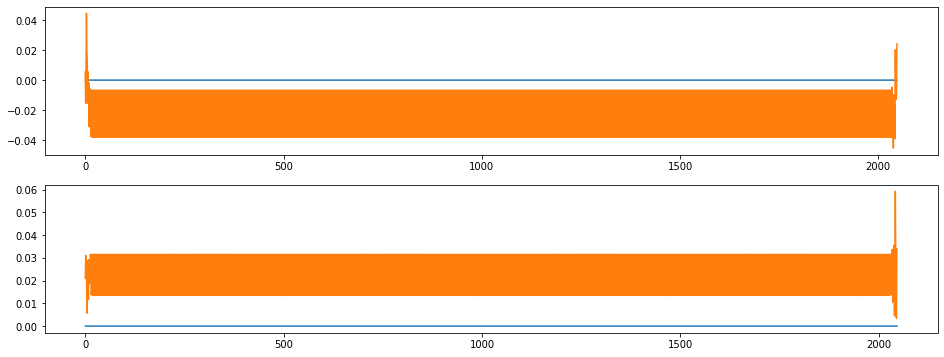

index:  10559
MAE:  0.019067612996423122
n_bunches       972
bunch_index     295
bunch_number    145
Name: 358, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h30m07s.h5


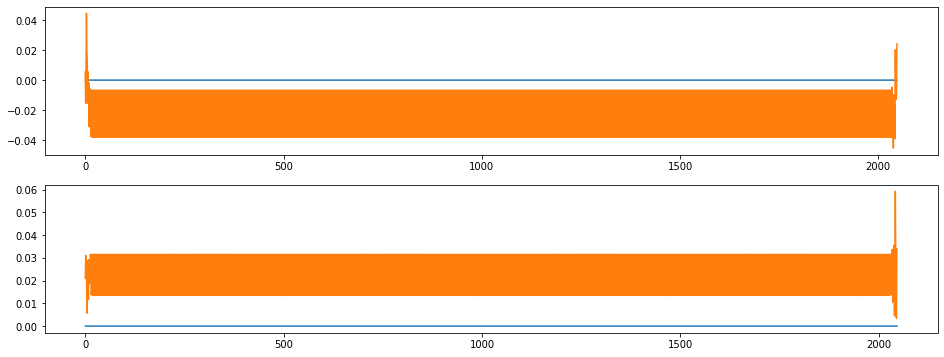

index:  122459
MAE:  0.019067612996423122
n_bunches       796
bunch_index     593
bunch_number    316
Name: 4250, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h19m38s.h5


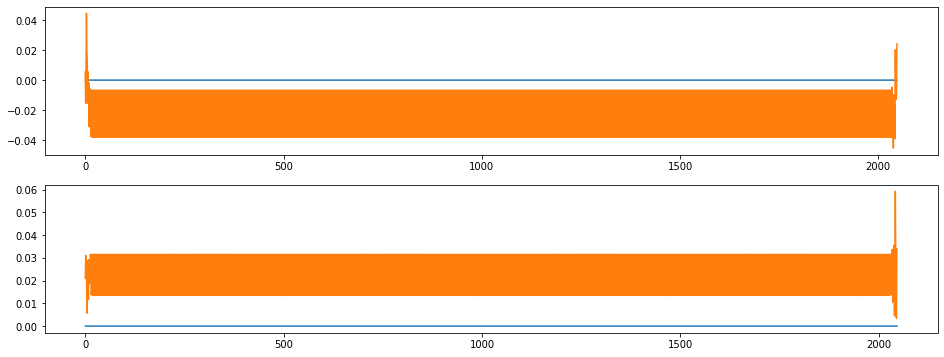

index:  275172
MAE:  0.019067612996423122
n_bunches       252
bunch_index     342
bunch_number    241
Name: 9570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h34m19s.h5


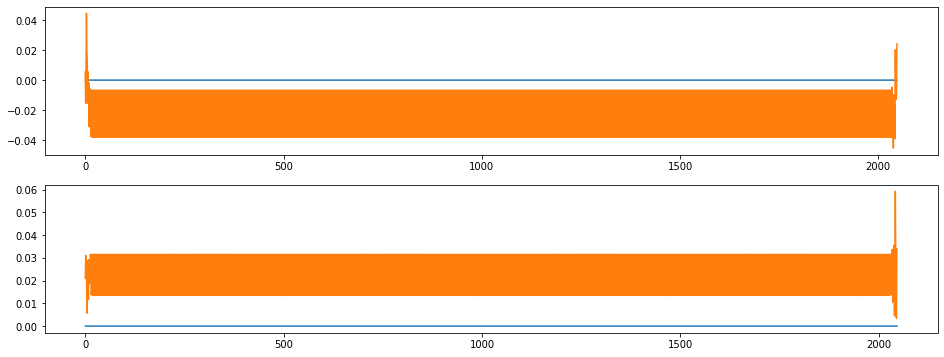

index:  392311
MAE:  0.019067612996423122
n_bunches       396
bunch_index     205
bunch_number    118
Name: 13628, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


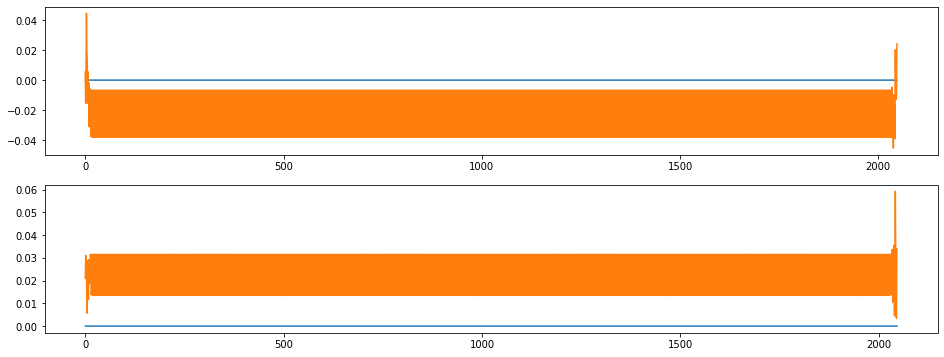

index:  151848
MAE:  0.019067612996423122
n_bunches       572
bunch_index     943
bunch_number    510
Name: 5252, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


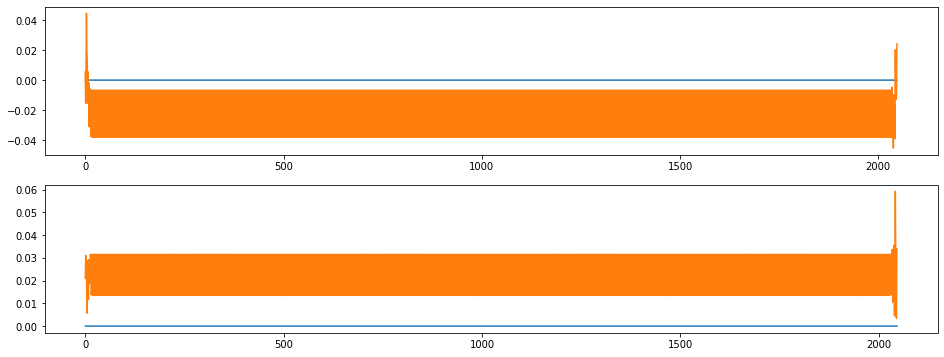

index:  284785
MAE:  0.019067612996423122
n_bunches        648
bunch_index     1256
bunch_number     234
Name: 9903, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181116_02h46m18s.h5


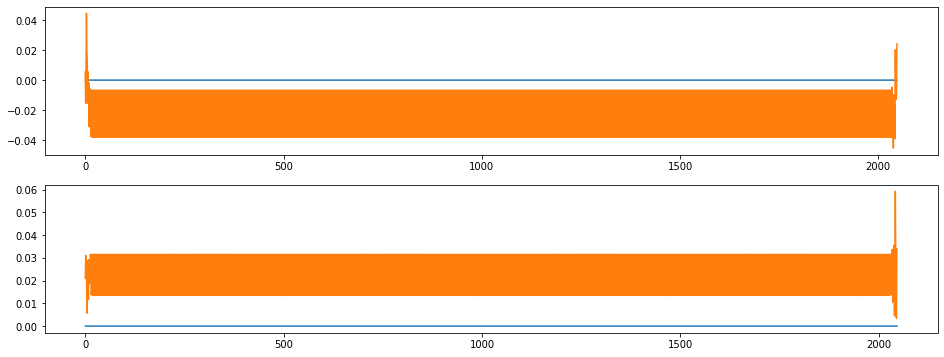

index:  246026
MAE:  0.019067612996423122
n_bunches       300
bunch_index     541
bunch_number    299
Name: 8540, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6989/instability_data/06989_Inst_B1H_Q7_20180727_06h58m14s.h5


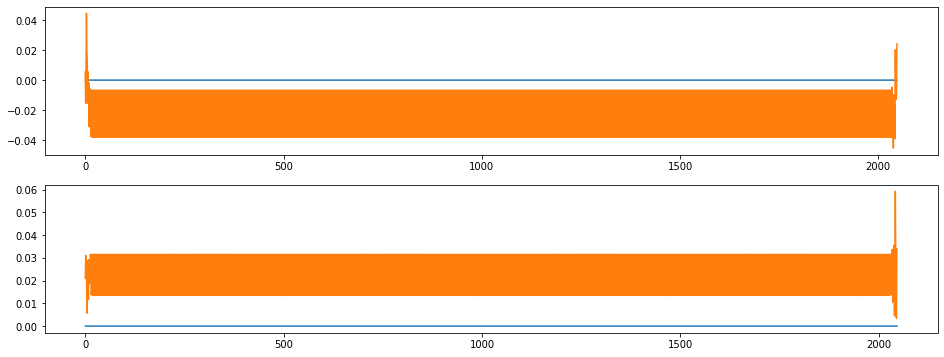

index:  395136
MAE:  0.019067612996423122
n_bunches       396
bunch_index     318
bunch_number    217
Name: 13727, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h29m11s.h5


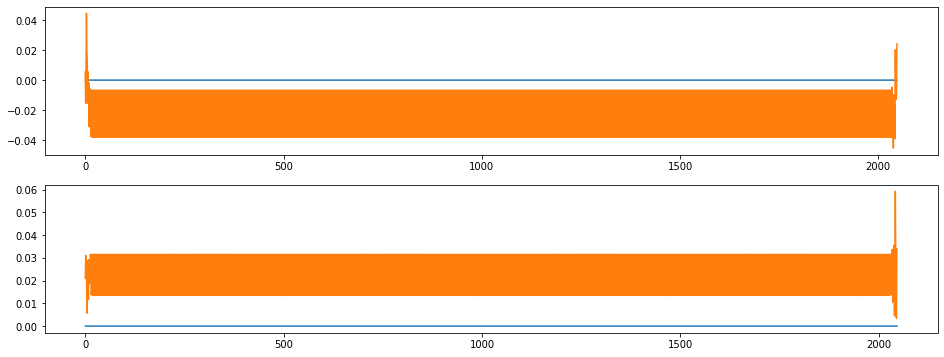

index:  297113
MAE:  0.019067612996423122
n_bunches       158
bunch_index     640
bunch_number     26
Name: 10343, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7343/instability_data/07343_Inst_B1H_Q7_20181025_05h31m18s.h5


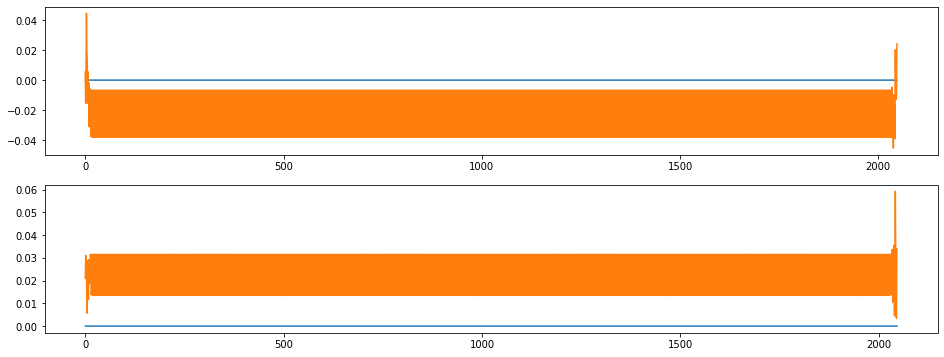

index:  151711
MAE:  0.019067612996423122
n_bunches       572
bunch_index     934
bunch_number    505
Name: 5247, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h56m36s.h5


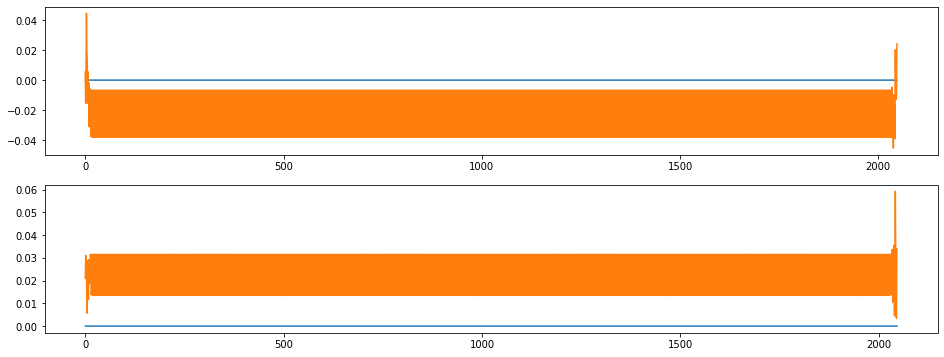

In [27]:
for i in range(200):
    around_cluster_index = around_cluster_indices[i]

    print('index: ', around_cluster_index)
    print("MAE: ", MAE_train[around_cluster_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_cluster_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_cluster_index].squeeze()
    pred_signal = train_pred[around_cluster_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()